In [1]:
!pip install -r ../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NEURAL_NETWORK_NAME = 'freehand_v2_dft_iq'

OUTPUT_FILENAME = NEURAL_NETWORK_NAME + '.dat'
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

# Imports

In [3]:
import pickle
import pandas as pd
import h5py
import cmath
import numpy as np

import keras
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D

import matplotlib.pyplot as plt

import sys
sys.path.append(ROOT_DIR)

import neural_networks

# Dataset

In [4]:
dataset_filename = DATASET_2016_10a_FILENAME

dataset = []

with (open(dataset_filename, "rb")) as dataset_file:
    data = dataset_file.read()
    data_dict = pickle.loads(data, encoding='bytes') # unpickle data
    keys = data_dict.keys()
    
    # for each key in dataset keys
    for key in keys:
        # extract modulation label and snr
        modulation, snr = key[0].decode("utf-8") , key[1]
        
        # for each I/Q signal couple sample
        for signal in data_dict[key]:
            # save the tuple (signal, modulation_label, snr) in the list
            tuple = (signal, modulation, snr)
            dataset.append(tuple)

## Dataset in a pandas Dataframe

In [5]:
dataset_df = pd.DataFrame(data=dataset)

# pandas aesthetics

iq_signals_column_dataframe_name = 'IQ signals'
modulation_label_column_dataframe_name = 'Modulation_Label'
snr_column_dataframe_name = 'SNR'

dataset_df.columns = [
    iq_signals_column_dataframe_name,
    modulation_label_column_dataframe_name,
    snr_column_dataframe_name
]

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Discrete Fourier Transform

Each signal is transformed from an I/Q sample using Discrete Fourier Transform, and added as a column to the dataset.

In [7]:
def I_Q_to_DFT(signal):
    complex_IQ_representation = []
    
    # a signal is 
    I = signal[0]
    Q = signal[1]

    # for each <i,q> couple
    for j in range(0, len(I)):
        cmplx = complex(I[j], Q[j]) # <i,q> can be represented as a complex number (i = real part, q = complex part)
        complex_IQ_representation.append(cmplx)
    
    # numpy fft(arr) transforms an array 'arr' of complex numbers using Discrete Fourier Transform
    ffted_cplx = np.fft.fft(complex_IQ_representation)
    return [ffted_cplx.real, ffted_cplx.imag]

### Attention

This isn't a really heavy computation, but careful executing this block on devices with low computational resources, it may require a long time.

In [8]:
transformed_signals = []

for index, row in dataset_df.iterrows():
    signal = row[iq_signals_column_dataframe_name]
    transformed_signal = I_Q_to_DFT(signal)
    
    # transformed_signal is a train of values
    transformed_signals.append(transformed_signal)

In [9]:
dft_signals_column_dataframe_name = 'DFT signals'

# add Module/Phase signals to pandas Dataframe
dataset_df[dft_signals_column_dataframe_name] = transformed_signals

# (Aesthetics) Rearrange columns to show signal columns, and then other columns
df_columns = [
    iq_signals_column_dataframe_name,
    dft_signals_column_dataframe_name,
    modulation_label_column_dataframe_name,
    snr_column_dataframe_name
]
dataset_df = dataset_df[df_columns]

## The dataset after adding DFT Signals

In [10]:
dataset_df

,IQ signals,DFT signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...","[[-0.060862621969135944, -0.22769021567320955,...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...","[[0.07303547981427982, 0.21388404694926202, -0...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...","[[0.07157310681941453, 0.06983173884925772, -0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...","[[0.06919694535099552, 0.05751631710576523, -0...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...","[[0.16920786396804033, 0.3561287889109632, 0.3...",QPSK,2
...,...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....","[[-0.02215634343883721, 0.11752126689233586, 0...",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....","[[-0.10105456630867593, -0.10305432796774971, ...",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....","[[-0.0646182048258197, 0.0054176624689576194, ...",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...","[[-0.16591021459316835, 0.001243809761688204, ...",BPSK,-18


# Neural network

## Configuration

In [11]:
TRAINING_SET_DIMENSION = 0.7
DROPOUT_RATE = 0.5

# Set up some params 
NB_EPOCH = 100     # number of epochs to train on
BATCH_SIZE = 1024  # training batch size

## Data prepare

In [12]:
signals = []

for i in range(0, len(dataset_df.index)):
    I = dataset_df[iq_signals_column_dataframe_name][i][0]
    Q = dataset_df[iq_signals_column_dataframe_name][i][1]
    DFT_1 = dataset_df[dft_signals_column_dataframe_name][i][0]
    DFT_2 = dataset_df[dft_signals_column_dataframe_name][i][1]
    
    signals.append([I, Q, DFT_1, DFT_2])
    
labels = dataset_df[modulation_label_column_dataframe_name].tolist()

# [QPSQ, BPSK, ...]
mods = dataset_df[modulation_label_column_dataframe_name].unique().tolist()
mods.sort()
# [-18, -16, ...]
snrs = dataset_df[snr_column_dataframe_name].unique().tolist()
snrs.sort()

### Training and Test data partitioning

In [13]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each

# seeding the random numpy object
np.random.seed(2016)

# 220.000
n_examples = len(signals)

# take a portion of the dataset as training set
n_train = int(n_examples * TRAINING_SET_DIMENSION)

# extract datapoints indexes randomly
# train_index = [I_1, I_2, ..., I_N_TRAIN]
train_index = np.random.choice(range(0,n_examples), size=n_train, replace=False)

# obtain the remaining datapoints indexes
# test_index = [I_1, I_2, ..., I_HALF_N_EXAMPLES]
test_index = list(set(range(0,n_examples)) - set(train_index))

signals = np.array(signals)

X_train = signals[train_index]
X_test =  signals[test_index]

### One-hot encoding for Training and Test labels

In [14]:
def to_onehot(x):
    input_list = list(x)
    vectors_number = len(list(input_list))
    number_of_elements_for_each_vector = max(input_list, default=0) + 1

    # one hot encoding is a vector of zeros, and only a 1 that identifies the class
    # producing <vectors_number> vectors of <number_of_elements_for_each_vector> elements
    result = np.zeros([vectors_number, number_of_elements_for_each_vector])
    
    # placing the 1 in the correct place
    for i in range(0, vectors_number):
        result[i][input_list[i]] = 1
    
    return result

Y_train = to_onehot(map(lambda x: mods.index(labels[x]), train_index))
Y_test = to_onehot(map(lambda x: mods.index(labels[x]), test_index))

## Build the Neural Network

In [15]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(154000, 4, 128)
[4, 128]


In [16]:
model = neural_networks.freehand_v2(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4, 128)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 128, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 4, 128, 16)        272       
_________________________________________________________________
dense (Dense)                (None, 4, 128, 256)       4352      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 128, 32)        32800     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 64, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0     

### Train the model

In [17]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history = model.fit(
    X_train,
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=NB_EPOCH,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])

# we re-load the best weights once training is finished
model.load_weights(filepath)

Epoch 1/100


  1/151 [..............................] - ETA: 30:47 - loss: 2.3978

  2/151 [..............................] - ETA: 17s - loss: 2.3970  

  3/151 [..............................] - ETA: 17s - loss: 2.3961

  4/151 [..............................] - ETA: 17s - loss: 2.3950

  5/151 [..............................] - ETA: 17s - loss: 2.3936

  6/151 [>.............................] - ETA: 17s - loss: 2.3920

  7/151 [>.............................] - ETA: 16s - loss: 2.3899

  8/151 [>.............................] - ETA: 16s - loss: 2.3871

  9/151 [>.............................] - ETA: 16s - loss: 2.3841

 10/151 [>.............................] - ETA: 16s - loss: 2.3810

 11/151 [=>............................] - ETA: 16s - loss: 2.3775

 12/151 [=>............................] - ETA: 16s - loss: 2.3737

 13/151 [=>............................] - ETA: 16s - loss: 2.3697

 14/151 [=>............................] - ETA: 16s - loss: 2.3654

 15/151 [=>............................] - ETA: 15s - loss: 2.3608

 16/151 [==>...........................] - ETA: 15s - loss: 2.3558

 17/151 [==>...........................] - ETA: 15s - loss: 2.3507

 18/151 [==>...........................] - ETA: 15s - loss: 2.3454

 19/151 [==>...........................] - ETA: 15s - loss: 2.3401

 20/151 [==>...........................] - ETA: 15s - loss: 2.3348

 21/151 [===>..........................] - ETA: 15s - loss: 2.3295

 22/151 [===>..........................] - ETA: 15s - loss: 2.3241

 23/151 [===>..........................] - ETA: 15s - loss: 2.3188

 24/151 [===>..........................] - ETA: 14s - loss: 2.3135

 25/151 [===>..........................] - ETA: 14s - loss: 2.3082

 26/151 [====>.........................] - ETA: 14s - loss: 2.3030

 27/151 [====>.........................] - ETA: 14s - loss: 2.2978

 28/151 [====>.........................] - ETA: 14s - loss: 2.2927

 29/151 [====>.........................] - ETA: 14s - loss: 2.2877

 30/151 [====>.........................] - ETA: 14s - loss: 2.2827

 31/151 [=====>........................] - ETA: 14s - loss: 2.2777

 32/151 [=====>........................] - ETA: 13s - loss: 2.2728

 33/151 [=====>........................] - ETA: 13s - loss: 2.2679

 34/151 [=====>........................] - ETA: 13s - loss: 2.2631

 35/151 [=====>........................] - ETA: 13s - loss: 2.2584

 36/151 [======>.......................] - ETA: 13s - loss: 2.2538

 37/151 [======>.......................] - ETA: 13s - loss: 2.2492

 38/151 [======>.......................] - ETA: 13s - loss: 2.2447

 39/151 [======>.......................] - ETA: 13s - loss: 2.2403

 40/151 [======>.......................] - ETA: 13s - loss: 2.2359

 41/151 [=======>......................] - ETA: 12s - loss: 2.2315

 42/151 [=======>......................] - ETA: 12s - loss: 2.2273

 43/151 [=======>......................] - ETA: 12s - loss: 2.2231

 44/151 [=======>......................] - ETA: 12s - loss: 2.2190

 45/151 [=======>......................] - ETA: 12s - loss: 2.2150

 46/151 [========>.....................] - ETA: 12s - loss: 2.2111

 47/151 [========>.....................] - ETA: 12s - loss: 2.2072

 48/151 [========>.....................] - ETA: 12s - loss: 2.2035

 49/151 [========>.....................] - ETA: 11s - loss: 2.1997

 50/151 [========>.....................] - ETA: 11s - loss: 2.1961

 51/151 [=========>....................] - ETA: 11s - loss: 2.1925

 52/151 [=========>....................] - ETA: 11s - loss: 2.1890

 53/151 [=========>....................] - ETA: 11s - loss: 2.1855

 54/151 [=========>....................] - ETA: 11s - loss: 2.1821

 55/151 [=========>....................] - ETA: 11s - loss: 2.1788

 56/151 [==========>...................] - ETA: 11s - loss: 2.1755

 57/151 [==========>...................] - ETA: 10s - loss: 2.1722

 58/151 [==========>...................] - ETA: 10s - loss: 2.1691

 59/151 [==========>...................] - ETA: 10s - loss: 2.1659

 60/151 [==========>...................] - ETA: 10s - loss: 2.1629

 61/151 [===========>..................] - ETA: 10s - loss: 2.1599

 62/151 [===========>..................] - ETA: 10s - loss: 2.1569

 63/151 [===========>..................] - ETA: 10s - loss: 2.1540

 64/151 [===========>..................] - ETA: 10s - loss: 2.1511

 65/151 [===========>..................] - ETA: 10s - loss: 2.1483

 66/151 [============>.................] - ETA: 9s - loss: 2.1455 

 67/151 [============>.................] - ETA: 9s - loss: 2.1428

 68/151 [============>.................] - ETA: 9s - loss: 2.1401

 69/151 [============>.................] - ETA: 9s - loss: 2.1375

 70/151 [============>.................] - ETA: 9s - loss: 2.1349

 71/151 [=============>................] - ETA: 9s - loss: 2.1324

 72/151 [=============>................] - ETA: 9s - loss: 2.1299

 73/151 [=============>................] - ETA: 9s - loss: 2.1274

 74/151 [=============>................] - ETA: 8s - loss: 2.1250

 75/151 [=============>................] - ETA: 8s - loss: 2.1226

 76/151 [==============>...............] - ETA: 8s - loss: 2.1202

 77/151 [==============>...............] - ETA: 8s - loss: 2.1179

 78/151 [==============>...............] - ETA: 8s - loss: 2.1156

 79/151 [==============>...............] - ETA: 8s - loss: 2.1134

 80/151 [==============>...............] - ETA: 8s - loss: 2.1111

 81/151 [===============>..............] - ETA: 8s - loss: 2.1089

 82/151 [===============>..............] - ETA: 8s - loss: 2.1068

 83/151 [===============>..............] - ETA: 7s - loss: 2.1046

 84/151 [===============>..............] - ETA: 7s - loss: 2.1025

 85/151 [===============>..............] - ETA: 7s - loss: 2.1005

 86/151 [================>.............] - ETA: 7s - loss: 2.0984

 87/151 [================>.............] - ETA: 7s - loss: 2.0964

 88/151 [================>.............] - ETA: 7s - loss: 2.0944

 89/151 [================>.............] - ETA: 7s - loss: 2.0924

 90/151 [================>.............] - ETA: 7s - loss: 2.0905

 91/151 [=================>............] - ETA: 7s - loss: 2.0885

 92/151 [=================>............] - ETA: 6s - loss: 2.0866

 93/151 [=================>............] - ETA: 6s - loss: 2.0848

 94/151 [=================>............] - ETA: 6s - loss: 2.0829

 95/151 [=================>............] - ETA: 6s - loss: 2.0811

 96/151 [==================>...........] - ETA: 6s - loss: 2.0793

 97/151 [==================>...........] - ETA: 6s - loss: 2.0775

 98/151 [==================>...........] - ETA: 6s - loss: 2.0757

 99/151 [==================>...........] - ETA: 6s - loss: 2.0740

100/151 [==================>...........] - ETA: 5s - loss: 2.0722

101/151 [===================>..........] - ETA: 5s - loss: 2.0705

102/151 [===================>..........] - ETA: 5s - loss: 2.0689

103/151 [===================>..........] - ETA: 5s - loss: 2.0672

104/151 [===================>..........] - ETA: 5s - loss: 2.0655

105/151 [===================>..........] - ETA: 5s - loss: 2.0639

106/151 [====================>.........] - ETA: 5s - loss: 2.0623

107/151 [====================>.........] - ETA: 5s - loss: 2.0607

108/151 [====================>.........] - ETA: 5s - loss: 2.0592

109/151 [====================>.........] - ETA: 4s - loss: 2.0576

110/151 [====================>.........] - ETA: 4s - loss: 2.0561

111/151 [=====================>........] - ETA: 4s - loss: 2.0545

112/151 [=====================>........] - ETA: 4s - loss: 2.0530

113/151 [=====================>........] - ETA: 4s - loss: 2.0515

114/151 [=====================>........] - ETA: 4s - loss: 2.0501

115/151 [=====================>........] - ETA: 4s - loss: 2.0486

116/151 [======================>.......] - ETA: 4s - loss: 2.0472

117/151 [======================>.......] - ETA: 3s - loss: 2.0457

118/151 [======================>.......] - ETA: 3s - loss: 2.0443

119/151 [======================>.......] - ETA: 3s - loss: 2.0429

120/151 [======================>.......] - ETA: 3s - loss: 2.0415

121/151 [=======================>......] - ETA: 3s - loss: 2.0402

122/151 [=======================>......] - ETA: 3s - loss: 2.0388

123/151 [=======================>......] - ETA: 3s - loss: 2.0375

124/151 [=======================>......] - ETA: 3s - loss: 2.0361

125/151 [=======================>......] - ETA: 3s - loss: 2.0348

126/151 [========================>.....] - ETA: 2s - loss: 2.0335

127/151 [========================>.....] - ETA: 2s - loss: 2.0322

128/151 [========================>.....] - ETA: 2s - loss: 2.0310

129/151 [========================>.....] - ETA: 2s - loss: 2.0297

130/151 [========================>.....] - ETA: 2s - loss: 2.0284

131/151 [=========================>....] - ETA: 2s - loss: 2.0272

132/151 [=========================>....] - ETA: 2s - loss: 2.0260

133/151 [=========================>....] - ETA: 2s - loss: 2.0247

134/151 [=========================>....] - ETA: 1s - loss: 2.0235

135/151 [=========================>....] - ETA: 1s - loss: 2.0223

136/151 [==========================>...] - ETA: 1s - loss: 2.0211

137/151 [==========================>...] - ETA: 1s - loss: 2.0200

138/151 [==========================>...] - ETA: 1s - loss: 2.0188

139/151 [==========================>...] - ETA: 1s - loss: 2.0176

140/151 [==========================>...] - ETA: 1s - loss: 2.0165

141/151 [===========================>..] - ETA: 1s - loss: 2.0153

142/151 [===========================>..] - ETA: 1s - loss: 2.0142

143/151 [===========================>..] - ETA: 0s - loss: 2.0131

144/151 [===========================>..] - ETA: 0s - loss: 2.0120

145/151 [===========================>..] - ETA: 0s - loss: 2.0109

146/151 [============================>.] - ETA: 0s - loss: 2.0098

147/151 [============================>.] - ETA: 0s - loss: 2.0087

148/151 [============================>.] - ETA: 0s - loss: 2.0076

149/151 [============================>.] - ETA: 0s - loss: 2.0065

150/151 [============================>.] - ETA: 0s - loss: 2.0055

151/151 [==============================] - ETA: 0s - loss: 2.0044

151/151 [==============================] - 34s 142ms/step - loss: 2.0034 - val_loss: 1.7295


Epoch 2/100
  1/151 [..............................] - ETA: 17s - loss: 1.7365

  2/151 [..............................] - ETA: 17s - loss: 1.7254

  3/151 [..............................] - ETA: 17s - loss: 1.7257

  4/151 [..............................] - ETA: 17s - loss: 1.7244

  5/151 [..............................] - ETA: 17s - loss: 1.7245

  6/151 [>.............................] - ETA: 17s - loss: 1.7244

  7/151 [>.............................] - ETA: 16s - loss: 1.7237

  8/151 [>.............................] - ETA: 16s - loss: 1.7233

  9/151 [>.............................] - ETA: 16s - loss: 1.7228

 10/151 [>.............................] - ETA: 16s - loss: 1.7224

 11/151 [=>............................] - ETA: 16s - loss: 1.7223

 12/151 [=>............................] - ETA: 16s - loss: 1.7219

 13/151 [=>............................] - ETA: 16s - loss: 1.7216

 14/151 [=>............................] - ETA: 16s - loss: 1.7215

 15/151 [=>............................] - ETA: 15s - loss: 1.7215

 16/151 [==>...........................] - ETA: 15s - loss: 1.7214

 17/151 [==>...........................] - ETA: 15s - loss: 1.7214

 18/151 [==>...........................] - ETA: 15s - loss: 1.7213

 19/151 [==>...........................] - ETA: 15s - loss: 1.7213

 20/151 [==>...........................] - ETA: 15s - loss: 1.7213

 21/151 [===>..........................] - ETA: 15s - loss: 1.7212

 22/151 [===>..........................] - ETA: 15s - loss: 1.7211

 23/151 [===>..........................] - ETA: 14s - loss: 1.7210

 24/151 [===>..........................] - ETA: 14s - loss: 1.7208

 25/151 [===>..........................] - ETA: 14s - loss: 1.7206

 26/151 [====>.........................] - ETA: 14s - loss: 1.7204

 27/151 [====>.........................] - ETA: 14s - loss: 1.7202

 28/151 [====>.........................] - ETA: 14s - loss: 1.7201

 29/151 [====>.........................] - ETA: 14s - loss: 1.7199

 30/151 [====>.........................] - ETA: 14s - loss: 1.7199

 31/151 [=====>........................] - ETA: 14s - loss: 1.7197

 32/151 [=====>........................] - ETA: 13s - loss: 1.7196

 33/151 [=====>........................] - ETA: 13s - loss: 1.7195

 34/151 [=====>........................] - ETA: 13s - loss: 1.7195

 35/151 [=====>........................] - ETA: 13s - loss: 1.7194

 36/151 [======>.......................] - ETA: 13s - loss: 1.7193

 37/151 [======>.......................] - ETA: 13s - loss: 1.7192

 38/151 [======>.......................] - ETA: 13s - loss: 1.7190

 39/151 [======>.......................] - ETA: 13s - loss: 1.7189

 40/151 [======>.......................] - ETA: 12s - loss: 1.7187

 41/151 [=======>......................] - ETA: 12s - loss: 1.7185

 42/151 [=======>......................] - ETA: 12s - loss: 1.7183

 43/151 [=======>......................] - ETA: 12s - loss: 1.7181

 44/151 [=======>......................] - ETA: 12s - loss: 1.7178

 45/151 [=======>......................] - ETA: 12s - loss: 1.7176

 46/151 [========>.....................] - ETA: 12s - loss: 1.7174

 47/151 [========>.....................] - ETA: 12s - loss: 1.7171

 48/151 [========>.....................] - ETA: 12s - loss: 1.7168

 49/151 [========>.....................] - ETA: 11s - loss: 1.7166

 50/151 [========>.....................] - ETA: 11s - loss: 1.7163

 51/151 [=========>....................] - ETA: 11s - loss: 1.7161

 52/151 [=========>....................] - ETA: 11s - loss: 1.7158

 53/151 [=========>....................] - ETA: 11s - loss: 1.7156

 54/151 [=========>....................] - ETA: 11s - loss: 1.7153

 55/151 [=========>....................] - ETA: 11s - loss: 1.7151

 56/151 [==========>...................] - ETA: 11s - loss: 1.7149

 57/151 [==========>...................] - ETA: 10s - loss: 1.7146

 58/151 [==========>...................] - ETA: 10s - loss: 1.7144

 59/151 [==========>...................] - ETA: 10s - loss: 1.7142

 60/151 [==========>...................] - ETA: 10s - loss: 1.7139

 61/151 [===========>..................] - ETA: 10s - loss: 1.7137

 62/151 [===========>..................] - ETA: 10s - loss: 1.7134

 63/151 [===========>..................] - ETA: 10s - loss: 1.7132

 64/151 [===========>..................] - ETA: 10s - loss: 1.7130

 65/151 [===========>..................] - ETA: 10s - loss: 1.7128

 66/151 [============>.................] - ETA: 9s - loss: 1.7125 

 67/151 [============>.................] - ETA: 9s - loss: 1.7123

 68/151 [============>.................] - ETA: 9s - loss: 1.7121

 69/151 [============>.................] - ETA: 9s - loss: 1.7120

 70/151 [============>.................] - ETA: 9s - loss: 1.7117

 71/151 [=============>................] - ETA: 9s - loss: 1.7115

 72/151 [=============>................] - ETA: 9s - loss: 1.7113

 73/151 [=============>................] - ETA: 9s - loss: 1.7111

 74/151 [=============>................] - ETA: 9s - loss: 1.7109

 75/151 [=============>................] - ETA: 8s - loss: 1.7107

 76/151 [==============>...............] - ETA: 8s - loss: 1.7105

 77/151 [==============>...............] - ETA: 8s - loss: 1.7103

 78/151 [==============>...............] - ETA: 8s - loss: 1.7101

 79/151 [==============>...............] - ETA: 8s - loss: 1.7099

 80/151 [==============>...............] - ETA: 8s - loss: 1.7097

 81/151 [===============>..............] - ETA: 8s - loss: 1.7094

 82/151 [===============>..............] - ETA: 8s - loss: 1.7092

 83/151 [===============>..............] - ETA: 7s - loss: 1.7090

 84/151 [===============>..............] - ETA: 7s - loss: 1.7088

 85/151 [===============>..............] - ETA: 7s - loss: 1.7086

 86/151 [================>.............] - ETA: 7s - loss: 1.7084

 87/151 [================>.............] - ETA: 7s - loss: 1.7082

 88/151 [================>.............] - ETA: 7s - loss: 1.7080

 89/151 [================>.............] - ETA: 7s - loss: 1.7078

 90/151 [================>.............] - ETA: 7s - loss: 1.7077

 91/151 [=================>............] - ETA: 7s - loss: 1.7075

 92/151 [=================>............] - ETA: 6s - loss: 1.7074

 93/151 [=================>............] - ETA: 6s - loss: 1.7072

 94/151 [=================>............] - ETA: 6s - loss: 1.7071

 95/151 [=================>............] - ETA: 6s - loss: 1.7069

 96/151 [==================>...........] - ETA: 6s - loss: 1.7068

 97/151 [==================>...........] - ETA: 6s - loss: 1.7066

 98/151 [==================>...........] - ETA: 6s - loss: 1.7065

 99/151 [==================>...........] - ETA: 6s - loss: 1.7064

100/151 [==================>...........] - ETA: 5s - loss: 1.7062

101/151 [===================>..........] - ETA: 5s - loss: 1.7061

102/151 [===================>..........] - ETA: 5s - loss: 1.7059

103/151 [===================>..........] - ETA: 5s - loss: 1.7058

104/151 [===================>..........] - ETA: 5s - loss: 1.7057

105/151 [===================>..........] - ETA: 5s - loss: 1.7055

106/151 [====================>.........] - ETA: 5s - loss: 1.7054

107/151 [====================>.........] - ETA: 5s - loss: 1.7052

108/151 [====================>.........] - ETA: 5s - loss: 1.7051

109/151 [====================>.........] - ETA: 4s - loss: 1.7050

110/151 [====================>.........] - ETA: 4s - loss: 1.7048

111/151 [=====================>........] - ETA: 4s - loss: 1.7047

112/151 [=====================>........] - ETA: 4s - loss: 1.7046

113/151 [=====================>........] - ETA: 4s - loss: 1.7044

114/151 [=====================>........] - ETA: 4s - loss: 1.7043

115/151 [=====================>........] - ETA: 4s - loss: 1.7041

116/151 [======================>.......] - ETA: 4s - loss: 1.7040

117/151 [======================>.......] - ETA: 4s - loss: 1.7038

118/151 [======================>.......] - ETA: 3s - loss: 1.7037

119/151 [======================>.......] - ETA: 3s - loss: 1.7035

120/151 [======================>.......] - ETA: 3s - loss: 1.7034

121/151 [=======================>......] - ETA: 3s - loss: 1.7032

122/151 [=======================>......] - ETA: 3s - loss: 1.7031

123/151 [=======================>......] - ETA: 3s - loss: 1.7029

124/151 [=======================>......] - ETA: 3s - loss: 1.7028

125/151 [=======================>......] - ETA: 3s - loss: 1.7026

126/151 [========================>.....] - ETA: 2s - loss: 1.7025

127/151 [========================>.....] - ETA: 2s - loss: 1.7023

128/151 [========================>.....] - ETA: 2s - loss: 1.7022

129/151 [========================>.....] - ETA: 2s - loss: 1.7020

130/151 [========================>.....] - ETA: 2s - loss: 1.7019

131/151 [=========================>....] - ETA: 2s - loss: 1.7017

132/151 [=========================>....] - ETA: 2s - loss: 1.7016

133/151 [=========================>....] - ETA: 2s - loss: 1.7014

134/151 [=========================>....] - ETA: 2s - loss: 1.7013

135/151 [=========================>....] - ETA: 1s - loss: 1.7011

136/151 [==========================>...] - ETA: 1s - loss: 1.7010

137/151 [==========================>...] - ETA: 1s - loss: 1.7008

138/151 [==========================>...] - ETA: 1s - loss: 1.7007

139/151 [==========================>...] - ETA: 1s - loss: 1.7005

140/151 [==========================>...] - ETA: 1s - loss: 1.7004

141/151 [===========================>..] - ETA: 1s - loss: 1.7002

142/151 [===========================>..] - ETA: 1s - loss: 1.7001

143/151 [===========================>..] - ETA: 0s - loss: 1.6999

144/151 [===========================>..] - ETA: 0s - loss: 1.6997

145/151 [===========================>..] - ETA: 0s - loss: 1.6996

146/151 [============================>.] - ETA: 0s - loss: 1.6994

147/151 [============================>.] - ETA: 0s - loss: 1.6992

148/151 [============================>.] - ETA: 0s - loss: 1.6991

149/151 [============================>.] - ETA: 0s - loss: 1.6989

150/151 [============================>.] - ETA: 0s - loss: 1.6988

151/151 [==============================] - 20s 135ms/step - loss: 1.6984 - val_loss: 1.6062


Epoch 3/100


  1/151 [..............................] - ETA: 17s - loss: 1.6149

  2/151 [..............................] - ETA: 17s - loss: 1.6270

  3/151 [..............................] - ETA: 17s - loss: 1.6264

  4/151 [..............................] - ETA: 17s - loss: 1.6288

  5/151 [..............................] - ETA: 16s - loss: 1.6313

  6/151 [>.............................] - ETA: 16s - loss: 1.6331

  7/151 [>.............................] - ETA: 16s - loss: 1.6349

  8/151 [>.............................] - ETA: 16s - loss: 1.6361

  9/151 [>.............................] - ETA: 16s - loss: 1.6370

 10/151 [>.............................] - ETA: 16s - loss: 1.6380

 11/151 [=>............................] - ETA: 16s - loss: 1.6385

 12/151 [=>............................] - ETA: 16s - loss: 1.6394

 13/151 [=>............................] - ETA: 15s - loss: 1.6397

 14/151 [=>............................] - ETA: 15s - loss: 1.6399

 15/151 [=>............................] - ETA: 15s - loss: 1.6400

 16/151 [==>...........................] - ETA: 15s - loss: 1.6400

 17/151 [==>...........................] - ETA: 15s - loss: 1.6400

 18/151 [==>...........................] - ETA: 15s - loss: 1.6401

 19/151 [==>...........................] - ETA: 15s - loss: 1.6402

 20/151 [==>...........................] - ETA: 15s - loss: 1.6401

 21/151 [===>..........................] - ETA: 15s - loss: 1.6401

 22/151 [===>..........................] - ETA: 14s - loss: 1.6399

 23/151 [===>..........................] - ETA: 14s - loss: 1.6397

 24/151 [===>..........................] - ETA: 14s - loss: 1.6396

 25/151 [===>..........................] - ETA: 14s - loss: 1.6395

 26/151 [====>.........................] - ETA: 14s - loss: 1.6394

 27/151 [====>.........................] - ETA: 14s - loss: 1.6394

 28/151 [====>.........................] - ETA: 14s - loss: 1.6393

 29/151 [====>.........................] - ETA: 14s - loss: 1.6392

 30/151 [====>.........................] - ETA: 14s - loss: 1.6390

 31/151 [=====>........................] - ETA: 13s - loss: 1.6388

 32/151 [=====>........................] - ETA: 13s - loss: 1.6385

 33/151 [=====>........................] - ETA: 13s - loss: 1.6382

 34/151 [=====>........................] - ETA: 13s - loss: 1.6379

 35/151 [=====>........................] - ETA: 13s - loss: 1.6376

 36/151 [======>.......................] - ETA: 13s - loss: 1.6373

 37/151 [======>.......................] - ETA: 13s - loss: 1.6370

 38/151 [======>.......................] - ETA: 13s - loss: 1.6367

 39/151 [======>.......................] - ETA: 12s - loss: 1.6364

 40/151 [======>.......................] - ETA: 12s - loss: 1.6361

 41/151 [=======>......................] - ETA: 12s - loss: 1.6358

 42/151 [=======>......................] - ETA: 12s - loss: 1.6355

 43/151 [=======>......................] - ETA: 12s - loss: 1.6352

 44/151 [=======>......................] - ETA: 12s - loss: 1.6349

 45/151 [=======>......................] - ETA: 12s - loss: 1.6346

 46/151 [========>.....................] - ETA: 12s - loss: 1.6343

 47/151 [========>.....................] - ETA: 12s - loss: 1.6340

 48/151 [========>.....................] - ETA: 11s - loss: 1.6337

 49/151 [========>.....................] - ETA: 11s - loss: 1.6334

 50/151 [========>.....................] - ETA: 11s - loss: 1.6331

 51/151 [=========>....................] - ETA: 11s - loss: 1.6328

 52/151 [=========>....................] - ETA: 11s - loss: 1.6324

 53/151 [=========>....................] - ETA: 11s - loss: 1.6321

 54/151 [=========>....................] - ETA: 11s - loss: 1.6317

 55/151 [=========>....................] - ETA: 11s - loss: 1.6314

 56/151 [==========>...................] - ETA: 11s - loss: 1.6311

 57/151 [==========>...................] - ETA: 10s - loss: 1.6308

 58/151 [==========>...................] - ETA: 10s - loss: 1.6305

 59/151 [==========>...................] - ETA: 10s - loss: 1.6302

 60/151 [==========>...................] - ETA: 10s - loss: 1.6299

 61/151 [===========>..................] - ETA: 10s - loss: 1.6296

 62/151 [===========>..................] - ETA: 10s - loss: 1.6293

 63/151 [===========>..................] - ETA: 10s - loss: 1.6290

 64/151 [===========>..................] - ETA: 10s - loss: 1.6288

 65/151 [===========>..................] - ETA: 9s - loss: 1.6285 

 66/151 [============>.................] - ETA: 9s - loss: 1.6282

 67/151 [============>.................] - ETA: 9s - loss: 1.6279

 68/151 [============>.................] - ETA: 9s - loss: 1.6276

 69/151 [============>.................] - ETA: 9s - loss: 1.6274

 70/151 [============>.................] - ETA: 9s - loss: 1.6271

 71/151 [=============>................] - ETA: 9s - loss: 1.6269

 72/151 [=============>................] - ETA: 9s - loss: 1.6266

 73/151 [=============>................] - ETA: 9s - loss: 1.6264

 74/151 [=============>................] - ETA: 8s - loss: 1.6261

 75/151 [=============>................] - ETA: 8s - loss: 1.6258

 76/151 [==============>...............] - ETA: 8s - loss: 1.6256

 77/151 [==============>...............] - ETA: 8s - loss: 1.6253

 78/151 [==============>...............] - ETA: 8s - loss: 1.6251

 79/151 [==============>...............] - ETA: 8s - loss: 1.6248

 80/151 [==============>...............] - ETA: 8s - loss: 1.6246

 81/151 [===============>..............] - ETA: 8s - loss: 1.6243

 82/151 [===============>..............] - ETA: 8s - loss: 1.6241

 83/151 [===============>..............] - ETA: 7s - loss: 1.6238

 84/151 [===============>..............] - ETA: 7s - loss: 1.6236

 85/151 [===============>..............] - ETA: 7s - loss: 1.6234

 86/151 [================>.............] - ETA: 7s - loss: 1.6231

 87/151 [================>.............] - ETA: 7s - loss: 1.6229

 88/151 [================>.............] - ETA: 7s - loss: 1.6227

 89/151 [================>.............] - ETA: 7s - loss: 1.6225

 90/151 [================>.............] - ETA: 7s - loss: 1.6223

 91/151 [=================>............] - ETA: 6s - loss: 1.6221

 92/151 [=================>............] - ETA: 6s - loss: 1.6218

 93/151 [=================>............] - ETA: 6s - loss: 1.6216

 94/151 [=================>............] - ETA: 6s - loss: 1.6214

 95/151 [=================>............] - ETA: 6s - loss: 1.6212

 96/151 [==================>...........] - ETA: 6s - loss: 1.6210

 97/151 [==================>...........] - ETA: 6s - loss: 1.6208

 98/151 [==================>...........] - ETA: 6s - loss: 1.6206

 99/151 [==================>...........] - ETA: 6s - loss: 1.6204

100/151 [==================>...........] - ETA: 5s - loss: 1.6202

101/151 [===================>..........] - ETA: 5s - loss: 1.6200

102/151 [===================>..........] - ETA: 5s - loss: 1.6199

103/151 [===================>..........] - ETA: 5s - loss: 1.6197

104/151 [===================>..........] - ETA: 5s - loss: 1.6195

105/151 [===================>..........] - ETA: 5s - loss: 1.6193

106/151 [====================>.........] - ETA: 5s - loss: 1.6191

107/151 [====================>.........] - ETA: 5s - loss: 1.6189

108/151 [====================>.........] - ETA: 4s - loss: 1.6187

109/151 [====================>.........] - ETA: 4s - loss: 1.6185

110/151 [====================>.........] - ETA: 4s - loss: 1.6183

111/151 [=====================>........] - ETA: 4s - loss: 1.6181

112/151 [=====================>........] - ETA: 4s - loss: 1.6179

113/151 [=====================>........] - ETA: 4s - loss: 1.6177

114/151 [=====================>........] - ETA: 4s - loss: 1.6175

115/151 [=====================>........] - ETA: 4s - loss: 1.6173

116/151 [======================>.......] - ETA: 4s - loss: 1.6171

117/151 [======================>.......] - ETA: 3s - loss: 1.6169

118/151 [======================>.......] - ETA: 3s - loss: 1.6167

119/151 [======================>.......] - ETA: 3s - loss: 1.6165

120/151 [======================>.......] - ETA: 3s - loss: 1.6164

121/151 [=======================>......] - ETA: 3s - loss: 1.6162

122/151 [=======================>......] - ETA: 3s - loss: 1.6160

123/151 [=======================>......] - ETA: 3s - loss: 1.6158

124/151 [=======================>......] - ETA: 3s - loss: 1.6156

125/151 [=======================>......] - ETA: 3s - loss: 1.6155

126/151 [========================>.....] - ETA: 2s - loss: 1.6153

127/151 [========================>.....] - ETA: 2s - loss: 1.6151

128/151 [========================>.....] - ETA: 2s - loss: 1.6150

129/151 [========================>.....] - ETA: 2s - loss: 1.6148

130/151 [========================>.....] - ETA: 2s - loss: 1.6147

131/151 [=========================>....] - ETA: 2s - loss: 1.6145

132/151 [=========================>....] - ETA: 2s - loss: 1.6143

133/151 [=========================>....] - ETA: 2s - loss: 1.6142

134/151 [=========================>....] - ETA: 1s - loss: 1.6140

135/151 [=========================>....] - ETA: 1s - loss: 1.6138

136/151 [==========================>...] - ETA: 1s - loss: 1.6137

137/151 [==========================>...] - ETA: 1s - loss: 1.6135

138/151 [==========================>...] - ETA: 1s - loss: 1.6133

139/151 [==========================>...] - ETA: 1s - loss: 1.6132

140/151 [==========================>...] - ETA: 1s - loss: 1.6130

141/151 [===========================>..] - ETA: 1s - loss: 1.6129

142/151 [===========================>..] - ETA: 1s - loss: 1.6127

143/151 [===========================>..] - ETA: 0s - loss: 1.6125

144/151 [===========================>..] - ETA: 0s - loss: 1.6124

145/151 [===========================>..] - ETA: 0s - loss: 1.6122

146/151 [============================>.] - ETA: 0s - loss: 1.6120

147/151 [============================>.] - ETA: 0s - loss: 1.6119

148/151 [============================>.] - ETA: 0s - loss: 1.6117

149/151 [============================>.] - ETA: 0s - loss: 1.6116

150/151 [============================>.] - ETA: 0s - loss: 1.6114

151/151 [==============================] - 20s 132ms/step - loss: 1.6111 - val_loss: 1.5354


Epoch 4/100


  1/151 [..............................] - ETA: 17s - loss: 1.4781

  2/151 [..............................] - ETA: 17s - loss: 1.4881

  3/151 [..............................] - ETA: 21s - loss: 1.4935

  4/151 [..............................] - ETA: 20s - loss: 1.4980

  5/151 [..............................] - ETA: 19s - loss: 1.5004

  6/151 [>.............................] - ETA: 19s - loss: 1.5024

  7/151 [>.............................] - ETA: 18s - loss: 1.5038

  8/151 [>.............................] - ETA: 18s - loss: 1.5053

  9/151 [>.............................] - ETA: 18s - loss: 1.5082

 10/151 [>.............................] - ETA: 17s - loss: 1.5105

 11/151 [=>............................] - ETA: 17s - loss: 1.5131

 12/151 [=>............................] - ETA: 17s - loss: 1.5149

 13/151 [=>............................] - ETA: 17s - loss: 1.5164

 14/151 [=>............................] - ETA: 16s - loss: 1.5177

 15/151 [=>............................] - ETA: 16s - loss: 1.5190

 16/151 [==>...........................] - ETA: 16s - loss: 1.5201

 17/151 [==>...........................] - ETA: 16s - loss: 1.5209

 18/151 [==>...........................] - ETA: 16s - loss: 1.5218

 19/151 [==>...........................] - ETA: 16s - loss: 1.5225

 20/151 [==>...........................] - ETA: 15s - loss: 1.5231

 21/151 [===>..........................] - ETA: 15s - loss: 1.5235

 22/151 [===>..........................] - ETA: 15s - loss: 1.5239

 23/151 [===>..........................] - ETA: 15s - loss: 1.5242

 24/151 [===>..........................] - ETA: 15s - loss: 1.5245

 25/151 [===>..........................] - ETA: 15s - loss: 1.5247

 26/151 [====>.........................] - ETA: 15s - loss: 1.5250

 27/151 [====>.........................] - ETA: 14s - loss: 1.5252

 28/151 [====>.........................] - ETA: 14s - loss: 1.5254

 29/151 [====>.........................] - ETA: 14s - loss: 1.5255

 30/151 [====>.........................] - ETA: 14s - loss: 1.5256

 31/151 [=====>........................] - ETA: 14s - loss: 1.5258

 32/151 [=====>........................] - ETA: 14s - loss: 1.5259

 33/151 [=====>........................] - ETA: 14s - loss: 1.5260

 34/151 [=====>........................] - ETA: 14s - loss: 1.5260

 35/151 [=====>........................] - ETA: 13s - loss: 1.5261

 36/151 [======>.......................] - ETA: 13s - loss: 1.5262

 37/151 [======>.......................] - ETA: 13s - loss: 1.5262

 38/151 [======>.......................] - ETA: 13s - loss: 1.5263

 39/151 [======>.......................] - ETA: 13s - loss: 1.5264

 40/151 [======>.......................] - ETA: 13s - loss: 1.5265

 41/151 [=======>......................] - ETA: 13s - loss: 1.5266

 42/151 [=======>......................] - ETA: 12s - loss: 1.5266

 43/151 [=======>......................] - ETA: 12s - loss: 1.5267

 44/151 [=======>......................] - ETA: 12s - loss: 1.5268

 45/151 [=======>......................] - ETA: 12s - loss: 1.5269

 46/151 [========>.....................] - ETA: 12s - loss: 1.5269

 47/151 [========>.....................] - ETA: 12s - loss: 1.5270

 48/151 [========>.....................] - ETA: 12s - loss: 1.5270

 49/151 [========>.....................] - ETA: 12s - loss: 1.5271

 50/151 [========>.....................] - ETA: 11s - loss: 1.5272

 51/151 [=========>....................] - ETA: 11s - loss: 1.5272

 52/151 [=========>....................] - ETA: 11s - loss: 1.5272

 53/151 [=========>....................] - ETA: 11s - loss: 1.5272

 54/151 [=========>....................] - ETA: 11s - loss: 1.5272

 55/151 [=========>....................] - ETA: 11s - loss: 1.5273

 56/151 [==========>...................] - ETA: 11s - loss: 1.5273

 57/151 [==========>...................] - ETA: 11s - loss: 1.5273

 58/151 [==========>...................] - ETA: 11s - loss: 1.5274

 59/151 [==========>...................] - ETA: 10s - loss: 1.5274

 60/151 [==========>...................] - ETA: 10s - loss: 1.5274

 61/151 [===========>..................] - ETA: 10s - loss: 1.5274

 62/151 [===========>..................] - ETA: 10s - loss: 1.5275

 63/151 [===========>..................] - ETA: 10s - loss: 1.5275

 64/151 [===========>..................] - ETA: 10s - loss: 1.5275

 65/151 [===========>..................] - ETA: 10s - loss: 1.5275

 66/151 [============>.................] - ETA: 10s - loss: 1.5275

 67/151 [============>.................] - ETA: 9s - loss: 1.5275 

 68/151 [============>.................] - ETA: 9s - loss: 1.5274

 69/151 [============>.................] - ETA: 9s - loss: 1.5274

 70/151 [============>.................] - ETA: 9s - loss: 1.5274

 71/151 [=============>................] - ETA: 9s - loss: 1.5274

 72/151 [=============>................] - ETA: 9s - loss: 1.5273

 73/151 [=============>................] - ETA: 9s - loss: 1.5273

 74/151 [=============>................] - ETA: 9s - loss: 1.5272

 75/151 [=============>................] - ETA: 8s - loss: 1.5272

 76/151 [==============>...............] - ETA: 8s - loss: 1.5271

 77/151 [==============>...............] - ETA: 8s - loss: 1.5271

 78/151 [==============>...............] - ETA: 8s - loss: 1.5270

 79/151 [==============>...............] - ETA: 8s - loss: 1.5270

 80/151 [==============>...............] - ETA: 8s - loss: 1.5269

 81/151 [===============>..............] - ETA: 8s - loss: 1.5269

 82/151 [===============>..............] - ETA: 8s - loss: 1.5268

 83/151 [===============>..............] - ETA: 8s - loss: 1.5268

 84/151 [===============>..............] - ETA: 7s - loss: 1.5268

 85/151 [===============>..............] - ETA: 7s - loss: 1.5267

 86/151 [================>.............] - ETA: 7s - loss: 1.5267

 87/151 [================>.............] - ETA: 7s - loss: 1.5266

 88/151 [================>.............] - ETA: 7s - loss: 1.5266

 89/151 [================>.............] - ETA: 7s - loss: 1.5266

 90/151 [================>.............] - ETA: 7s - loss: 1.5265

 91/151 [=================>............] - ETA: 7s - loss: 1.5265

 92/151 [=================>............] - ETA: 6s - loss: 1.5265

 93/151 [=================>............] - ETA: 6s - loss: 1.5265

 94/151 [=================>............] - ETA: 6s - loss: 1.5265

 95/151 [=================>............] - ETA: 6s - loss: 1.5265

 96/151 [==================>...........] - ETA: 6s - loss: 1.5265

 97/151 [==================>...........] - ETA: 6s - loss: 1.5265

 98/151 [==================>...........] - ETA: 6s - loss: 1.5265

 99/151 [==================>...........] - ETA: 6s - loss: 1.5265

100/151 [==================>...........] - ETA: 5s - loss: 1.5265

101/151 [===================>..........] - ETA: 5s - loss: 1.5265

102/151 [===================>..........] - ETA: 5s - loss: 1.5265

103/151 [===================>..........] - ETA: 5s - loss: 1.5266

104/151 [===================>..........] - ETA: 5s - loss: 1.5266

105/151 [===================>..........] - ETA: 5s - loss: 1.5266

106/151 [====================>.........] - ETA: 5s - loss: 1.5266

107/151 [====================>.........] - ETA: 5s - loss: 1.5266

108/151 [====================>.........] - ETA: 5s - loss: 1.5267

109/151 [====================>.........] - ETA: 4s - loss: 1.5267

110/151 [====================>.........] - ETA: 4s - loss: 1.5267

111/151 [=====================>........] - ETA: 4s - loss: 1.5267

112/151 [=====================>........] - ETA: 4s - loss: 1.5267

113/151 [=====================>........] - ETA: 4s - loss: 1.5267

114/151 [=====================>........] - ETA: 4s - loss: 1.5267

115/151 [=====================>........] - ETA: 4s - loss: 1.5267

116/151 [======================>.......] - ETA: 4s - loss: 1.5268

117/151 [======================>.......] - ETA: 3s - loss: 1.5268

118/151 [======================>.......] - ETA: 3s - loss: 1.5268

119/151 [======================>.......] - ETA: 3s - loss: 1.5268

120/151 [======================>.......] - ETA: 3s - loss: 1.5268

121/151 [=======================>......] - ETA: 3s - loss: 1.5268

122/151 [=======================>......] - ETA: 3s - loss: 1.5268

123/151 [=======================>......] - ETA: 3s - loss: 1.5267

124/151 [=======================>......] - ETA: 3s - loss: 1.5267

125/151 [=======================>......] - ETA: 3s - loss: 1.5267

126/151 [========================>.....] - ETA: 2s - loss: 1.5267

127/151 [========================>.....] - ETA: 2s - loss: 1.5267

128/151 [========================>.....] - ETA: 2s - loss: 1.5267

129/151 [========================>.....] - ETA: 2s - loss: 1.5267

130/151 [========================>.....] - ETA: 2s - loss: 1.5267

131/151 [=========================>....] - ETA: 2s - loss: 1.5267

132/151 [=========================>....] - ETA: 2s - loss: 1.5267

133/151 [=========================>....] - ETA: 2s - loss: 1.5267

134/151 [=========================>....] - ETA: 1s - loss: 1.5267

135/151 [=========================>....] - ETA: 1s - loss: 1.5267

136/151 [==========================>...] - ETA: 1s - loss: 1.5267

137/151 [==========================>...] - ETA: 1s - loss: 1.5267

138/151 [==========================>...] - ETA: 1s - loss: 1.5266

139/151 [==========================>...] - ETA: 1s - loss: 1.5266

140/151 [==========================>...] - ETA: 1s - loss: 1.5266

141/151 [===========================>..] - ETA: 1s - loss: 1.5266

142/151 [===========================>..] - ETA: 1s - loss: 1.5266

143/151 [===========================>..] - ETA: 0s - loss: 1.5266

144/151 [===========================>..] - ETA: 0s - loss: 1.5266

145/151 [===========================>..] - ETA: 0s - loss: 1.5265

146/151 [============================>.] - ETA: 0s - loss: 1.5265

147/151 [============================>.] - ETA: 0s - loss: 1.5265

148/151 [============================>.] - ETA: 0s - loss: 1.5265

149/151 [============================>.] - ETA: 0s - loss: 1.5265

150/151 [============================>.] - ETA: 0s - loss: 1.5264

151/151 [==============================] - 20s 133ms/step - loss: 1.5264 - val_loss: 1.4948


Epoch 5/100


  1/151 [..............................] - ETA: 17s - loss: 1.5000

  2/151 [..............................] - ETA: 17s - loss: 1.4891

  3/151 [..............................] - ETA: 17s - loss: 1.4823

  4/151 [..............................] - ETA: 17s - loss: 1.4784

  5/151 [..............................] - ETA: 17s - loss: 1.4767

  6/151 [>.............................] - ETA: 16s - loss: 1.4759

  7/151 [>.............................] - ETA: 16s - loss: 1.4754

  8/151 [>.............................] - ETA: 16s - loss: 1.4747

  9/151 [>.............................] - ETA: 16s - loss: 1.4751

 10/151 [>.............................] - ETA: 16s - loss: 1.4754

 11/151 [=>............................] - ETA: 16s - loss: 1.4756

 12/151 [=>............................] - ETA: 16s - loss: 1.4758

 13/151 [=>............................] - ETA: 16s - loss: 1.4760

 14/151 [=>............................] - ETA: 15s - loss: 1.4765

 15/151 [=>............................] - ETA: 15s - loss: 1.4768

 16/151 [==>...........................] - ETA: 15s - loss: 1.4773

 17/151 [==>...........................] - ETA: 15s - loss: 1.4778

 18/151 [==>...........................] - ETA: 15s - loss: 1.4784

 19/151 [==>...........................] - ETA: 15s - loss: 1.4790

 20/151 [==>...........................] - ETA: 15s - loss: 1.4795

 21/151 [===>..........................] - ETA: 15s - loss: 1.4798

 22/151 [===>..........................] - ETA: 15s - loss: 1.4802

 23/151 [===>..........................] - ETA: 14s - loss: 1.4805

 24/151 [===>..........................] - ETA: 14s - loss: 1.4807

 25/151 [===>..........................] - ETA: 14s - loss: 1.4810

 26/151 [====>.........................] - ETA: 14s - loss: 1.4814

 27/151 [====>.........................] - ETA: 14s - loss: 1.4817

 28/151 [====>.........................] - ETA: 14s - loss: 1.4819

 29/151 [====>.........................] - ETA: 14s - loss: 1.4822

 30/151 [====>.........................] - ETA: 14s - loss: 1.4824

 31/151 [=====>........................] - ETA: 13s - loss: 1.4826

 32/151 [=====>........................] - ETA: 13s - loss: 1.4828

 33/151 [=====>........................] - ETA: 13s - loss: 1.4829

 34/151 [=====>........................] - ETA: 13s - loss: 1.4831

 35/151 [=====>........................] - ETA: 13s - loss: 1.4832

 36/151 [======>.......................] - ETA: 13s - loss: 1.4834

 37/151 [======>.......................] - ETA: 13s - loss: 1.4835

 38/151 [======>.......................] - ETA: 13s - loss: 1.4837

 39/151 [======>.......................] - ETA: 13s - loss: 1.4839

 40/151 [======>.......................] - ETA: 12s - loss: 1.4840

 41/151 [=======>......................] - ETA: 12s - loss: 1.4842

 42/151 [=======>......................] - ETA: 12s - loss: 1.4843

 43/151 [=======>......................] - ETA: 12s - loss: 1.4844

 44/151 [=======>......................] - ETA: 12s - loss: 1.4845

 45/151 [=======>......................] - ETA: 12s - loss: 1.4847

 46/151 [========>.....................] - ETA: 12s - loss: 1.4848

 47/151 [========>.....................] - ETA: 12s - loss: 1.4848

 48/151 [========>.....................] - ETA: 12s - loss: 1.4849

 49/151 [========>.....................] - ETA: 11s - loss: 1.4850

 50/151 [========>.....................] - ETA: 11s - loss: 1.4851

 51/151 [=========>....................] - ETA: 11s - loss: 1.4851

 52/151 [=========>....................] - ETA: 11s - loss: 1.4852

 53/151 [=========>....................] - ETA: 11s - loss: 1.4852

 54/151 [=========>....................] - ETA: 11s - loss: 1.4852

 55/151 [=========>....................] - ETA: 11s - loss: 1.4852

 56/151 [==========>...................] - ETA: 11s - loss: 1.4853

 57/151 [==========>...................] - ETA: 11s - loss: 1.4853

 58/151 [==========>...................] - ETA: 10s - loss: 1.4853

 59/151 [==========>...................] - ETA: 10s - loss: 1.4853

 60/151 [==========>...................] - ETA: 10s - loss: 1.4853

 61/151 [===========>..................] - ETA: 10s - loss: 1.4853

 62/151 [===========>..................] - ETA: 10s - loss: 1.4853

 63/151 [===========>..................] - ETA: 10s - loss: 1.4853

 64/151 [===========>..................] - ETA: 10s - loss: 1.4853

 65/151 [===========>..................] - ETA: 10s - loss: 1.4853

 66/151 [============>.................] - ETA: 9s - loss: 1.4853 

 67/151 [============>.................] - ETA: 9s - loss: 1.4853

 68/151 [============>.................] - ETA: 9s - loss: 1.4853

 69/151 [============>.................] - ETA: 9s - loss: 1.4853

 70/151 [============>.................] - ETA: 9s - loss: 1.4853

 71/151 [=============>................] - ETA: 9s - loss: 1.4853

 72/151 [=============>................] - ETA: 9s - loss: 1.4853

 73/151 [=============>................] - ETA: 9s - loss: 1.4853

 74/151 [=============>................] - ETA: 9s - loss: 1.4853

 75/151 [=============>................] - ETA: 8s - loss: 1.4853

 76/151 [==============>...............] - ETA: 8s - loss: 1.4853

 77/151 [==============>...............] - ETA: 8s - loss: 1.4854

 78/151 [==============>...............] - ETA: 8s - loss: 1.4854

 79/151 [==============>...............] - ETA: 8s - loss: 1.4854

 80/151 [==============>...............] - ETA: 8s - loss: 1.4854

 81/151 [===============>..............] - ETA: 8s - loss: 1.4854

 82/151 [===============>..............] - ETA: 8s - loss: 1.4855

 83/151 [===============>..............] - ETA: 8s - loss: 1.4855

 84/151 [===============>..............] - ETA: 7s - loss: 1.4855

 85/151 [===============>..............] - ETA: 7s - loss: 1.4855

 86/151 [================>.............] - ETA: 7s - loss: 1.4856

 87/151 [================>.............] - ETA: 7s - loss: 1.4856

 88/151 [================>.............] - ETA: 7s - loss: 1.4856

 89/151 [================>.............] - ETA: 7s - loss: 1.4857

 90/151 [================>.............] - ETA: 7s - loss: 1.4857

 91/151 [=================>............] - ETA: 7s - loss: 1.4857

 92/151 [=================>............] - ETA: 6s - loss: 1.4858

 93/151 [=================>............] - ETA: 6s - loss: 1.4858

 94/151 [=================>............] - ETA: 6s - loss: 1.4859

 95/151 [=================>............] - ETA: 6s - loss: 1.4859

 96/151 [==================>...........] - ETA: 6s - loss: 1.4859

 97/151 [==================>...........] - ETA: 6s - loss: 1.4860

 98/151 [==================>...........] - ETA: 6s - loss: 1.4860

 99/151 [==================>...........] - ETA: 6s - loss: 1.4860

100/151 [==================>...........] - ETA: 6s - loss: 1.4861

101/151 [===================>..........] - ETA: 5s - loss: 1.4861

102/151 [===================>..........] - ETA: 5s - loss: 1.4861

103/151 [===================>..........] - ETA: 5s - loss: 1.4861

104/151 [===================>..........] - ETA: 5s - loss: 1.4862

105/151 [===================>..........] - ETA: 5s - loss: 1.4862

106/151 [====================>.........] - ETA: 5s - loss: 1.4862

107/151 [====================>.........] - ETA: 5s - loss: 1.4862

108/151 [====================>.........] - ETA: 5s - loss: 1.4863

109/151 [====================>.........] - ETA: 5s - loss: 1.4863

110/151 [====================>.........] - ETA: 4s - loss: 1.4863

111/151 [=====================>........] - ETA: 4s - loss: 1.4863

112/151 [=====================>........] - ETA: 4s - loss: 1.4864

113/151 [=====================>........] - ETA: 4s - loss: 1.4864

114/151 [=====================>........] - ETA: 4s - loss: 1.4864

115/151 [=====================>........] - ETA: 4s - loss: 1.4864

116/151 [======================>.......] - ETA: 4s - loss: 1.4864

117/151 [======================>.......] - ETA: 4s - loss: 1.4864

118/151 [======================>.......] - ETA: 3s - loss: 1.4864

119/151 [======================>.......] - ETA: 3s - loss: 1.4864

120/151 [======================>.......] - ETA: 3s - loss: 1.4864

121/151 [=======================>......] - ETA: 3s - loss: 1.4865

122/151 [=======================>......] - ETA: 3s - loss: 1.4865

123/151 [=======================>......] - ETA: 3s - loss: 1.4865

124/151 [=======================>......] - ETA: 3s - loss: 1.4865

125/151 [=======================>......] - ETA: 3s - loss: 1.4864

126/151 [========================>.....] - ETA: 2s - loss: 1.4864

127/151 [========================>.....] - ETA: 2s - loss: 1.4864

128/151 [========================>.....] - ETA: 2s - loss: 1.4864

129/151 [========================>.....] - ETA: 2s - loss: 1.4864

130/151 [========================>.....] - ETA: 2s - loss: 1.4864

131/151 [=========================>....] - ETA: 2s - loss: 1.4864

132/151 [=========================>....] - ETA: 2s - loss: 1.4864

133/151 [=========================>....] - ETA: 2s - loss: 1.4863

134/151 [=========================>....] - ETA: 2s - loss: 1.4863

135/151 [=========================>....] - ETA: 1s - loss: 1.4863

136/151 [==========================>...] - ETA: 1s - loss: 1.4863

137/151 [==========================>...] - ETA: 1s - loss: 1.4863

138/151 [==========================>...] - ETA: 1s - loss: 1.4863

139/151 [==========================>...] - ETA: 1s - loss: 1.4863

140/151 [==========================>...] - ETA: 1s - loss: 1.4862

141/151 [===========================>..] - ETA: 1s - loss: 1.4862

142/151 [===========================>..] - ETA: 1s - loss: 1.4862

143/151 [===========================>..] - ETA: 0s - loss: 1.4862

144/151 [===========================>..] - ETA: 0s - loss: 1.4862

145/151 [===========================>..] - ETA: 0s - loss: 1.4862

146/151 [============================>.] - ETA: 0s - loss: 1.4862

147/151 [============================>.] - ETA: 0s - loss: 1.4862

148/151 [============================>.] - ETA: 0s - loss: 1.4862

149/151 [============================>.] - ETA: 0s - loss: 1.4861

150/151 [============================>.] - ETA: 0s - loss: 1.4861

151/151 [==============================] - 20s 135ms/step - loss: 1.4861 - val_loss: 1.4580


Epoch 6/100
  1/151 [..............................] - ETA: 17s - loss: 1.4164

  2/151 [..............................] - ETA: 17s - loss: 1.4157

  3/151 [..............................] - ETA: 17s - loss: 1.4198

  4/151 [..............................] - ETA: 17s - loss: 1.4191

  5/151 [..............................] - ETA: 16s - loss: 1.4200

  6/151 [>.............................] - ETA: 16s - loss: 1.4208

  7/151 [>.............................] - ETA: 16s - loss: 1.4225

  8/151 [>.............................] - ETA: 16s - loss: 1.4246

  9/151 [>.............................] - ETA: 16s - loss: 1.4263

 10/151 [>.............................] - ETA: 16s - loss: 1.4281

 11/151 [=>............................] - ETA: 16s - loss: 1.4295

 12/151 [=>............................] - ETA: 16s - loss: 1.4309

 13/151 [=>............................] - ETA: 16s - loss: 1.4319

 14/151 [=>............................] - ETA: 15s - loss: 1.4329

 15/151 [=>............................] - ETA: 15s - loss: 1.4336

 16/151 [==>...........................] - ETA: 15s - loss: 1.4341

 17/151 [==>...........................] - ETA: 15s - loss: 1.4348

 18/151 [==>...........................] - ETA: 15s - loss: 1.4355

 19/151 [==>...........................] - ETA: 15s - loss: 1.4362

 20/151 [==>...........................] - ETA: 15s - loss: 1.4370

 21/151 [===>..........................] - ETA: 15s - loss: 1.4377

 22/151 [===>..........................] - ETA: 14s - loss: 1.4382

 23/151 [===>..........................] - ETA: 14s - loss: 1.4388

 24/151 [===>..........................] - ETA: 14s - loss: 1.4394

 25/151 [===>..........................] - ETA: 14s - loss: 1.4398

 26/151 [====>.........................] - ETA: 14s - loss: 1.4402

 27/151 [====>.........................] - ETA: 14s - loss: 1.4406

 28/151 [====>.........................] - ETA: 14s - loss: 1.4409

 29/151 [====>.........................] - ETA: 14s - loss: 1.4412

 30/151 [====>.........................] - ETA: 14s - loss: 1.4414

 31/151 [=====>........................] - ETA: 13s - loss: 1.4416

 32/151 [=====>........................] - ETA: 13s - loss: 1.4419

 33/151 [=====>........................] - ETA: 13s - loss: 1.4421

 34/151 [=====>........................] - ETA: 13s - loss: 1.4423

 35/151 [=====>........................] - ETA: 13s - loss: 1.4424

 36/151 [======>.......................] - ETA: 13s - loss: 1.4426

 37/151 [======>.......................] - ETA: 13s - loss: 1.4427

 38/151 [======>.......................] - ETA: 13s - loss: 1.4427

 39/151 [======>.......................] - ETA: 13s - loss: 1.4428

 40/151 [======>.......................] - ETA: 12s - loss: 1.4429

 41/151 [=======>......................] - ETA: 12s - loss: 1.4430

 42/151 [=======>......................] - ETA: 12s - loss: 1.4431

 43/151 [=======>......................] - ETA: 12s - loss: 1.4432

 44/151 [=======>......................] - ETA: 12s - loss: 1.4433

 45/151 [=======>......................] - ETA: 12s - loss: 1.4434

 46/151 [========>.....................] - ETA: 12s - loss: 1.4435

 47/151 [========>.....................] - ETA: 12s - loss: 1.4436

 48/151 [========>.....................] - ETA: 11s - loss: 1.4437

 49/151 [========>.....................] - ETA: 11s - loss: 1.4438

 50/151 [========>.....................] - ETA: 11s - loss: 1.4439

 51/151 [=========>....................] - ETA: 11s - loss: 1.4440

 52/151 [=========>....................] - ETA: 11s - loss: 1.4440

 53/151 [=========>....................] - ETA: 11s - loss: 1.4441

 54/151 [=========>....................] - ETA: 11s - loss: 1.4441

 55/151 [=========>....................] - ETA: 11s - loss: 1.4442

 56/151 [==========>...................] - ETA: 11s - loss: 1.4442

 57/151 [==========>...................] - ETA: 10s - loss: 1.4443

 58/151 [==========>...................] - ETA: 10s - loss: 1.4443

 59/151 [==========>...................] - ETA: 10s - loss: 1.4444

 60/151 [==========>...................] - ETA: 10s - loss: 1.4444

 61/151 [===========>..................] - ETA: 10s - loss: 1.4445

 62/151 [===========>..................] - ETA: 10s - loss: 1.4445

 63/151 [===========>..................] - ETA: 10s - loss: 1.4445

 64/151 [===========>..................] - ETA: 10s - loss: 1.4445

 65/151 [===========>..................] - ETA: 10s - loss: 1.4446

 66/151 [============>.................] - ETA: 9s - loss: 1.4446 

 67/151 [============>.................] - ETA: 9s - loss: 1.4446

 68/151 [============>.................] - ETA: 9s - loss: 1.4446

 69/151 [============>.................] - ETA: 9s - loss: 1.4446

 70/151 [============>.................] - ETA: 9s - loss: 1.4446

 71/151 [=============>................] - ETA: 9s - loss: 1.4446

 72/151 [=============>................] - ETA: 9s - loss: 1.4446

 73/151 [=============>................] - ETA: 9s - loss: 1.4446

 74/151 [=============>................] - ETA: 8s - loss: 1.4446

 75/151 [=============>................] - ETA: 8s - loss: 1.4446

 76/151 [==============>...............] - ETA: 8s - loss: 1.4446

 77/151 [==============>...............] - ETA: 8s - loss: 1.4446

 78/151 [==============>...............] - ETA: 8s - loss: 1.4446

 79/151 [==============>...............] - ETA: 8s - loss: 1.4446

 80/151 [==============>...............] - ETA: 8s - loss: 1.4446

 81/151 [===============>..............] - ETA: 8s - loss: 1.4446

 82/151 [===============>..............] - ETA: 8s - loss: 1.4446

 83/151 [===============>..............] - ETA: 7s - loss: 1.4446

 84/151 [===============>..............] - ETA: 7s - loss: 1.4446

 85/151 [===============>..............] - ETA: 7s - loss: 1.4446

 86/151 [================>.............] - ETA: 7s - loss: 1.4446

 87/151 [================>.............] - ETA: 7s - loss: 1.4446

 88/151 [================>.............] - ETA: 7s - loss: 1.4446

 89/151 [================>.............] - ETA: 7s - loss: 1.4446

 90/151 [================>.............] - ETA: 7s - loss: 1.4446

 91/151 [=================>............] - ETA: 6s - loss: 1.4446

 92/151 [=================>............] - ETA: 6s - loss: 1.4446

 93/151 [=================>............] - ETA: 6s - loss: 1.4446

 94/151 [=================>............] - ETA: 6s - loss: 1.4446

 95/151 [=================>............] - ETA: 6s - loss: 1.4446

 96/151 [==================>...........] - ETA: 6s - loss: 1.4447

 97/151 [==================>...........] - ETA: 6s - loss: 1.4447

 98/151 [==================>...........] - ETA: 6s - loss: 1.4447

 99/151 [==================>...........] - ETA: 6s - loss: 1.4447

100/151 [==================>...........] - ETA: 5s - loss: 1.4447

101/151 [===================>..........] - ETA: 5s - loss: 1.4447

102/151 [===================>..........] - ETA: 5s - loss: 1.4447

103/151 [===================>..........] - ETA: 5s - loss: 1.4447

104/151 [===================>..........] - ETA: 5s - loss: 1.4447

105/151 [===================>..........] - ETA: 5s - loss: 1.4447

106/151 [====================>.........] - ETA: 5s - loss: 1.4447

107/151 [====================>.........] - ETA: 5s - loss: 1.4447

108/151 [====================>.........] - ETA: 5s - loss: 1.4447

109/151 [====================>.........] - ETA: 4s - loss: 1.4448

110/151 [====================>.........] - ETA: 4s - loss: 1.4448

111/151 [=====================>........] - ETA: 4s - loss: 1.4448

112/151 [=====================>........] - ETA: 4s - loss: 1.4448

113/151 [=====================>........] - ETA: 4s - loss: 1.4448

114/151 [=====================>........] - ETA: 4s - loss: 1.4448

115/151 [=====================>........] - ETA: 4s - loss: 1.4448

116/151 [======================>.......] - ETA: 4s - loss: 1.4448

117/151 [======================>.......] - ETA: 4s - loss: 1.4448

118/151 [======================>.......] - ETA: 3s - loss: 1.4449

119/151 [======================>.......] - ETA: 3s - loss: 1.4449

120/151 [======================>.......] - ETA: 3s - loss: 1.4449

121/151 [=======================>......] - ETA: 3s - loss: 1.4449

122/151 [=======================>......] - ETA: 3s - loss: 1.4449

123/151 [=======================>......] - ETA: 3s - loss: 1.4449

124/151 [=======================>......] - ETA: 3s - loss: 1.4450

125/151 [=======================>......] - ETA: 3s - loss: 1.4450

126/151 [========================>.....] - ETA: 2s - loss: 1.4450

127/151 [========================>.....] - ETA: 2s - loss: 1.4450

128/151 [========================>.....] - ETA: 2s - loss: 1.4450

129/151 [========================>.....] - ETA: 2s - loss: 1.4450

130/151 [========================>.....] - ETA: 2s - loss: 1.4450

131/151 [=========================>....] - ETA: 2s - loss: 1.4450

132/151 [=========================>....] - ETA: 2s - loss: 1.4450

133/151 [=========================>....] - ETA: 2s - loss: 1.4450

134/151 [=========================>....] - ETA: 2s - loss: 1.4450

135/151 [=========================>....] - ETA: 1s - loss: 1.4450

136/151 [==========================>...] - ETA: 1s - loss: 1.4450

137/151 [==========================>...] - ETA: 1s - loss: 1.4450

138/151 [==========================>...] - ETA: 1s - loss: 1.4450

139/151 [==========================>...] - ETA: 1s - loss: 1.4450

140/151 [==========================>...] - ETA: 1s - loss: 1.4450

141/151 [===========================>..] - ETA: 1s - loss: 1.4450

142/151 [===========================>..] - ETA: 1s - loss: 1.4450

143/151 [===========================>..] - ETA: 0s - loss: 1.4450

144/151 [===========================>..] - ETA: 0s - loss: 1.4450

145/151 [===========================>..] - ETA: 0s - loss: 1.4450

146/151 [============================>.] - ETA: 0s - loss: 1.4450

147/151 [============================>.] - ETA: 0s - loss: 1.4450

148/151 [============================>.] - ETA: 0s - loss: 1.4450

149/151 [============================>.] - ETA: 0s - loss: 1.4450

150/151 [============================>.] - ETA: 0s - loss: 1.4450

151/151 [==============================] - 21s 136ms/step - loss: 1.4450 - val_loss: 1.4308


Epoch 7/100
  1/151 [..............................] - ETA: 17s - loss: 1.4453

  2/151 [..............................] - ETA: 17s - loss: 1.4473

  3/151 [..............................] - ETA: 17s - loss: 1.4488

  4/151 [..............................] - ETA: 17s - loss: 1.4471

  5/151 [..............................] - ETA: 17s - loss: 1.4468

  6/151 [>.............................] - ETA: 17s - loss: 1.4456

  7/151 [>.............................] - ETA: 16s - loss: 1.4455

  8/151 [>.............................] - ETA: 16s - loss: 1.4438

  9/151 [>.............................] - ETA: 16s - loss: 1.4427

 10/151 [>.............................] - ETA: 16s - loss: 1.4412

 11/151 [=>............................] - ETA: 16s - loss: 1.4398

 12/151 [=>............................] - ETA: 16s - loss: 1.4390

 13/151 [=>............................] - ETA: 16s - loss: 1.4378

 14/151 [=>............................] - ETA: 16s - loss: 1.4367

 15/151 [=>............................] - ETA: 16s - loss: 1.4359

 16/151 [==>...........................] - ETA: 15s - loss: 1.4351

 17/151 [==>...........................] - ETA: 15s - loss: 1.4344

 18/151 [==>...........................] - ETA: 15s - loss: 1.4339

 19/151 [==>...........................] - ETA: 15s - loss: 1.4335

 20/151 [==>...........................] - ETA: 15s - loss: 1.4331

 21/151 [===>..........................] - ETA: 15s - loss: 1.4328

 22/151 [===>..........................] - ETA: 15s - loss: 1.4326

 23/151 [===>..........................] - ETA: 15s - loss: 1.4322

 24/151 [===>..........................] - ETA: 14s - loss: 1.4317

 25/151 [===>..........................] - ETA: 14s - loss: 1.4313

 26/151 [====>.........................] - ETA: 14s - loss: 1.4309

 27/151 [====>.........................] - ETA: 14s - loss: 1.4307

 28/151 [====>.........................] - ETA: 14s - loss: 1.4305

 29/151 [====>.........................] - ETA: 14s - loss: 1.4303

 30/151 [====>.........................] - ETA: 14s - loss: 1.4301

 31/151 [=====>........................] - ETA: 14s - loss: 1.4298

 32/151 [=====>........................] - ETA: 14s - loss: 1.4297

 33/151 [=====>........................] - ETA: 13s - loss: 1.4295

 34/151 [=====>........................] - ETA: 13s - loss: 1.4293

 35/151 [=====>........................] - ETA: 13s - loss: 1.4292

 36/151 [======>.......................] - ETA: 13s - loss: 1.4290

 37/151 [======>.......................] - ETA: 13s - loss: 1.4288

 38/151 [======>.......................] - ETA: 13s - loss: 1.4286

 39/151 [======>.......................] - ETA: 13s - loss: 1.4285

 40/151 [======>.......................] - ETA: 13s - loss: 1.4283

 41/151 [=======>......................] - ETA: 12s - loss: 1.4281

 42/151 [=======>......................] - ETA: 12s - loss: 1.4280

 43/151 [=======>......................] - ETA: 12s - loss: 1.4278

 44/151 [=======>......................] - ETA: 12s - loss: 1.4276

 45/151 [=======>......................] - ETA: 12s - loss: 1.4275

 46/151 [========>.....................] - ETA: 12s - loss: 1.4274

 47/151 [========>.....................] - ETA: 12s - loss: 1.4272

 48/151 [========>.....................] - ETA: 12s - loss: 1.4272

 49/151 [========>.....................] - ETA: 11s - loss: 1.4271

 50/151 [========>.....................] - ETA: 11s - loss: 1.4271

 51/151 [=========>....................] - ETA: 11s - loss: 1.4271

 52/151 [=========>....................] - ETA: 11s - loss: 1.4271

 53/151 [=========>....................] - ETA: 11s - loss: 1.4271

 54/151 [=========>....................] - ETA: 11s - loss: 1.4272

 55/151 [=========>....................] - ETA: 11s - loss: 1.4272

 56/151 [==========>...................] - ETA: 11s - loss: 1.4273

 57/151 [==========>...................] - ETA: 11s - loss: 1.4273

 58/151 [==========>...................] - ETA: 10s - loss: 1.4274

 59/151 [==========>...................] - ETA: 10s - loss: 1.4275

 60/151 [==========>...................] - ETA: 10s - loss: 1.4276

 61/151 [===========>..................] - ETA: 10s - loss: 1.4277

 62/151 [===========>..................] - ETA: 10s - loss: 1.4277

 63/151 [===========>..................] - ETA: 10s - loss: 1.4278

 64/151 [===========>..................] - ETA: 10s - loss: 1.4279

 65/151 [===========>..................] - ETA: 10s - loss: 1.4280

 66/151 [============>.................] - ETA: 10s - loss: 1.4280

 67/151 [============>.................] - ETA: 9s - loss: 1.4281 

 68/151 [============>.................] - ETA: 9s - loss: 1.4282

 69/151 [============>.................] - ETA: 9s - loss: 1.4282

 70/151 [============>.................] - ETA: 9s - loss: 1.4282

 71/151 [=============>................] - ETA: 9s - loss: 1.4282

 72/151 [=============>................] - ETA: 9s - loss: 1.4283

 73/151 [=============>................] - ETA: 9s - loss: 1.4283

 74/151 [=============>................] - ETA: 9s - loss: 1.4283

 75/151 [=============>................] - ETA: 8s - loss: 1.4283

 76/151 [==============>...............] - ETA: 8s - loss: 1.4283

 77/151 [==============>...............] - ETA: 8s - loss: 1.4283

 78/151 [==============>...............] - ETA: 8s - loss: 1.4283

 79/151 [==============>...............] - ETA: 8s - loss: 1.4283

 80/151 [==============>...............] - ETA: 8s - loss: 1.4284

 81/151 [===============>..............] - ETA: 8s - loss: 1.4284

 82/151 [===============>..............] - ETA: 8s - loss: 1.4284

 83/151 [===============>..............] - ETA: 7s - loss: 1.4284

 84/151 [===============>..............] - ETA: 7s - loss: 1.4284

 85/151 [===============>..............] - ETA: 7s - loss: 1.4285

 86/151 [================>.............] - ETA: 7s - loss: 1.4285

 87/151 [================>.............] - ETA: 7s - loss: 1.4285

 88/151 [================>.............] - ETA: 7s - loss: 1.4285

 89/151 [================>.............] - ETA: 7s - loss: 1.4285

 90/151 [================>.............] - ETA: 7s - loss: 1.4284

 91/151 [=================>............] - ETA: 7s - loss: 1.4284

 92/151 [=================>............] - ETA: 6s - loss: 1.4284

 93/151 [=================>............] - ETA: 6s - loss: 1.4284

 94/151 [=================>............] - ETA: 6s - loss: 1.4284

 95/151 [=================>............] - ETA: 6s - loss: 1.4284

 96/151 [==================>...........] - ETA: 6s - loss: 1.4283

 97/151 [==================>...........] - ETA: 6s - loss: 1.4283

 98/151 [==================>...........] - ETA: 6s - loss: 1.4283

 99/151 [==================>...........] - ETA: 6s - loss: 1.4282

100/151 [==================>...........] - ETA: 5s - loss: 1.4282

101/151 [===================>..........] - ETA: 5s - loss: 1.4282

102/151 [===================>..........] - ETA: 5s - loss: 1.4281

103/151 [===================>..........] - ETA: 5s - loss: 1.4281

104/151 [===================>..........] - ETA: 5s - loss: 1.4280

105/151 [===================>..........] - ETA: 5s - loss: 1.4280

106/151 [====================>.........] - ETA: 5s - loss: 1.4279

107/151 [====================>.........] - ETA: 5s - loss: 1.4279

108/151 [====================>.........] - ETA: 5s - loss: 1.4279

109/151 [====================>.........] - ETA: 4s - loss: 1.4278

110/151 [====================>.........] - ETA: 4s - loss: 1.4278

111/151 [=====================>........] - ETA: 4s - loss: 1.4277

112/151 [=====================>........] - ETA: 4s - loss: 1.4277

113/151 [=====================>........] - ETA: 4s - loss: 1.4277

114/151 [=====================>........] - ETA: 4s - loss: 1.4276

115/151 [=====================>........] - ETA: 4s - loss: 1.4276

116/151 [======================>.......] - ETA: 4s - loss: 1.4275

117/151 [======================>.......] - ETA: 3s - loss: 1.4275

118/151 [======================>.......] - ETA: 3s - loss: 1.4274

119/151 [======================>.......] - ETA: 3s - loss: 1.4274

120/151 [======================>.......] - ETA: 3s - loss: 1.4273

121/151 [=======================>......] - ETA: 3s - loss: 1.4273

122/151 [=======================>......] - ETA: 3s - loss: 1.4272

123/151 [=======================>......] - ETA: 3s - loss: 1.4272

124/151 [=======================>......] - ETA: 3s - loss: 1.4271

125/151 [=======================>......] - ETA: 3s - loss: 1.4271

126/151 [========================>.....] - ETA: 2s - loss: 1.4270

127/151 [========================>.....] - ETA: 2s - loss: 1.4270

128/151 [========================>.....] - ETA: 2s - loss: 1.4269

129/151 [========================>.....] - ETA: 2s - loss: 1.4269

130/151 [========================>.....] - ETA: 2s - loss: 1.4268

131/151 [=========================>....] - ETA: 2s - loss: 1.4268

132/151 [=========================>....] - ETA: 2s - loss: 1.4268

133/151 [=========================>....] - ETA: 2s - loss: 1.4267

134/151 [=========================>....] - ETA: 1s - loss: 1.4267

135/151 [=========================>....] - ETA: 1s - loss: 1.4266

136/151 [==========================>...] - ETA: 1s - loss: 1.4266

137/151 [==========================>...] - ETA: 1s - loss: 1.4265

138/151 [==========================>...] - ETA: 1s - loss: 1.4265

139/151 [==========================>...] - ETA: 1s - loss: 1.4264

140/151 [==========================>...] - ETA: 1s - loss: 1.4264

141/151 [===========================>..] - ETA: 1s - loss: 1.4263

142/151 [===========================>..] - ETA: 1s - loss: 1.4263

143/151 [===========================>..] - ETA: 0s - loss: 1.4262

144/151 [===========================>..] - ETA: 0s - loss: 1.4262

145/151 [===========================>..] - ETA: 0s - loss: 1.4261

146/151 [============================>.] - ETA: 0s - loss: 1.4261

147/151 [============================>.] - ETA: 0s - loss: 1.4260

148/151 [============================>.] - ETA: 0s - loss: 1.4259

149/151 [============================>.] - ETA: 0s - loss: 1.4259

150/151 [============================>.] - ETA: 0s - loss: 1.4258

151/151 [==============================] - 20s 134ms/step - loss: 1.4257 - val_loss: 1.4085


Epoch 8/100


  1/151 [..............................] - ETA: 17s - loss: 1.3902

  2/151 [..............................] - ETA: 18s - loss: 1.3893

  3/151 [..............................] - ETA: 17s - loss: 1.3964

  4/151 [..............................] - ETA: 17s - loss: 1.3983

  5/151 [..............................] - ETA: 17s - loss: 1.4000

  6/151 [>.............................] - ETA: 17s - loss: 1.4000

  7/151 [>.............................] - ETA: 17s - loss: 1.4005

  8/151 [>.............................] - ETA: 17s - loss: 1.4008

  9/151 [>.............................] - ETA: 16s - loss: 1.4016

 10/151 [>.............................] - ETA: 16s - loss: 1.4027

 11/151 [=>............................] - ETA: 16s - loss: 1.4037

 12/151 [=>............................] - ETA: 16s - loss: 1.4040

 13/151 [=>............................] - ETA: 16s - loss: 1.4039

 14/151 [=>............................] - ETA: 16s - loss: 1.4036

 15/151 [=>............................] - ETA: 16s - loss: 1.4031

 16/151 [==>...........................] - ETA: 16s - loss: 1.4026

 17/151 [==>...........................] - ETA: 15s - loss: 1.4023

 18/151 [==>...........................] - ETA: 15s - loss: 1.4019

 19/151 [==>...........................] - ETA: 15s - loss: 1.4015

 20/151 [==>...........................] - ETA: 15s - loss: 1.4011

 21/151 [===>..........................] - ETA: 15s - loss: 1.4008

 22/151 [===>..........................] - ETA: 15s - loss: 1.4007

 23/151 [===>..........................] - ETA: 15s - loss: 1.4007

 24/151 [===>..........................] - ETA: 15s - loss: 1.4006

 25/151 [===>..........................] - ETA: 14s - loss: 1.4005

 26/151 [====>.........................] - ETA: 14s - loss: 1.4004

 27/151 [====>.........................] - ETA: 14s - loss: 1.4004

 28/151 [====>.........................] - ETA: 14s - loss: 1.4003

 29/151 [====>.........................] - ETA: 14s - loss: 1.4003

 30/151 [====>.........................] - ETA: 14s - loss: 1.4003

 31/151 [=====>........................] - ETA: 14s - loss: 1.4003

 32/151 [=====>........................] - ETA: 14s - loss: 1.4003

 33/151 [=====>........................] - ETA: 13s - loss: 1.4003

 34/151 [=====>........................] - ETA: 13s - loss: 1.4004

 35/151 [=====>........................] - ETA: 13s - loss: 1.4004

 36/151 [======>.......................] - ETA: 13s - loss: 1.4006

 37/151 [======>.......................] - ETA: 13s - loss: 1.4008

 38/151 [======>.......................] - ETA: 13s - loss: 1.4010

 39/151 [======>.......................] - ETA: 13s - loss: 1.4012

 40/151 [======>.......................] - ETA: 13s - loss: 1.4014

 41/151 [=======>......................] - ETA: 13s - loss: 1.4017

 42/151 [=======>......................] - ETA: 12s - loss: 1.4019

 43/151 [=======>......................] - ETA: 12s - loss: 1.4022

 44/151 [=======>......................] - ETA: 12s - loss: 1.4025

 45/151 [=======>......................] - ETA: 12s - loss: 1.4027

 46/151 [========>.....................] - ETA: 12s - loss: 1.4030

 47/151 [========>.....................] - ETA: 12s - loss: 1.4033

 48/151 [========>.....................] - ETA: 12s - loss: 1.4036

 49/151 [========>.....................] - ETA: 12s - loss: 1.4040

 50/151 [========>.....................] - ETA: 11s - loss: 1.4043

 51/151 [=========>....................] - ETA: 11s - loss: 1.4046

 52/151 [=========>....................] - ETA: 11s - loss: 1.4049

 53/151 [=========>....................] - ETA: 11s - loss: 1.4052

 54/151 [=========>....................] - ETA: 11s - loss: 1.4055

 55/151 [=========>....................] - ETA: 11s - loss: 1.4059

 56/151 [==========>...................] - ETA: 11s - loss: 1.4062

 57/151 [==========>...................] - ETA: 11s - loss: 1.4065

 58/151 [==========>...................] - ETA: 10s - loss: 1.4068

 59/151 [==========>...................] - ETA: 10s - loss: 1.4071

 60/151 [==========>...................] - ETA: 10s - loss: 1.4074

 61/151 [===========>..................] - ETA: 10s - loss: 1.4077

 62/151 [===========>..................] - ETA: 10s - loss: 1.4080

 63/151 [===========>..................] - ETA: 10s - loss: 1.4082

 64/151 [===========>..................] - ETA: 10s - loss: 1.4085

 65/151 [===========>..................] - ETA: 10s - loss: 1.4088

 66/151 [============>.................] - ETA: 10s - loss: 1.4090

 67/151 [============>.................] - ETA: 9s - loss: 1.4093 

 68/151 [============>.................] - ETA: 9s - loss: 1.4095

 69/151 [============>.................] - ETA: 9s - loss: 1.4097

 70/151 [============>.................] - ETA: 9s - loss: 1.4099

 71/151 [=============>................] - ETA: 9s - loss: 1.4101

 72/151 [=============>................] - ETA: 9s - loss: 1.4103

 73/151 [=============>................] - ETA: 9s - loss: 1.4105

 74/151 [=============>................] - ETA: 9s - loss: 1.4107

 75/151 [=============>................] - ETA: 8s - loss: 1.4108

 76/151 [==============>...............] - ETA: 8s - loss: 1.4110

 77/151 [==============>...............] - ETA: 8s - loss: 1.4111

 78/151 [==============>...............] - ETA: 8s - loss: 1.4113

 79/151 [==============>...............] - ETA: 8s - loss: 1.4114

 80/151 [==============>...............] - ETA: 8s - loss: 1.4115

 81/151 [===============>..............] - ETA: 8s - loss: 1.4117

 82/151 [===============>..............] - ETA: 8s - loss: 1.4118

 83/151 [===============>..............] - ETA: 8s - loss: 1.4119

 84/151 [===============>..............] - ETA: 7s - loss: 1.4120

 85/151 [===============>..............] - ETA: 7s - loss: 1.4121

 86/151 [================>.............] - ETA: 7s - loss: 1.4122

 87/151 [================>.............] - ETA: 7s - loss: 1.4123

 88/151 [================>.............] - ETA: 7s - loss: 1.4123

 89/151 [================>.............] - ETA: 7s - loss: 1.4124

 90/151 [================>.............] - ETA: 7s - loss: 1.4125

 91/151 [=================>............] - ETA: 7s - loss: 1.4125

 92/151 [=================>............] - ETA: 6s - loss: 1.4126

 93/151 [=================>............] - ETA: 6s - loss: 1.4126

 94/151 [=================>............] - ETA: 6s - loss: 1.4127

 95/151 [=================>............] - ETA: 6s - loss: 1.4127

 96/151 [==================>...........] - ETA: 6s - loss: 1.4127

 97/151 [==================>...........] - ETA: 6s - loss: 1.4127

 98/151 [==================>...........] - ETA: 6s - loss: 1.4128

 99/151 [==================>...........] - ETA: 6s - loss: 1.4128

100/151 [==================>...........] - ETA: 6s - loss: 1.4128

101/151 [===================>..........] - ETA: 5s - loss: 1.4129

102/151 [===================>..........] - ETA: 5s - loss: 1.4129

103/151 [===================>..........] - ETA: 5s - loss: 1.4129

104/151 [===================>..........] - ETA: 5s - loss: 1.4129

105/151 [===================>..........] - ETA: 5s - loss: 1.4129

106/151 [====================>.........] - ETA: 5s - loss: 1.4130

107/151 [====================>.........] - ETA: 5s - loss: 1.4130

108/151 [====================>.........] - ETA: 5s - loss: 1.4130

109/151 [====================>.........] - ETA: 4s - loss: 1.4130

110/151 [====================>.........] - ETA: 4s - loss: 1.4130

111/151 [=====================>........] - ETA: 4s - loss: 1.4130

112/151 [=====================>........] - ETA: 4s - loss: 1.4130

113/151 [=====================>........] - ETA: 4s - loss: 1.4130

114/151 [=====================>........] - ETA: 4s - loss: 1.4130

115/151 [=====================>........] - ETA: 4s - loss: 1.4130

116/151 [======================>.......] - ETA: 4s - loss: 1.4130

117/151 [======================>.......] - ETA: 4s - loss: 1.4130

118/151 [======================>.......] - ETA: 3s - loss: 1.4130

119/151 [======================>.......] - ETA: 3s - loss: 1.4130

120/151 [======================>.......] - ETA: 3s - loss: 1.4129

121/151 [=======================>......] - ETA: 3s - loss: 1.4129

122/151 [=======================>......] - ETA: 3s - loss: 1.4129

123/151 [=======================>......] - ETA: 3s - loss: 1.4129

124/151 [=======================>......] - ETA: 3s - loss: 1.4129

125/151 [=======================>......] - ETA: 3s - loss: 1.4129

126/151 [========================>.....] - ETA: 2s - loss: 1.4128

127/151 [========================>.....] - ETA: 2s - loss: 1.4128

128/151 [========================>.....] - ETA: 2s - loss: 1.4128

129/151 [========================>.....] - ETA: 2s - loss: 1.4128

130/151 [========================>.....] - ETA: 2s - loss: 1.4128

131/151 [=========================>....] - ETA: 2s - loss: 1.4127

132/151 [=========================>....] - ETA: 2s - loss: 1.4127

133/151 [=========================>....] - ETA: 2s - loss: 1.4127

134/151 [=========================>....] - ETA: 2s - loss: 1.4127

135/151 [=========================>....] - ETA: 1s - loss: 1.4126

136/151 [==========================>...] - ETA: 1s - loss: 1.4126

137/151 [==========================>...] - ETA: 1s - loss: 1.4126

138/151 [==========================>...] - ETA: 1s - loss: 1.4126

139/151 [==========================>...] - ETA: 1s - loss: 1.4125

140/151 [==========================>...] - ETA: 1s - loss: 1.4125

141/151 [===========================>..] - ETA: 1s - loss: 1.4125

142/151 [===========================>..] - ETA: 1s - loss: 1.4124

143/151 [===========================>..] - ETA: 0s - loss: 1.4124

144/151 [===========================>..] - ETA: 0s - loss: 1.4124

145/151 [===========================>..] - ETA: 0s - loss: 1.4123

146/151 [============================>.] - ETA: 0s - loss: 1.4123

147/151 [============================>.] - ETA: 0s - loss: 1.4123

148/151 [============================>.] - ETA: 0s - loss: 1.4122

149/151 [============================>.] - ETA: 0s - loss: 1.4122

150/151 [============================>.] - ETA: 0s - loss: 1.4121

151/151 [==============================] - 20s 135ms/step - loss: 1.4120 - val_loss: 1.4127


Epoch 9/100
  1/151 [..............................] - ETA: 17s - loss: 1.4142

  2/151 [..............................] - ETA: 17s - loss: 1.4202

  3/151 [..............................] - ETA: 17s - loss: 1.4138

  4/151 [..............................] - ETA: 17s - loss: 1.4097

  5/151 [..............................] - ETA: 17s - loss: 1.4080

  6/151 [>.............................] - ETA: 16s - loss: 1.4058

  7/151 [>.............................] - ETA: 16s - loss: 1.4039

  8/151 [>.............................] - ETA: 16s - loss: 1.4028

  9/151 [>.............................] - ETA: 16s - loss: 1.4021

 10/151 [>.............................] - ETA: 16s - loss: 1.4021

 11/151 [=>............................] - ETA: 16s - loss: 1.4027

 12/151 [=>............................] - ETA: 16s - loss: 1.4034

 13/151 [=>............................] - ETA: 16s - loss: 1.4040

 14/151 [=>............................] - ETA: 16s - loss: 1.4047

 15/151 [=>............................] - ETA: 15s - loss: 1.4050

 16/151 [==>...........................] - ETA: 15s - loss: 1.4054

 17/151 [==>...........................] - ETA: 15s - loss: 1.4056

 18/151 [==>...........................] - ETA: 15s - loss: 1.4055

 19/151 [==>...........................] - ETA: 15s - loss: 1.4057

 20/151 [==>...........................] - ETA: 15s - loss: 1.4058

 21/151 [===>..........................] - ETA: 15s - loss: 1.4057

 22/151 [===>..........................] - ETA: 15s - loss: 1.4055

 23/151 [===>..........................] - ETA: 14s - loss: 1.4052

 24/151 [===>..........................] - ETA: 14s - loss: 1.4048

 25/151 [===>..........................] - ETA: 14s - loss: 1.4044

 26/151 [====>.........................] - ETA: 14s - loss: 1.4039

 27/151 [====>.........................] - ETA: 14s - loss: 1.4034

 28/151 [====>.........................] - ETA: 14s - loss: 1.4028

 29/151 [====>.........................] - ETA: 14s - loss: 1.4022

 30/151 [====>.........................] - ETA: 14s - loss: 1.4017

 31/151 [=====>........................] - ETA: 14s - loss: 1.4011

 32/151 [=====>........................] - ETA: 13s - loss: 1.4006

 33/151 [=====>........................] - ETA: 13s - loss: 1.4001

 34/151 [=====>........................] - ETA: 13s - loss: 1.3996

 35/151 [=====>........................] - ETA: 13s - loss: 1.3991

 36/151 [======>.......................] - ETA: 13s - loss: 1.3986

 37/151 [======>.......................] - ETA: 13s - loss: 1.3982

 38/151 [======>.......................] - ETA: 13s - loss: 1.3977

 39/151 [======>.......................] - ETA: 13s - loss: 1.3973

 40/151 [======>.......................] - ETA: 13s - loss: 1.3969

 41/151 [=======>......................] - ETA: 12s - loss: 1.3964

 42/151 [=======>......................] - ETA: 12s - loss: 1.3961

 43/151 [=======>......................] - ETA: 12s - loss: 1.3957

 44/151 [=======>......................] - ETA: 12s - loss: 1.3953

 45/151 [=======>......................] - ETA: 12s - loss: 1.3950

 46/151 [========>.....................] - ETA: 12s - loss: 1.3947

 47/151 [========>.....................] - ETA: 12s - loss: 1.3945

 48/151 [========>.....................] - ETA: 12s - loss: 1.3943

 49/151 [========>.....................] - ETA: 12s - loss: 1.3942

 50/151 [========>.....................] - ETA: 11s - loss: 1.3940

 51/151 [=========>....................] - ETA: 11s - loss: 1.3939

 52/151 [=========>....................] - ETA: 11s - loss: 1.3938

 53/151 [=========>....................] - ETA: 11s - loss: 1.3937

 54/151 [=========>....................] - ETA: 11s - loss: 1.3936

 55/151 [=========>....................] - ETA: 11s - loss: 1.3935

 56/151 [==========>...................] - ETA: 11s - loss: 1.3935

 57/151 [==========>...................] - ETA: 11s - loss: 1.3934

 58/151 [==========>...................] - ETA: 10s - loss: 1.3933

 59/151 [==========>...................] - ETA: 10s - loss: 1.3932

 60/151 [==========>...................] - ETA: 10s - loss: 1.3932

 61/151 [===========>..................] - ETA: 10s - loss: 1.3931

 62/151 [===========>..................] - ETA: 10s - loss: 1.3931

 63/151 [===========>..................] - ETA: 10s - loss: 1.3930

 64/151 [===========>..................] - ETA: 10s - loss: 1.3930

 65/151 [===========>..................] - ETA: 10s - loss: 1.3930

 66/151 [============>.................] - ETA: 9s - loss: 1.3929 

 67/151 [============>.................] - ETA: 9s - loss: 1.3929

 68/151 [============>.................] - ETA: 9s - loss: 1.3929

 69/151 [============>.................] - ETA: 9s - loss: 1.3928

 70/151 [============>.................] - ETA: 9s - loss: 1.3928

 71/151 [=============>................] - ETA: 9s - loss: 1.3928

 72/151 [=============>................] - ETA: 9s - loss: 1.3928

 73/151 [=============>................] - ETA: 9s - loss: 1.3927

 74/151 [=============>................] - ETA: 9s - loss: 1.3927

 75/151 [=============>................] - ETA: 8s - loss: 1.3927

 76/151 [==============>...............] - ETA: 8s - loss: 1.3926

 77/151 [==============>...............] - ETA: 8s - loss: 1.3926

 78/151 [==============>...............] - ETA: 8s - loss: 1.3926

 79/151 [==============>...............] - ETA: 8s - loss: 1.3925

 80/151 [==============>...............] - ETA: 8s - loss: 1.3925

 81/151 [===============>..............] - ETA: 8s - loss: 1.3925

 82/151 [===============>..............] - ETA: 8s - loss: 1.3924

 83/151 [===============>..............] - ETA: 7s - loss: 1.3924

 84/151 [===============>..............] - ETA: 7s - loss: 1.3924

 85/151 [===============>..............] - ETA: 7s - loss: 1.3924

 86/151 [================>.............] - ETA: 7s - loss: 1.3924

 87/151 [================>.............] - ETA: 7s - loss: 1.3924

 88/151 [================>.............] - ETA: 7s - loss: 1.3923

 89/151 [================>.............] - ETA: 7s - loss: 1.3923

 90/151 [================>.............] - ETA: 7s - loss: 1.3923

 91/151 [=================>............] - ETA: 7s - loss: 1.3923

 92/151 [=================>............] - ETA: 6s - loss: 1.3923

 93/151 [=================>............] - ETA: 6s - loss: 1.3922

 94/151 [=================>............] - ETA: 6s - loss: 1.3922

 95/151 [=================>............] - ETA: 6s - loss: 1.3922

 96/151 [==================>...........] - ETA: 6s - loss: 1.3922

 97/151 [==================>...........] - ETA: 6s - loss: 1.3922

 98/151 [==================>...........] - ETA: 6s - loss: 1.3922

 99/151 [==================>...........] - ETA: 6s - loss: 1.3922

100/151 [==================>...........] - ETA: 6s - loss: 1.3921

101/151 [===================>..........] - ETA: 5s - loss: 1.3921

102/151 [===================>..........] - ETA: 5s - loss: 1.3921

103/151 [===================>..........] - ETA: 5s - loss: 1.3921

104/151 [===================>..........] - ETA: 5s - loss: 1.3920

105/151 [===================>..........] - ETA: 5s - loss: 1.3920

106/151 [====================>.........] - ETA: 5s - loss: 1.3920

107/151 [====================>.........] - ETA: 5s - loss: 1.3919

108/151 [====================>.........] - ETA: 5s - loss: 1.3919

109/151 [====================>.........] - ETA: 4s - loss: 1.3919

110/151 [====================>.........] - ETA: 4s - loss: 1.3919

111/151 [=====================>........] - ETA: 4s - loss: 1.3918

112/151 [=====================>........] - ETA: 4s - loss: 1.3918

113/151 [=====================>........] - ETA: 4s - loss: 1.3918

114/151 [=====================>........] - ETA: 4s - loss: 1.3917

115/151 [=====================>........] - ETA: 4s - loss: 1.3917

116/151 [======================>.......] - ETA: 4s - loss: 1.3917

117/151 [======================>.......] - ETA: 3s - loss: 1.3916

118/151 [======================>.......] - ETA: 3s - loss: 1.3916

119/151 [======================>.......] - ETA: 3s - loss: 1.3916

120/151 [======================>.......] - ETA: 3s - loss: 1.3915

121/151 [=======================>......] - ETA: 3s - loss: 1.3915

122/151 [=======================>......] - ETA: 3s - loss: 1.3914

123/151 [=======================>......] - ETA: 3s - loss: 1.3914

124/151 [=======================>......] - ETA: 3s - loss: 1.3914

125/151 [=======================>......] - ETA: 3s - loss: 1.3913

126/151 [========================>.....] - ETA: 2s - loss: 1.3913

127/151 [========================>.....] - ETA: 2s - loss: 1.3912

128/151 [========================>.....] - ETA: 2s - loss: 1.3912

129/151 [========================>.....] - ETA: 2s - loss: 1.3911

130/151 [========================>.....] - ETA: 2s - loss: 1.3911

131/151 [=========================>....] - ETA: 2s - loss: 1.3911

132/151 [=========================>....] - ETA: 2s - loss: 1.3910

133/151 [=========================>....] - ETA: 2s - loss: 1.3910

134/151 [=========================>....] - ETA: 1s - loss: 1.3909

135/151 [=========================>....] - ETA: 1s - loss: 1.3909

136/151 [==========================>...] - ETA: 1s - loss: 1.3908

137/151 [==========================>...] - ETA: 1s - loss: 1.3908

138/151 [==========================>...] - ETA: 1s - loss: 1.3907

139/151 [==========================>...] - ETA: 1s - loss: 1.3907

140/151 [==========================>...] - ETA: 1s - loss: 1.3906

141/151 [===========================>..] - ETA: 1s - loss: 1.3906

142/151 [===========================>..] - ETA: 1s - loss: 1.3905

143/151 [===========================>..] - ETA: 0s - loss: 1.3905

144/151 [===========================>..] - ETA: 0s - loss: 1.3905

145/151 [===========================>..] - ETA: 0s - loss: 1.3904

146/151 [============================>.] - ETA: 0s - loss: 1.3904

147/151 [============================>.] - ETA: 0s - loss: 1.3903

148/151 [============================>.] - ETA: 0s - loss: 1.3903

149/151 [============================>.] - ETA: 0s - loss: 1.3903

150/151 [============================>.] - ETA: 0s - loss: 1.3903

151/151 [==============================] - 20s 134ms/step - loss: 1.3902 - val_loss: 1.3977


Epoch 10/100
  1/151 [..............................] - ETA: 18s - loss: 1.3533

  2/151 [..............................] - ETA: 17s - loss: 1.3671

  3/151 [..............................] - ETA: 17s - loss: 1.3712

  4/151 [..............................] - ETA: 17s - loss: 1.3718

  5/151 [..............................] - ETA: 17s - loss: 1.3745

  6/151 [>.............................] - ETA: 17s - loss: 1.3754

  7/151 [>.............................] - ETA: 16s - loss: 1.3755

  8/151 [>.............................] - ETA: 16s - loss: 1.3750

  9/151 [>.............................] - ETA: 16s - loss: 1.3752

 10/151 [>.............................] - ETA: 16s - loss: 1.3752

 11/151 [=>............................] - ETA: 16s - loss: 1.3754

 12/151 [=>............................] - ETA: 16s - loss: 1.3760

 13/151 [=>............................] - ETA: 16s - loss: 1.3764

 14/151 [=>............................] - ETA: 16s - loss: 1.3770

 15/151 [=>............................] - ETA: 16s - loss: 1.3779

 16/151 [==>...........................] - ETA: 15s - loss: 1.3787

 17/151 [==>...........................] - ETA: 15s - loss: 1.3793

 18/151 [==>...........................] - ETA: 15s - loss: 1.3799

 19/151 [==>...........................] - ETA: 15s - loss: 1.3805

 20/151 [==>...........................] - ETA: 15s - loss: 1.3810

 21/151 [===>..........................] - ETA: 15s - loss: 1.3815

 22/151 [===>..........................] - ETA: 15s - loss: 1.3819

 23/151 [===>..........................] - ETA: 15s - loss: 1.3824

 24/151 [===>..........................] - ETA: 15s - loss: 1.3828

 25/151 [===>..........................] - ETA: 14s - loss: 1.3831

 26/151 [====>.........................] - ETA: 14s - loss: 1.3833

 27/151 [====>.........................] - ETA: 14s - loss: 1.3834

 28/151 [====>.........................] - ETA: 14s - loss: 1.3835

 29/151 [====>.........................] - ETA: 14s - loss: 1.3835

 30/151 [====>.........................] - ETA: 14s - loss: 1.3835

 31/151 [=====>........................] - ETA: 14s - loss: 1.3834

 32/151 [=====>........................] - ETA: 14s - loss: 1.3834

 33/151 [=====>........................] - ETA: 13s - loss: 1.3833

 34/151 [=====>........................] - ETA: 13s - loss: 1.3833

 35/151 [=====>........................] - ETA: 13s - loss: 1.3832

 36/151 [======>.......................] - ETA: 13s - loss: 1.3831

 37/151 [======>.......................] - ETA: 13s - loss: 1.3830

 38/151 [======>.......................] - ETA: 13s - loss: 1.3828

 39/151 [======>.......................] - ETA: 13s - loss: 1.3827

 40/151 [======>.......................] - ETA: 13s - loss: 1.3826

 41/151 [=======>......................] - ETA: 13s - loss: 1.3824

 42/151 [=======>......................] - ETA: 12s - loss: 1.3823

 43/151 [=======>......................] - ETA: 12s - loss: 1.3821

 44/151 [=======>......................] - ETA: 12s - loss: 1.3820

 45/151 [=======>......................] - ETA: 12s - loss: 1.3818

 46/151 [========>.....................] - ETA: 12s - loss: 1.3818

 47/151 [========>.....................] - ETA: 12s - loss: 1.3817

 48/151 [========>.....................] - ETA: 12s - loss: 1.3816

 49/151 [========>.....................] - ETA: 12s - loss: 1.3814

 50/151 [========>.....................] - ETA: 11s - loss: 1.3813

 51/151 [=========>....................] - ETA: 11s - loss: 1.3812

 52/151 [=========>....................] - ETA: 11s - loss: 1.3810

 53/151 [=========>....................] - ETA: 11s - loss: 1.3809

 54/151 [=========>....................] - ETA: 11s - loss: 1.3808

 55/151 [=========>....................] - ETA: 11s - loss: 1.3807

 56/151 [==========>...................] - ETA: 11s - loss: 1.3806

 57/151 [==========>...................] - ETA: 11s - loss: 1.3805

 58/151 [==========>...................] - ETA: 10s - loss: 1.3804

 59/151 [==========>...................] - ETA: 10s - loss: 1.3803

 60/151 [==========>...................] - ETA: 10s - loss: 1.3802

 61/151 [===========>..................] - ETA: 10s - loss: 1.3801

 62/151 [===========>..................] - ETA: 10s - loss: 1.3801

 63/151 [===========>..................] - ETA: 10s - loss: 1.3800

 64/151 [===========>..................] - ETA: 10s - loss: 1.3799

 65/151 [===========>..................] - ETA: 10s - loss: 1.3798

 66/151 [============>.................] - ETA: 10s - loss: 1.3798

 67/151 [============>.................] - ETA: 9s - loss: 1.3797 

 68/151 [============>.................] - ETA: 9s - loss: 1.3796

 69/151 [============>.................] - ETA: 9s - loss: 1.3795

 70/151 [============>.................] - ETA: 9s - loss: 1.3794

 71/151 [=============>................] - ETA: 9s - loss: 1.3793

 72/151 [=============>................] - ETA: 9s - loss: 1.3792

 73/151 [=============>................] - ETA: 9s - loss: 1.3792

 74/151 [=============>................] - ETA: 9s - loss: 1.3791

 75/151 [=============>................] - ETA: 8s - loss: 1.3791

 76/151 [==============>...............] - ETA: 8s - loss: 1.3790

 77/151 [==============>...............] - ETA: 8s - loss: 1.3789

 78/151 [==============>...............] - ETA: 8s - loss: 1.3789

 79/151 [==============>...............] - ETA: 8s - loss: 1.3788

 80/151 [==============>...............] - ETA: 8s - loss: 1.3787

 81/151 [===============>..............] - ETA: 8s - loss: 1.3786

 82/151 [===============>..............] - ETA: 8s - loss: 1.3785

 83/151 [===============>..............] - ETA: 8s - loss: 1.3785

 84/151 [===============>..............] - ETA: 7s - loss: 1.3784

 85/151 [===============>..............] - ETA: 7s - loss: 1.3783

 86/151 [================>.............] - ETA: 7s - loss: 1.3782

 87/151 [================>.............] - ETA: 7s - loss: 1.3781

 88/151 [================>.............] - ETA: 7s - loss: 1.3780

 89/151 [================>.............] - ETA: 7s - loss: 1.3780

 90/151 [================>.............] - ETA: 7s - loss: 1.3779

 91/151 [=================>............] - ETA: 7s - loss: 1.3778

 92/151 [=================>............] - ETA: 6s - loss: 1.3777

 93/151 [=================>............] - ETA: 6s - loss: 1.3776

 94/151 [=================>............] - ETA: 6s - loss: 1.3775

 95/151 [=================>............] - ETA: 6s - loss: 1.3775

 96/151 [==================>...........] - ETA: 6s - loss: 1.3774

 97/151 [==================>...........] - ETA: 6s - loss: 1.3773

 98/151 [==================>...........] - ETA: 6s - loss: 1.3772

 99/151 [==================>...........] - ETA: 6s - loss: 1.3771

100/151 [==================>...........] - ETA: 6s - loss: 1.3770

101/151 [===================>..........] - ETA: 5s - loss: 1.3769

102/151 [===================>..........] - ETA: 5s - loss: 1.3768

103/151 [===================>..........] - ETA: 5s - loss: 1.3767

104/151 [===================>..........] - ETA: 5s - loss: 1.3766

105/151 [===================>..........] - ETA: 5s - loss: 1.3765

106/151 [====================>.........] - ETA: 5s - loss: 1.3764

107/151 [====================>.........] - ETA: 5s - loss: 1.3763

108/151 [====================>.........] - ETA: 5s - loss: 1.3762

109/151 [====================>.........] - ETA: 4s - loss: 1.3761

110/151 [====================>.........] - ETA: 4s - loss: 1.3760

111/151 [=====================>........] - ETA: 4s - loss: 1.3759

112/151 [=====================>........] - ETA: 4s - loss: 1.3758

113/151 [=====================>........] - ETA: 4s - loss: 1.3757

114/151 [=====================>........] - ETA: 4s - loss: 1.3756

115/151 [=====================>........] - ETA: 4s - loss: 1.3755

116/151 [======================>.......] - ETA: 4s - loss: 1.3755

117/151 [======================>.......] - ETA: 4s - loss: 1.3754

118/151 [======================>.......] - ETA: 3s - loss: 1.3753

119/151 [======================>.......] - ETA: 3s - loss: 1.3752

120/151 [======================>.......] - ETA: 3s - loss: 1.3751

121/151 [=======================>......] - ETA: 3s - loss: 1.3750

122/151 [=======================>......] - ETA: 3s - loss: 1.3749

123/151 [=======================>......] - ETA: 3s - loss: 1.3749

124/151 [=======================>......] - ETA: 3s - loss: 1.3748

125/151 [=======================>......] - ETA: 3s - loss: 1.3747

126/151 [========================>.....] - ETA: 2s - loss: 1.3746

127/151 [========================>.....] - ETA: 2s - loss: 1.3745

128/151 [========================>.....] - ETA: 2s - loss: 1.3744

129/151 [========================>.....] - ETA: 2s - loss: 1.3743

130/151 [========================>.....] - ETA: 2s - loss: 1.3743

131/151 [=========================>....] - ETA: 2s - loss: 1.3742

132/151 [=========================>....] - ETA: 2s - loss: 1.3741

133/151 [=========================>....] - ETA: 2s - loss: 1.3740

134/151 [=========================>....] - ETA: 2s - loss: 1.3739

135/151 [=========================>....] - ETA: 1s - loss: 1.3738

136/151 [==========================>...] - ETA: 1s - loss: 1.3737

137/151 [==========================>...] - ETA: 1s - loss: 1.3736

138/151 [==========================>...] - ETA: 1s - loss: 1.3736

139/151 [==========================>...] - ETA: 1s - loss: 1.3735

140/151 [==========================>...] - ETA: 1s - loss: 1.3734

141/151 [===========================>..] - ETA: 1s - loss: 1.3734

142/151 [===========================>..] - ETA: 1s - loss: 1.3733

143/151 [===========================>..] - ETA: 0s - loss: 1.3732

144/151 [===========================>..] - ETA: 0s - loss: 1.3732

145/151 [===========================>..] - ETA: 0s - loss: 1.3731

146/151 [============================>.] - ETA: 0s - loss: 1.3730

147/151 [============================>.] - ETA: 0s - loss: 1.3730

148/151 [============================>.] - ETA: 0s - loss: 1.3729

149/151 [============================>.] - ETA: 0s - loss: 1.3728

150/151 [============================>.] - ETA: 0s - loss: 1.3728

151/151 [==============================] - 20s 136ms/step - loss: 1.3726 - val_loss: 1.3826


Epoch 11/100
  1/151 [..............................] - ETA: 17s - loss: 1.3481

  2/151 [..............................] - ETA: 17s - loss: 1.3361

  3/151 [..............................] - ETA: 17s - loss: 1.3323

  4/151 [..............................] - ETA: 17s - loss: 1.3337

  5/151 [..............................] - ETA: 17s - loss: 1.3368

  6/151 [>.............................] - ETA: 17s - loss: 1.3386

  7/151 [>.............................] - ETA: 16s - loss: 1.3397

  8/151 [>.............................] - ETA: 16s - loss: 1.3406

  9/151 [>.............................] - ETA: 16s - loss: 1.3413

 10/151 [>.............................] - ETA: 16s - loss: 1.3426

 11/151 [=>............................] - ETA: 16s - loss: 1.3438

 12/151 [=>............................] - ETA: 16s - loss: 1.3448

 13/151 [=>............................] - ETA: 16s - loss: 1.3458

 14/151 [=>............................] - ETA: 16s - loss: 1.3469

 15/151 [=>............................] - ETA: 16s - loss: 1.3478

 16/151 [==>...........................] - ETA: 15s - loss: 1.3486

 17/151 [==>...........................] - ETA: 15s - loss: 1.3493

 18/151 [==>...........................] - ETA: 15s - loss: 1.3499

 19/151 [==>...........................] - ETA: 15s - loss: 1.3502

 20/151 [==>...........................] - ETA: 15s - loss: 1.3505

 21/151 [===>..........................] - ETA: 15s - loss: 1.3509

 22/151 [===>..........................] - ETA: 15s - loss: 1.3511

 23/151 [===>..........................] - ETA: 15s - loss: 1.3514

 24/151 [===>..........................] - ETA: 14s - loss: 1.3516

 25/151 [===>..........................] - ETA: 14s - loss: 1.3518

 26/151 [====>.........................] - ETA: 14s - loss: 1.3521

 27/151 [====>.........................] - ETA: 14s - loss: 1.3524

 28/151 [====>.........................] - ETA: 14s - loss: 1.3526

 29/151 [====>.........................] - ETA: 14s - loss: 1.3529

 30/151 [====>.........................] - ETA: 14s - loss: 1.3532

 31/151 [=====>........................] - ETA: 14s - loss: 1.3534

 32/151 [=====>........................] - ETA: 13s - loss: 1.3536

 33/151 [=====>........................] - ETA: 13s - loss: 1.3539

 34/151 [=====>........................] - ETA: 13s - loss: 1.3542

 35/151 [=====>........................] - ETA: 13s - loss: 1.3545

 36/151 [======>.......................] - ETA: 13s - loss: 1.3547

 37/151 [======>.......................] - ETA: 13s - loss: 1.3550

 38/151 [======>.......................] - ETA: 13s - loss: 1.3552

 39/151 [======>.......................] - ETA: 13s - loss: 1.3554

 40/151 [======>.......................] - ETA: 13s - loss: 1.3556

 41/151 [=======>......................] - ETA: 12s - loss: 1.3559

 42/151 [=======>......................] - ETA: 12s - loss: 1.3561

 43/151 [=======>......................] - ETA: 12s - loss: 1.3563

 44/151 [=======>......................] - ETA: 12s - loss: 1.3565

 45/151 [=======>......................] - ETA: 12s - loss: 1.3568

 46/151 [========>.....................] - ETA: 12s - loss: 1.3570

 47/151 [========>.....................] - ETA: 12s - loss: 1.3571

 48/151 [========>.....................] - ETA: 12s - loss: 1.3573

 49/151 [========>.....................] - ETA: 12s - loss: 1.3574

 50/151 [========>.....................] - ETA: 11s - loss: 1.3576

 51/151 [=========>....................] - ETA: 11s - loss: 1.3577

 52/151 [=========>....................] - ETA: 11s - loss: 1.3578

 53/151 [=========>....................] - ETA: 11s - loss: 1.3579

 54/151 [=========>....................] - ETA: 11s - loss: 1.3580

 55/151 [=========>....................] - ETA: 11s - loss: 1.3580

 56/151 [==========>...................] - ETA: 11s - loss: 1.3581

 57/151 [==========>...................] - ETA: 11s - loss: 1.3581

 58/151 [==========>...................] - ETA: 10s - loss: 1.3582

 59/151 [==========>...................] - ETA: 10s - loss: 1.3582

 60/151 [==========>...................] - ETA: 10s - loss: 1.3582

 61/151 [===========>..................] - ETA: 10s - loss: 1.3582

 62/151 [===========>..................] - ETA: 10s - loss: 1.3582

 63/151 [===========>..................] - ETA: 10s - loss: 1.3581

 64/151 [===========>..................] - ETA: 10s - loss: 1.3581

 65/151 [===========>..................] - ETA: 10s - loss: 1.3581

 66/151 [============>.................] - ETA: 10s - loss: 1.3582

 67/151 [============>.................] - ETA: 9s - loss: 1.3581 

 68/151 [============>.................] - ETA: 9s - loss: 1.3581

 69/151 [============>.................] - ETA: 9s - loss: 1.3581

 70/151 [============>.................] - ETA: 9s - loss: 1.3581

 71/151 [=============>................] - ETA: 9s - loss: 1.3581

 72/151 [=============>................] - ETA: 9s - loss: 1.3581

 73/151 [=============>................] - ETA: 9s - loss: 1.3581

 74/151 [=============>................] - ETA: 9s - loss: 1.3581

 75/151 [=============>................] - ETA: 8s - loss: 1.3581

 76/151 [==============>...............] - ETA: 8s - loss: 1.3581

 77/151 [==============>...............] - ETA: 8s - loss: 1.3581

 78/151 [==============>...............] - ETA: 8s - loss: 1.3581

 79/151 [==============>...............] - ETA: 8s - loss: 1.3581

 80/151 [==============>...............] - ETA: 8s - loss: 1.3581

 81/151 [===============>..............] - ETA: 8s - loss: 1.3581

 82/151 [===============>..............] - ETA: 8s - loss: 1.3581

 83/151 [===============>..............] - ETA: 8s - loss: 1.3581

 84/151 [===============>..............] - ETA: 7s - loss: 1.3581

 85/151 [===============>..............] - ETA: 7s - loss: 1.3581

 86/151 [================>.............] - ETA: 7s - loss: 1.3581

 87/151 [================>.............] - ETA: 7s - loss: 1.3581

 88/151 [================>.............] - ETA: 7s - loss: 1.3581

 89/151 [================>.............] - ETA: 7s - loss: 1.3581

 90/151 [================>.............] - ETA: 7s - loss: 1.3581

 91/151 [=================>............] - ETA: 7s - loss: 1.3581

 92/151 [=================>............] - ETA: 6s - loss: 1.3580

 93/151 [=================>............] - ETA: 6s - loss: 1.3580

 94/151 [=================>............] - ETA: 6s - loss: 1.3580

 95/151 [=================>............] - ETA: 6s - loss: 1.3580

 96/151 [==================>...........] - ETA: 6s - loss: 1.3580

 97/151 [==================>...........] - ETA: 6s - loss: 1.3580

 98/151 [==================>...........] - ETA: 6s - loss: 1.3580

 99/151 [==================>...........] - ETA: 6s - loss: 1.3580

100/151 [==================>...........] - ETA: 6s - loss: 1.3581

101/151 [===================>..........] - ETA: 5s - loss: 1.3581

102/151 [===================>..........] - ETA: 5s - loss: 1.3581

103/151 [===================>..........] - ETA: 5s - loss: 1.3581

104/151 [===================>..........] - ETA: 5s - loss: 1.3581

105/151 [===================>..........] - ETA: 5s - loss: 1.3581

106/151 [====================>.........] - ETA: 5s - loss: 1.3581

107/151 [====================>.........] - ETA: 5s - loss: 1.3581

108/151 [====================>.........] - ETA: 5s - loss: 1.3580

109/151 [====================>.........] - ETA: 4s - loss: 1.3580

110/151 [====================>.........] - ETA: 4s - loss: 1.3580

111/151 [=====================>........] - ETA: 4s - loss: 1.3580

112/151 [=====================>........] - ETA: 4s - loss: 1.3580

113/151 [=====================>........] - ETA: 4s - loss: 1.3580

114/151 [=====================>........] - ETA: 4s - loss: 1.3580

115/151 [=====================>........] - ETA: 4s - loss: 1.3580

116/151 [======================>.......] - ETA: 4s - loss: 1.3580

117/151 [======================>.......] - ETA: 4s - loss: 1.3579

118/151 [======================>.......] - ETA: 3s - loss: 1.3579

119/151 [======================>.......] - ETA: 3s - loss: 1.3579

120/151 [======================>.......] - ETA: 3s - loss: 1.3579

121/151 [=======================>......] - ETA: 3s - loss: 1.3579

122/151 [=======================>......] - ETA: 3s - loss: 1.3578

123/151 [=======================>......] - ETA: 3s - loss: 1.3578

124/151 [=======================>......] - ETA: 3s - loss: 1.3578

125/151 [=======================>......] - ETA: 3s - loss: 1.3577

126/151 [========================>.....] - ETA: 2s - loss: 1.3577

127/151 [========================>.....] - ETA: 2s - loss: 1.3577

128/151 [========================>.....] - ETA: 2s - loss: 1.3576

129/151 [========================>.....] - ETA: 2s - loss: 1.3576

130/151 [========================>.....] - ETA: 2s - loss: 1.3576

131/151 [=========================>....] - ETA: 2s - loss: 1.3575

132/151 [=========================>....] - ETA: 2s - loss: 1.3575

133/151 [=========================>....] - ETA: 2s - loss: 1.3575

134/151 [=========================>....] - ETA: 2s - loss: 1.3575

135/151 [=========================>....] - ETA: 1s - loss: 1.3574

136/151 [==========================>...] - ETA: 1s - loss: 1.3574

137/151 [==========================>...] - ETA: 1s - loss: 1.3574

138/151 [==========================>...] - ETA: 1s - loss: 1.3574

139/151 [==========================>...] - ETA: 1s - loss: 1.3573

140/151 [==========================>...] - ETA: 1s - loss: 1.3573

141/151 [===========================>..] - ETA: 1s - loss: 1.3573

142/151 [===========================>..] - ETA: 1s - loss: 1.3573

143/151 [===========================>..] - ETA: 0s - loss: 1.3572

144/151 [===========================>..] - ETA: 0s - loss: 1.3572

145/151 [===========================>..] - ETA: 0s - loss: 1.3572

146/151 [============================>.] - ETA: 0s - loss: 1.3572

147/151 [============================>.] - ETA: 0s - loss: 1.3572

148/151 [============================>.] - ETA: 0s - loss: 1.3571

149/151 [============================>.] - ETA: 0s - loss: 1.3571

150/151 [============================>.] - ETA: 0s - loss: 1.3571

151/151 [==============================] - 20s 134ms/step - loss: 1.3570 - val_loss: 1.3588


Epoch 12/100


  1/151 [..............................] - ETA: 17s - loss: 1.3894

  2/151 [..............................] - ETA: 17s - loss: 1.3599

  3/151 [..............................] - ETA: 17s - loss: 1.3485

  4/151 [..............................] - ETA: 17s - loss: 1.3433

  5/151 [..............................] - ETA: 17s - loss: 1.3413

  6/151 [>.............................] - ETA: 16s - loss: 1.3399

  7/151 [>.............................] - ETA: 16s - loss: 1.3397

  8/151 [>.............................] - ETA: 16s - loss: 1.3398

  9/151 [>.............................] - ETA: 16s - loss: 1.3397

 10/151 [>.............................] - ETA: 16s - loss: 1.3395

 11/151 [=>............................] - ETA: 16s - loss: 1.3393

 12/151 [=>............................] - ETA: 16s - loss: 1.3395

 13/151 [=>............................] - ETA: 16s - loss: 1.3395

 14/151 [=>............................] - ETA: 16s - loss: 1.3394

 15/151 [=>............................] - ETA: 15s - loss: 1.3393

 16/151 [==>...........................] - ETA: 15s - loss: 1.3392

 17/151 [==>...........................] - ETA: 15s - loss: 1.3390

 18/151 [==>...........................] - ETA: 15s - loss: 1.3388

 19/151 [==>...........................] - ETA: 15s - loss: 1.3387

 20/151 [==>...........................] - ETA: 15s - loss: 1.3386

 21/151 [===>..........................] - ETA: 15s - loss: 1.3384

 22/151 [===>..........................] - ETA: 15s - loss: 1.3382

 23/151 [===>..........................] - ETA: 14s - loss: 1.3383

 24/151 [===>..........................] - ETA: 14s - loss: 1.3382

 25/151 [===>..........................] - ETA: 14s - loss: 1.3384

 26/151 [====>.........................] - ETA: 14s - loss: 1.3386

 27/151 [====>.........................] - ETA: 14s - loss: 1.3389

 28/151 [====>.........................] - ETA: 14s - loss: 1.3391

 29/151 [====>.........................] - ETA: 14s - loss: 1.3394

 30/151 [====>.........................] - ETA: 14s - loss: 1.3397

 31/151 [=====>........................] - ETA: 14s - loss: 1.3400

 32/151 [=====>........................] - ETA: 13s - loss: 1.3404

 33/151 [=====>........................] - ETA: 13s - loss: 1.3407

 34/151 [=====>........................] - ETA: 13s - loss: 1.3411

 35/151 [=====>........................] - ETA: 13s - loss: 1.3415

 36/151 [======>.......................] - ETA: 13s - loss: 1.3420

 37/151 [======>.......................] - ETA: 13s - loss: 1.3425

 38/151 [======>.......................] - ETA: 13s - loss: 1.3430

 39/151 [======>.......................] - ETA: 13s - loss: 1.3435

 40/151 [======>.......................] - ETA: 12s - loss: 1.3439

 41/151 [=======>......................] - ETA: 12s - loss: 1.3444

 42/151 [=======>......................] - ETA: 12s - loss: 1.3447

 43/151 [=======>......................] - ETA: 12s - loss: 1.3451

 44/151 [=======>......................] - ETA: 12s - loss: 1.3455

 45/151 [=======>......................] - ETA: 12s - loss: 1.3459

 46/151 [========>.....................] - ETA: 12s - loss: 1.3462

 47/151 [========>.....................] - ETA: 12s - loss: 1.3465

 48/151 [========>.....................] - ETA: 12s - loss: 1.3469

 49/151 [========>.....................] - ETA: 11s - loss: 1.3472

 50/151 [========>.....................] - ETA: 11s - loss: 1.3474

 51/151 [=========>....................] - ETA: 11s - loss: 1.3477

 52/151 [=========>....................] - ETA: 11s - loss: 1.3480

 53/151 [=========>....................] - ETA: 11s - loss: 1.3482

 54/151 [=========>....................] - ETA: 11s - loss: 1.3484

 55/151 [=========>....................] - ETA: 11s - loss: 1.3485

 56/151 [==========>...................] - ETA: 11s - loss: 1.3487

 57/151 [==========>...................] - ETA: 11s - loss: 1.3488

 58/151 [==========>...................] - ETA: 10s - loss: 1.3489

 59/151 [==========>...................] - ETA: 10s - loss: 1.3491

 60/151 [==========>...................] - ETA: 10s - loss: 1.3492

 61/151 [===========>..................] - ETA: 10s - loss: 1.3492

 62/151 [===========>..................] - ETA: 10s - loss: 1.3493

 63/151 [===========>..................] - ETA: 10s - loss: 1.3494

 64/151 [===========>..................] - ETA: 10s - loss: 1.3494

 65/151 [===========>..................] - ETA: 10s - loss: 1.3495

 66/151 [============>.................] - ETA: 10s - loss: 1.3495

 67/151 [============>.................] - ETA: 9s - loss: 1.3495 

 68/151 [============>.................] - ETA: 9s - loss: 1.3496

 69/151 [============>.................] - ETA: 9s - loss: 1.3496

 70/151 [============>.................] - ETA: 9s - loss: 1.3496

 71/151 [=============>................] - ETA: 9s - loss: 1.3496

 72/151 [=============>................] - ETA: 9s - loss: 1.3496

 73/151 [=============>................] - ETA: 9s - loss: 1.3497

 74/151 [=============>................] - ETA: 9s - loss: 1.3497

 75/151 [=============>................] - ETA: 8s - loss: 1.3497

 76/151 [==============>...............] - ETA: 8s - loss: 1.3497

 77/151 [==============>...............] - ETA: 8s - loss: 1.3497

 78/151 [==============>...............] - ETA: 8s - loss: 1.3497

 79/151 [==============>...............] - ETA: 8s - loss: 1.3497

 80/151 [==============>...............] - ETA: 8s - loss: 1.3497

 81/151 [===============>..............] - ETA: 8s - loss: 1.3497

 82/151 [===============>..............] - ETA: 8s - loss: 1.3497

 83/151 [===============>..............] - ETA: 8s - loss: 1.3497

 84/151 [===============>..............] - ETA: 7s - loss: 1.3497

 85/151 [===============>..............] - ETA: 7s - loss: 1.3497

 86/151 [================>.............] - ETA: 7s - loss: 1.3497

 87/151 [================>.............] - ETA: 7s - loss: 1.3498

 88/151 [================>.............] - ETA: 7s - loss: 1.3498

 89/151 [================>.............] - ETA: 7s - loss: 1.3498

 90/151 [================>.............] - ETA: 7s - loss: 1.3498

 91/151 [=================>............] - ETA: 7s - loss: 1.3498

 92/151 [=================>............] - ETA: 6s - loss: 1.3498

 93/151 [=================>............] - ETA: 6s - loss: 1.3498

 94/151 [=================>............] - ETA: 6s - loss: 1.3499

 95/151 [=================>............] - ETA: 6s - loss: 1.3499

 96/151 [==================>...........] - ETA: 6s - loss: 1.3499

 97/151 [==================>...........] - ETA: 6s - loss: 1.3499

 98/151 [==================>...........] - ETA: 6s - loss: 1.3499

 99/151 [==================>...........] - ETA: 6s - loss: 1.3499

100/151 [==================>...........] - ETA: 6s - loss: 1.3499

101/151 [===================>..........] - ETA: 5s - loss: 1.3499

102/151 [===================>..........] - ETA: 5s - loss: 1.3499

103/151 [===================>..........] - ETA: 5s - loss: 1.3498

104/151 [===================>..........] - ETA: 5s - loss: 1.3498

105/151 [===================>..........] - ETA: 5s - loss: 1.3498

106/151 [====================>.........] - ETA: 5s - loss: 1.3498

107/151 [====================>.........] - ETA: 5s - loss: 1.3498

108/151 [====================>.........] - ETA: 5s - loss: 1.3498

109/151 [====================>.........] - ETA: 4s - loss: 1.3498

110/151 [====================>.........] - ETA: 4s - loss: 1.3498

111/151 [=====================>........] - ETA: 4s - loss: 1.3498

112/151 [=====================>........] - ETA: 4s - loss: 1.3498

113/151 [=====================>........] - ETA: 4s - loss: 1.3498

114/151 [=====================>........] - ETA: 4s - loss: 1.3498

115/151 [=====================>........] - ETA: 4s - loss: 1.3498

116/151 [======================>.......] - ETA: 4s - loss: 1.3498

117/151 [======================>.......] - ETA: 4s - loss: 1.3497

118/151 [======================>.......] - ETA: 3s - loss: 1.3497

119/151 [======================>.......] - ETA: 3s - loss: 1.3497

120/151 [======================>.......] - ETA: 3s - loss: 1.3497

121/151 [=======================>......] - ETA: 3s - loss: 1.3497

122/151 [=======================>......] - ETA: 3s - loss: 1.3496

123/151 [=======================>......] - ETA: 3s - loss: 1.3496

124/151 [=======================>......] - ETA: 3s - loss: 1.3496

125/151 [=======================>......] - ETA: 3s - loss: 1.3496

126/151 [========================>.....] - ETA: 2s - loss: 1.3495

127/151 [========================>.....] - ETA: 2s - loss: 1.3495

128/151 [========================>.....] - ETA: 2s - loss: 1.3495

129/151 [========================>.....] - ETA: 2s - loss: 1.3495

130/151 [========================>.....] - ETA: 2s - loss: 1.3494

131/151 [=========================>....] - ETA: 2s - loss: 1.3494

132/151 [=========================>....] - ETA: 2s - loss: 1.3494

133/151 [=========================>....] - ETA: 2s - loss: 1.3493

134/151 [=========================>....] - ETA: 2s - loss: 1.3493

135/151 [=========================>....] - ETA: 1s - loss: 1.3493

136/151 [==========================>...] - ETA: 1s - loss: 1.3493

137/151 [==========================>...] - ETA: 1s - loss: 1.3492

138/151 [==========================>...] - ETA: 1s - loss: 1.3492

139/151 [==========================>...] - ETA: 1s - loss: 1.3492

140/151 [==========================>...] - ETA: 1s - loss: 1.3491

141/151 [===========================>..] - ETA: 1s - loss: 1.3491

142/151 [===========================>..] - ETA: 1s - loss: 1.3491

143/151 [===========================>..] - ETA: 0s - loss: 1.3490

144/151 [===========================>..] - ETA: 0s - loss: 1.3490

145/151 [===========================>..] - ETA: 0s - loss: 1.3490

146/151 [============================>.] - ETA: 0s - loss: 1.3489

147/151 [============================>.] - ETA: 0s - loss: 1.3489

148/151 [============================>.] - ETA: 0s - loss: 1.3489

149/151 [============================>.] - ETA: 0s - loss: 1.3488

150/151 [============================>.] - ETA: 0s - loss: 1.3488

151/151 [==============================] - 20s 135ms/step - loss: 1.3487 - val_loss: 1.3551


Epoch 13/100


  1/151 [..............................] - ETA: 17s - loss: 1.3312

  2/151 [..............................] - ETA: 17s - loss: 1.3443

  3/151 [..............................] - ETA: 17s - loss: 1.3583

  4/151 [..............................] - ETA: 17s - loss: 1.3662

  5/151 [..............................] - ETA: 17s - loss: 1.3673

  6/151 [>.............................] - ETA: 17s - loss: 1.3678

  7/151 [>.............................] - ETA: 16s - loss: 1.3707

  8/151 [>.............................] - ETA: 16s - loss: 1.3717

  9/151 [>.............................] - ETA: 16s - loss: 1.3728

 10/151 [>.............................] - ETA: 16s - loss: 1.3739

 11/151 [=>............................] - ETA: 16s - loss: 1.3744

 12/151 [=>............................] - ETA: 16s - loss: 1.3753

 13/151 [=>............................] - ETA: 16s - loss: 1.3758

 14/151 [=>............................] - ETA: 16s - loss: 1.3765

 15/151 [=>............................] - ETA: 16s - loss: 1.3771

 16/151 [==>...........................] - ETA: 15s - loss: 1.3774

 17/151 [==>...........................] - ETA: 15s - loss: 1.3774

 18/151 [==>...........................] - ETA: 15s - loss: 1.3773

 19/151 [==>...........................] - ETA: 15s - loss: 1.3771

 20/151 [==>...........................] - ETA: 15s - loss: 1.3769

 21/151 [===>..........................] - ETA: 15s - loss: 1.3766

 22/151 [===>..........................] - ETA: 15s - loss: 1.3762

 23/151 [===>..........................] - ETA: 15s - loss: 1.3758

 24/151 [===>..........................] - ETA: 15s - loss: 1.3754

 25/151 [===>..........................] - ETA: 14s - loss: 1.3750

 26/151 [====>.........................] - ETA: 14s - loss: 1.3745

 27/151 [====>.........................] - ETA: 14s - loss: 1.3741

 28/151 [====>.........................] - ETA: 14s - loss: 1.3736

 29/151 [====>.........................] - ETA: 14s - loss: 1.3732

 30/151 [====>.........................] - ETA: 14s - loss: 1.3727

 31/151 [=====>........................] - ETA: 14s - loss: 1.3722

 32/151 [=====>........................] - ETA: 14s - loss: 1.3717

 33/151 [=====>........................] - ETA: 13s - loss: 1.3711

 34/151 [=====>........................] - ETA: 13s - loss: 1.3707

 35/151 [=====>........................] - ETA: 13s - loss: 1.3702

 36/151 [======>.......................] - ETA: 13s - loss: 1.3696

 37/151 [======>.......................] - ETA: 13s - loss: 1.3692

 38/151 [======>.......................] - ETA: 13s - loss: 1.3688

 39/151 [======>.......................] - ETA: 13s - loss: 1.3683

 40/151 [======>.......................] - ETA: 13s - loss: 1.3680

 41/151 [=======>......................] - ETA: 13s - loss: 1.3676

 42/151 [=======>......................] - ETA: 12s - loss: 1.3672

 43/151 [=======>......................] - ETA: 12s - loss: 1.3667

 44/151 [=======>......................] - ETA: 12s - loss: 1.3663

 45/151 [=======>......................] - ETA: 12s - loss: 1.3659

 46/151 [========>.....................] - ETA: 12s - loss: 1.3656

 47/151 [========>.....................] - ETA: 12s - loss: 1.3652

 48/151 [========>.....................] - ETA: 12s - loss: 1.3648

 49/151 [========>.....................] - ETA: 12s - loss: 1.3644

 50/151 [========>.....................] - ETA: 11s - loss: 1.3640

 51/151 [=========>....................] - ETA: 11s - loss: 1.3637

 52/151 [=========>....................] - ETA: 11s - loss: 1.3633

 53/151 [=========>....................] - ETA: 11s - loss: 1.3630

 54/151 [=========>....................] - ETA: 11s - loss: 1.3627

 55/151 [=========>....................] - ETA: 11s - loss: 1.3625

 56/151 [==========>...................] - ETA: 11s - loss: 1.3622

 57/151 [==========>...................] - ETA: 11s - loss: 1.3619

 58/151 [==========>...................] - ETA: 11s - loss: 1.3617

 59/151 [==========>...................] - ETA: 10s - loss: 1.3615

 60/151 [==========>...................] - ETA: 10s - loss: 1.3612

 61/151 [===========>..................] - ETA: 10s - loss: 1.3610

 62/151 [===========>..................] - ETA: 10s - loss: 1.3608

 63/151 [===========>..................] - ETA: 10s - loss: 1.3606

 64/151 [===========>..................] - ETA: 10s - loss: 1.3604

 65/151 [===========>..................] - ETA: 10s - loss: 1.3602

 66/151 [============>.................] - ETA: 10s - loss: 1.3600

 67/151 [============>.................] - ETA: 9s - loss: 1.3598 

 68/151 [============>.................] - ETA: 9s - loss: 1.3596

 69/151 [============>.................] - ETA: 9s - loss: 1.3593

 70/151 [============>.................] - ETA: 9s - loss: 1.3591

 71/151 [=============>................] - ETA: 9s - loss: 1.3589

 72/151 [=============>................] - ETA: 9s - loss: 1.3587

 73/151 [=============>................] - ETA: 9s - loss: 1.3585

 74/151 [=============>................] - ETA: 9s - loss: 1.3583

 75/151 [=============>................] - ETA: 9s - loss: 1.3581

 76/151 [==============>...............] - ETA: 8s - loss: 1.3579

 77/151 [==============>...............] - ETA: 8s - loss: 1.3577

 78/151 [==============>...............] - ETA: 8s - loss: 1.3575

 79/151 [==============>...............] - ETA: 8s - loss: 1.3573

 80/151 [==============>...............] - ETA: 8s - loss: 1.3571

 81/151 [===============>..............] - ETA: 8s - loss: 1.3569

 82/151 [===============>..............] - ETA: 8s - loss: 1.3567

 83/151 [===============>..............] - ETA: 8s - loss: 1.3565

 84/151 [===============>..............] - ETA: 7s - loss: 1.3563

 85/151 [===============>..............] - ETA: 7s - loss: 1.3561

 86/151 [================>.............] - ETA: 7s - loss: 1.3559

 87/151 [================>.............] - ETA: 7s - loss: 1.3557

 88/151 [================>.............] - ETA: 7s - loss: 1.3555

 89/151 [================>.............] - ETA: 7s - loss: 1.3553

 90/151 [================>.............] - ETA: 7s - loss: 1.3551

 91/151 [=================>............] - ETA: 7s - loss: 1.3550

 92/151 [=================>............] - ETA: 6s - loss: 1.3548

 93/151 [=================>............] - ETA: 6s - loss: 1.3546

 94/151 [=================>............] - ETA: 6s - loss: 1.3544

 95/151 [=================>............] - ETA: 6s - loss: 1.3543

 96/151 [==================>...........] - ETA: 6s - loss: 1.3541

 97/151 [==================>...........] - ETA: 6s - loss: 1.3540

 98/151 [==================>...........] - ETA: 6s - loss: 1.3538

 99/151 [==================>...........] - ETA: 6s - loss: 1.3536

100/151 [==================>...........] - ETA: 6s - loss: 1.3535

101/151 [===================>..........] - ETA: 5s - loss: 1.3533

102/151 [===================>..........] - ETA: 5s - loss: 1.3532

103/151 [===================>..........] - ETA: 5s - loss: 1.3530

104/151 [===================>..........] - ETA: 5s - loss: 1.3529

105/151 [===================>..........] - ETA: 5s - loss: 1.3527

106/151 [====================>.........] - ETA: 5s - loss: 1.3526

107/151 [====================>.........] - ETA: 5s - loss: 1.3524

108/151 [====================>.........] - ETA: 5s - loss: 1.3523

109/151 [====================>.........] - ETA: 4s - loss: 1.3521

110/151 [====================>.........] - ETA: 4s - loss: 1.3520

111/151 [=====================>........] - ETA: 4s - loss: 1.3519

112/151 [=====================>........] - ETA: 4s - loss: 1.3517

113/151 [=====================>........] - ETA: 4s - loss: 1.3516

114/151 [=====================>........] - ETA: 4s - loss: 1.3515

115/151 [=====================>........] - ETA: 4s - loss: 1.3513

116/151 [======================>.......] - ETA: 4s - loss: 1.3512

117/151 [======================>.......] - ETA: 4s - loss: 1.3511

118/151 [======================>.......] - ETA: 3s - loss: 1.3510

119/151 [======================>.......] - ETA: 3s - loss: 1.3509

120/151 [======================>.......] - ETA: 3s - loss: 1.3508

121/151 [=======================>......] - ETA: 3s - loss: 1.3507

122/151 [=======================>......] - ETA: 3s - loss: 1.3506

123/151 [=======================>......] - ETA: 3s - loss: 1.3505

124/151 [=======================>......] - ETA: 3s - loss: 1.3504

125/151 [=======================>......] - ETA: 3s - loss: 1.3503

126/151 [========================>.....] - ETA: 2s - loss: 1.3502

127/151 [========================>.....] - ETA: 2s - loss: 1.3501

128/151 [========================>.....] - ETA: 2s - loss: 1.3500

129/151 [========================>.....] - ETA: 2s - loss: 1.3500

130/151 [========================>.....] - ETA: 2s - loss: 1.3499

131/151 [=========================>....] - ETA: 2s - loss: 1.3498

132/151 [=========================>....] - ETA: 2s - loss: 1.3497

133/151 [=========================>....] - ETA: 2s - loss: 1.3496

134/151 [=========================>....] - ETA: 2s - loss: 1.3495

135/151 [=========================>....] - ETA: 1s - loss: 1.3495

136/151 [==========================>...] - ETA: 1s - loss: 1.3494

137/151 [==========================>...] - ETA: 1s - loss: 1.3493

138/151 [==========================>...] - ETA: 1s - loss: 1.3492

139/151 [==========================>...] - ETA: 1s - loss: 1.3491

140/151 [==========================>...] - ETA: 1s - loss: 1.3491

141/151 [===========================>..] - ETA: 1s - loss: 1.3490

142/151 [===========================>..] - ETA: 1s - loss: 1.3489

143/151 [===========================>..] - ETA: 0s - loss: 1.3489

144/151 [===========================>..] - ETA: 0s - loss: 1.3488

145/151 [===========================>..] - ETA: 0s - loss: 1.3487

146/151 [============================>.] - ETA: 0s - loss: 1.3487

147/151 [============================>.] - ETA: 0s - loss: 1.3486

148/151 [============================>.] - ETA: 0s - loss: 1.3485

149/151 [============================>.] - ETA: 0s - loss: 1.3485

150/151 [============================>.] - ETA: 0s - loss: 1.3484

151/151 [==============================] - 20s 135ms/step - loss: 1.3483 - val_loss: 1.4499


Epoch 14/100
  1/151 [..............................] - ETA: 17s - loss: 1.4077

  2/151 [..............................] - ETA: 17s - loss: 1.3867

  3/151 [..............................] - ETA: 17s - loss: 1.3755

  4/151 [..............................] - ETA: 17s - loss: 1.3725

  5/151 [..............................] - ETA: 17s - loss: 1.3696

  6/151 [>.............................] - ETA: 17s - loss: 1.3674

  7/151 [>.............................] - ETA: 17s - loss: 1.3654

  8/151 [>.............................] - ETA: 16s - loss: 1.3647

  9/151 [>.............................] - ETA: 16s - loss: 1.3645

 10/151 [>.............................] - ETA: 16s - loss: 1.3646

 11/151 [=>............................] - ETA: 16s - loss: 1.3648

 12/151 [=>............................] - ETA: 16s - loss: 1.3646

 13/151 [=>............................] - ETA: 16s - loss: 1.3647

 14/151 [=>............................] - ETA: 16s - loss: 1.3646

 15/151 [=>............................] - ETA: 16s - loss: 1.3645

 16/151 [==>...........................] - ETA: 16s - loss: 1.3642

 17/151 [==>...........................] - ETA: 15s - loss: 1.3640

 18/151 [==>...........................] - ETA: 15s - loss: 1.3636

 19/151 [==>...........................] - ETA: 15s - loss: 1.3632

 20/151 [==>...........................] - ETA: 15s - loss: 1.3627

 21/151 [===>..........................] - ETA: 15s - loss: 1.3623

 22/151 [===>..........................] - ETA: 15s - loss: 1.3617

 23/151 [===>..........................] - ETA: 15s - loss: 1.3612

 24/151 [===>..........................] - ETA: 15s - loss: 1.3607

 25/151 [===>..........................] - ETA: 14s - loss: 1.3602

 26/151 [====>.........................] - ETA: 14s - loss: 1.3597

 27/151 [====>.........................] - ETA: 14s - loss: 1.3592

 28/151 [====>.........................] - ETA: 14s - loss: 1.3588

 29/151 [====>.........................] - ETA: 14s - loss: 1.3584

 30/151 [====>.........................] - ETA: 14s - loss: 1.3580

 31/151 [=====>........................] - ETA: 14s - loss: 1.3575

 32/151 [=====>........................] - ETA: 14s - loss: 1.3570

 33/151 [=====>........................] - ETA: 13s - loss: 1.3565

 34/151 [=====>........................] - ETA: 13s - loss: 1.3560

 35/151 [=====>........................] - ETA: 13s - loss: 1.3555

 36/151 [======>.......................] - ETA: 13s - loss: 1.3550

 37/151 [======>.......................] - ETA: 13s - loss: 1.3546

 38/151 [======>.......................] - ETA: 13s - loss: 1.3541

 39/151 [======>.......................] - ETA: 13s - loss: 1.3537

 40/151 [======>.......................] - ETA: 13s - loss: 1.3532

 41/151 [=======>......................] - ETA: 12s - loss: 1.3528

 42/151 [=======>......................] - ETA: 12s - loss: 1.3524

 43/151 [=======>......................] - ETA: 12s - loss: 1.3519

 44/151 [=======>......................] - ETA: 12s - loss: 1.3515

 45/151 [=======>......................] - ETA: 12s - loss: 1.3511

 46/151 [========>.....................] - ETA: 12s - loss: 1.3507

 47/151 [========>.....................] - ETA: 12s - loss: 1.3504

 48/151 [========>.....................] - ETA: 12s - loss: 1.3500

 49/151 [========>.....................] - ETA: 12s - loss: 1.3496

 50/151 [========>.....................] - ETA: 11s - loss: 1.3493

 51/151 [=========>....................] - ETA: 11s - loss: 1.3489

 52/151 [=========>....................] - ETA: 11s - loss: 1.3485

 53/151 [=========>....................] - ETA: 11s - loss: 1.3482

 54/151 [=========>....................] - ETA: 11s - loss: 1.3478

 55/151 [=========>....................] - ETA: 11s - loss: 1.3475

 56/151 [==========>...................] - ETA: 11s - loss: 1.3471

 57/151 [==========>...................] - ETA: 11s - loss: 1.3468

 58/151 [==========>...................] - ETA: 10s - loss: 1.3465

 59/151 [==========>...................] - ETA: 10s - loss: 1.3461

 60/151 [==========>...................] - ETA: 10s - loss: 1.3459

 61/151 [===========>..................] - ETA: 10s - loss: 1.3456

 62/151 [===========>..................] - ETA: 10s - loss: 1.3453

 63/151 [===========>..................] - ETA: 10s - loss: 1.3450

 64/151 [===========>..................] - ETA: 10s - loss: 1.3448

 65/151 [===========>..................] - ETA: 10s - loss: 1.3445

 66/151 [============>.................] - ETA: 9s - loss: 1.3443 

 67/151 [============>.................] - ETA: 9s - loss: 1.3441

 68/151 [============>.................] - ETA: 9s - loss: 1.3438

 69/151 [============>.................] - ETA: 9s - loss: 1.3436

 70/151 [============>.................] - ETA: 9s - loss: 1.3433

 71/151 [=============>................] - ETA: 9s - loss: 1.3431

 72/151 [=============>................] - ETA: 9s - loss: 1.3429

 73/151 [=============>................] - ETA: 9s - loss: 1.3426

 74/151 [=============>................] - ETA: 9s - loss: 1.3424

 75/151 [=============>................] - ETA: 8s - loss: 1.3422

 76/151 [==============>...............] - ETA: 8s - loss: 1.3420

 77/151 [==============>...............] - ETA: 8s - loss: 1.3418

 78/151 [==============>...............] - ETA: 8s - loss: 1.3416

 79/151 [==============>...............] - ETA: 8s - loss: 1.3414

 80/151 [==============>...............] - ETA: 8s - loss: 1.3411

 81/151 [===============>..............] - ETA: 8s - loss: 1.3409

 82/151 [===============>..............] - ETA: 8s - loss: 1.3407

 83/151 [===============>..............] - ETA: 7s - loss: 1.3405

 84/151 [===============>..............] - ETA: 7s - loss: 1.3403

 85/151 [===============>..............] - ETA: 7s - loss: 1.3402

 86/151 [================>.............] - ETA: 7s - loss: 1.3400

 87/151 [================>.............] - ETA: 7s - loss: 1.3398

 88/151 [================>.............] - ETA: 7s - loss: 1.3396

 89/151 [================>.............] - ETA: 7s - loss: 1.3394

 90/151 [================>.............] - ETA: 7s - loss: 1.3392

 91/151 [=================>............] - ETA: 7s - loss: 1.3390

 92/151 [=================>............] - ETA: 6s - loss: 1.3388

 93/151 [=================>............] - ETA: 6s - loss: 1.3386

 94/151 [=================>............] - ETA: 6s - loss: 1.3384

 95/151 [=================>............] - ETA: 6s - loss: 1.3382

 96/151 [==================>...........] - ETA: 6s - loss: 1.3380

 97/151 [==================>...........] - ETA: 6s - loss: 1.3378

 98/151 [==================>...........] - ETA: 6s - loss: 1.3376

 99/151 [==================>...........] - ETA: 6s - loss: 1.3374

100/151 [==================>...........] - ETA: 5s - loss: 1.3372

101/151 [===================>..........] - ETA: 5s - loss: 1.3370

102/151 [===================>..........] - ETA: 5s - loss: 1.3368

103/151 [===================>..........] - ETA: 5s - loss: 1.3366

104/151 [===================>..........] - ETA: 5s - loss: 1.3365

105/151 [===================>..........] - ETA: 5s - loss: 1.3363

106/151 [====================>.........] - ETA: 5s - loss: 1.3361

107/151 [====================>.........] - ETA: 5s - loss: 1.3359

108/151 [====================>.........] - ETA: 5s - loss: 1.3358

109/151 [====================>.........] - ETA: 4s - loss: 1.3356

110/151 [====================>.........] - ETA: 4s - loss: 1.3354

111/151 [=====================>........] - ETA: 4s - loss: 1.3353

112/151 [=====================>........] - ETA: 4s - loss: 1.3351

113/151 [=====================>........] - ETA: 4s - loss: 1.3350

114/151 [=====================>........] - ETA: 4s - loss: 1.3348

115/151 [=====================>........] - ETA: 4s - loss: 1.3346

116/151 [======================>.......] - ETA: 4s - loss: 1.3345

117/151 [======================>.......] - ETA: 4s - loss: 1.3343

118/151 [======================>.......] - ETA: 3s - loss: 1.3342

119/151 [======================>.......] - ETA: 3s - loss: 1.3341

120/151 [======================>.......] - ETA: 3s - loss: 1.3339

121/151 [=======================>......] - ETA: 3s - loss: 1.3338

122/151 [=======================>......] - ETA: 3s - loss: 1.3337

123/151 [=======================>......] - ETA: 3s - loss: 1.3336

124/151 [=======================>......] - ETA: 3s - loss: 1.3334

125/151 [=======================>......] - ETA: 3s - loss: 1.3333

126/151 [========================>.....] - ETA: 2s - loss: 1.3332

127/151 [========================>.....] - ETA: 2s - loss: 1.3331

128/151 [========================>.....] - ETA: 2s - loss: 1.3330

129/151 [========================>.....] - ETA: 2s - loss: 1.3329

130/151 [========================>.....] - ETA: 2s - loss: 1.3328

131/151 [=========================>....] - ETA: 2s - loss: 1.3327

132/151 [=========================>....] - ETA: 2s - loss: 1.3326

133/151 [=========================>....] - ETA: 2s - loss: 1.3325

134/151 [=========================>....] - ETA: 2s - loss: 1.3324

135/151 [=========================>....] - ETA: 1s - loss: 1.3323

136/151 [==========================>...] - ETA: 1s - loss: 1.3322

137/151 [==========================>...] - ETA: 1s - loss: 1.3321

138/151 [==========================>...] - ETA: 1s - loss: 1.3320

139/151 [==========================>...] - ETA: 1s - loss: 1.3320

140/151 [==========================>...] - ETA: 1s - loss: 1.3319

141/151 [===========================>..] - ETA: 1s - loss: 1.3318

142/151 [===========================>..] - ETA: 1s - loss: 1.3317

143/151 [===========================>..] - ETA: 0s - loss: 1.3316

144/151 [===========================>..] - ETA: 0s - loss: 1.3315

145/151 [===========================>..] - ETA: 0s - loss: 1.3315

146/151 [============================>.] - ETA: 0s - loss: 1.3314

147/151 [============================>.] - ETA: 0s - loss: 1.3313

148/151 [============================>.] - ETA: 0s - loss: 1.3312

149/151 [============================>.] - ETA: 0s - loss: 1.3311

150/151 [============================>.] - ETA: 0s - loss: 1.3310

151/151 [==============================] - 20s 134ms/step - loss: 1.3309 - val_loss: 1.3580


Epoch 15/100
  1/151 [..............................] - ETA: 17s - loss: 1.2982

  2/151 [..............................] - ETA: 17s - loss: 1.3163

  3/151 [..............................] - ETA: 17s - loss: 1.3222

  4/151 [..............................] - ETA: 17s - loss: 1.3206

  5/151 [..............................] - ETA: 17s - loss: 1.3219

  6/151 [>.............................] - ETA: 16s - loss: 1.3215

  7/151 [>.............................] - ETA: 16s - loss: 1.3207

  8/151 [>.............................] - ETA: 16s - loss: 1.3202

  9/151 [>.............................] - ETA: 16s - loss: 1.3193

 10/151 [>.............................] - ETA: 16s - loss: 1.3181

 11/151 [=>............................] - ETA: 16s - loss: 1.3170

 12/151 [=>............................] - ETA: 16s - loss: 1.3159

 13/151 [=>............................] - ETA: 16s - loss: 1.3149

 14/151 [=>............................] - ETA: 16s - loss: 1.3142

 15/151 [=>............................] - ETA: 15s - loss: 1.3136

 16/151 [==>...........................] - ETA: 15s - loss: 1.3131

 17/151 [==>...........................] - ETA: 15s - loss: 1.3129

 18/151 [==>...........................] - ETA: 15s - loss: 1.3127

 19/151 [==>...........................] - ETA: 15s - loss: 1.3128

 20/151 [==>...........................] - ETA: 15s - loss: 1.3130

 21/151 [===>..........................] - ETA: 15s - loss: 1.3132

 22/151 [===>..........................] - ETA: 15s - loss: 1.3134

 23/151 [===>..........................] - ETA: 14s - loss: 1.3136

 24/151 [===>..........................] - ETA: 14s - loss: 1.3137

 25/151 [===>..........................] - ETA: 14s - loss: 1.3139

 26/151 [====>.........................] - ETA: 14s - loss: 1.3142

 27/151 [====>.........................] - ETA: 14s - loss: 1.3144

 28/151 [====>.........................] - ETA: 14s - loss: 1.3146

 29/151 [====>.........................] - ETA: 14s - loss: 1.3149

 30/151 [====>.........................] - ETA: 14s - loss: 1.3152

 31/151 [=====>........................] - ETA: 14s - loss: 1.3155

 32/151 [=====>........................] - ETA: 13s - loss: 1.3159

 33/151 [=====>........................] - ETA: 13s - loss: 1.3162

 34/151 [=====>........................] - ETA: 13s - loss: 1.3165

 35/151 [=====>........................] - ETA: 13s - loss: 1.3169

 36/151 [======>.......................] - ETA: 13s - loss: 1.3173

 37/151 [======>.......................] - ETA: 13s - loss: 1.3176

 38/151 [======>.......................] - ETA: 13s - loss: 1.3179

 39/151 [======>.......................] - ETA: 13s - loss: 1.3182

 40/151 [======>.......................] - ETA: 13s - loss: 1.3185

 41/151 [=======>......................] - ETA: 12s - loss: 1.3189

 42/151 [=======>......................] - ETA: 12s - loss: 1.3192

 43/151 [=======>......................] - ETA: 12s - loss: 1.3195

 44/151 [=======>......................] - ETA: 12s - loss: 1.3198

 45/151 [=======>......................] - ETA: 12s - loss: 1.3200

 46/151 [========>.....................] - ETA: 12s - loss: 1.3203

 47/151 [========>.....................] - ETA: 12s - loss: 1.3205

 48/151 [========>.....................] - ETA: 12s - loss: 1.3207

 49/151 [========>.....................] - ETA: 11s - loss: 1.3209

 50/151 [========>.....................] - ETA: 11s - loss: 1.3211

 51/151 [=========>....................] - ETA: 11s - loss: 1.3213

 52/151 [=========>....................] - ETA: 11s - loss: 1.3215

 53/151 [=========>....................] - ETA: 11s - loss: 1.3216

 54/151 [=========>....................] - ETA: 11s - loss: 1.3218

 55/151 [=========>....................] - ETA: 11s - loss: 1.3220

 56/151 [==========>...................] - ETA: 11s - loss: 1.3221

 57/151 [==========>...................] - ETA: 11s - loss: 1.3223

 58/151 [==========>...................] - ETA: 10s - loss: 1.3224

 59/151 [==========>...................] - ETA: 10s - loss: 1.3225

 60/151 [==========>...................] - ETA: 10s - loss: 1.3226

 61/151 [===========>..................] - ETA: 10s - loss: 1.3227

 62/151 [===========>..................] - ETA: 10s - loss: 1.3228

 63/151 [===========>..................] - ETA: 10s - loss: 1.3228

 64/151 [===========>..................] - ETA: 10s - loss: 1.3229

 65/151 [===========>..................] - ETA: 10s - loss: 1.3230

 66/151 [============>.................] - ETA: 9s - loss: 1.3230 

 67/151 [============>.................] - ETA: 9s - loss: 1.3230

 68/151 [============>.................] - ETA: 9s - loss: 1.3231

 69/151 [============>.................] - ETA: 9s - loss: 1.3231

 70/151 [============>.................] - ETA: 9s - loss: 1.3231

 71/151 [=============>................] - ETA: 9s - loss: 1.3231

 72/151 [=============>................] - ETA: 9s - loss: 1.3231

 73/151 [=============>................] - ETA: 9s - loss: 1.3231

 74/151 [=============>................] - ETA: 9s - loss: 1.3231

 75/151 [=============>................] - ETA: 8s - loss: 1.3231

 76/151 [==============>...............] - ETA: 8s - loss: 1.3231

 77/151 [==============>...............] - ETA: 8s - loss: 1.3231

 78/151 [==============>...............] - ETA: 8s - loss: 1.3231

 79/151 [==============>...............] - ETA: 8s - loss: 1.3231

 80/151 [==============>...............] - ETA: 8s - loss: 1.3231

 81/151 [===============>..............] - ETA: 8s - loss: 1.3231

 82/151 [===============>..............] - ETA: 8s - loss: 1.3231

 83/151 [===============>..............] - ETA: 7s - loss: 1.3230

 84/151 [===============>..............] - ETA: 7s - loss: 1.3230

 85/151 [===============>..............] - ETA: 7s - loss: 1.3230

 86/151 [================>.............] - ETA: 7s - loss: 1.3230

 87/151 [================>.............] - ETA: 7s - loss: 1.3229

 88/151 [================>.............] - ETA: 7s - loss: 1.3229

 89/151 [================>.............] - ETA: 7s - loss: 1.3229

 90/151 [================>.............] - ETA: 7s - loss: 1.3229

 91/151 [=================>............] - ETA: 7s - loss: 1.3228

 92/151 [=================>............] - ETA: 6s - loss: 1.3228

 93/151 [=================>............] - ETA: 6s - loss: 1.3228

 94/151 [=================>............] - ETA: 6s - loss: 1.3228

 95/151 [=================>............] - ETA: 6s - loss: 1.3227

 96/151 [==================>...........] - ETA: 6s - loss: 1.3227

 97/151 [==================>...........] - ETA: 6s - loss: 1.3227

 98/151 [==================>...........] - ETA: 6s - loss: 1.3226

 99/151 [==================>...........] - ETA: 6s - loss: 1.3226

100/151 [==================>...........] - ETA: 5s - loss: 1.3226

101/151 [===================>..........] - ETA: 5s - loss: 1.3225

102/151 [===================>..........] - ETA: 5s - loss: 1.3225

103/151 [===================>..........] - ETA: 5s - loss: 1.3225

104/151 [===================>..........] - ETA: 5s - loss: 1.3224

105/151 [===================>..........] - ETA: 5s - loss: 1.3224

106/151 [====================>.........] - ETA: 5s - loss: 1.3223

107/151 [====================>.........] - ETA: 5s - loss: 1.3223

108/151 [====================>.........] - ETA: 5s - loss: 1.3222

109/151 [====================>.........] - ETA: 4s - loss: 1.3222

110/151 [====================>.........] - ETA: 4s - loss: 1.3221

111/151 [=====================>........] - ETA: 4s - loss: 1.3221

112/151 [=====================>........] - ETA: 4s - loss: 1.3221

113/151 [=====================>........] - ETA: 4s - loss: 1.3220

114/151 [=====================>........] - ETA: 4s - loss: 1.3220

115/151 [=====================>........] - ETA: 4s - loss: 1.3220

116/151 [======================>.......] - ETA: 4s - loss: 1.3220

117/151 [======================>.......] - ETA: 3s - loss: 1.3220

118/151 [======================>.......] - ETA: 3s - loss: 1.3220

119/151 [======================>.......] - ETA: 3s - loss: 1.3220

120/151 [======================>.......] - ETA: 3s - loss: 1.3220

121/151 [=======================>......] - ETA: 3s - loss: 1.3220

122/151 [=======================>......] - ETA: 3s - loss: 1.3220

123/151 [=======================>......] - ETA: 3s - loss: 1.3221

124/151 [=======================>......] - ETA: 3s - loss: 1.3221

125/151 [=======================>......] - ETA: 3s - loss: 1.3221

126/151 [========================>.....] - ETA: 2s - loss: 1.3221

127/151 [========================>.....] - ETA: 2s - loss: 1.3221

128/151 [========================>.....] - ETA: 2s - loss: 1.3221

129/151 [========================>.....] - ETA: 2s - loss: 1.3221

130/151 [========================>.....] - ETA: 2s - loss: 1.3222

131/151 [=========================>....] - ETA: 2s - loss: 1.3222

132/151 [=========================>....] - ETA: 2s - loss: 1.3222

133/151 [=========================>....] - ETA: 2s - loss: 1.3222

134/151 [=========================>....] - ETA: 2s - loss: 1.3222

135/151 [=========================>....] - ETA: 1s - loss: 1.3223

136/151 [==========================>...] - ETA: 1s - loss: 1.3223

137/151 [==========================>...] - ETA: 1s - loss: 1.3223

138/151 [==========================>...] - ETA: 1s - loss: 1.3223

139/151 [==========================>...] - ETA: 1s - loss: 1.3223

140/151 [==========================>...] - ETA: 1s - loss: 1.3224

141/151 [===========================>..] - ETA: 1s - loss: 1.3224

142/151 [===========================>..] - ETA: 1s - loss: 1.3224

143/151 [===========================>..] - ETA: 0s - loss: 1.3224

144/151 [===========================>..] - ETA: 0s - loss: 1.3225

145/151 [===========================>..] - ETA: 0s - loss: 1.3225

146/151 [============================>.] - ETA: 0s - loss: 1.3225

147/151 [============================>.] - ETA: 0s - loss: 1.3225

148/151 [============================>.] - ETA: 0s - loss: 1.3225

149/151 [============================>.] - ETA: 0s - loss: 1.3226

150/151 [============================>.] - ETA: 0s - loss: 1.3226

151/151 [==============================] - 20s 135ms/step - loss: 1.3227 - val_loss: 1.3798


Epoch 16/100
  1/151 [..............................] - ETA: 18s - loss: 1.3467

  2/151 [..............................] - ETA: 18s - loss: 1.3352

  3/151 [..............................] - ETA: 18s - loss: 1.3245

  4/151 [..............................] - ETA: 18s - loss: 1.3172

  5/151 [..............................] - ETA: 18s - loss: 1.3134

  6/151 [>.............................] - ETA: 17s - loss: 1.3101

  7/151 [>.............................] - ETA: 17s - loss: 1.3094

  8/151 [>.............................] - ETA: 17s - loss: 1.3096

  9/151 [>.............................] - ETA: 17s - loss: 1.3099

 10/151 [>.............................] - ETA: 17s - loss: 1.3100

 11/151 [=>............................] - ETA: 17s - loss: 1.3101

 12/151 [=>............................] - ETA: 17s - loss: 1.3106

 13/151 [=>............................] - ETA: 17s - loss: 1.3109

 14/151 [=>............................] - ETA: 16s - loss: 1.3111

 15/151 [=>............................] - ETA: 16s - loss: 1.3111

 16/151 [==>...........................] - ETA: 16s - loss: 1.3115

 17/151 [==>...........................] - ETA: 16s - loss: 1.3118

 18/151 [==>...........................] - ETA: 16s - loss: 1.3121

 19/151 [==>...........................] - ETA: 16s - loss: 1.3123

 20/151 [==>...........................] - ETA: 15s - loss: 1.3127

 21/151 [===>..........................] - ETA: 15s - loss: 1.3130

 22/151 [===>..........................] - ETA: 15s - loss: 1.3132

 23/151 [===>..........................] - ETA: 15s - loss: 1.3134

 24/151 [===>..........................] - ETA: 15s - loss: 1.3135

 25/151 [===>..........................] - ETA: 15s - loss: 1.3136

 26/151 [====>.........................] - ETA: 15s - loss: 1.3137

 27/151 [====>.........................] - ETA: 14s - loss: 1.3138

 28/151 [====>.........................] - ETA: 14s - loss: 1.3140

 29/151 [====>.........................] - ETA: 14s - loss: 1.3142

 30/151 [====>.........................] - ETA: 14s - loss: 1.3143

 31/151 [=====>........................] - ETA: 14s - loss: 1.3145

 32/151 [=====>........................] - ETA: 14s - loss: 1.3146

 33/151 [=====>........................] - ETA: 14s - loss: 1.3148

 34/151 [=====>........................] - ETA: 13s - loss: 1.3149

 35/151 [=====>........................] - ETA: 13s - loss: 1.3150

 36/151 [======>.......................] - ETA: 13s - loss: 1.3151

 37/151 [======>.......................] - ETA: 13s - loss: 1.3152

 38/151 [======>.......................] - ETA: 13s - loss: 1.3152

 39/151 [======>.......................] - ETA: 13s - loss: 1.3152

 40/151 [======>.......................] - ETA: 13s - loss: 1.3153

 41/151 [=======>......................] - ETA: 13s - loss: 1.3153

 42/151 [=======>......................] - ETA: 12s - loss: 1.3153

 43/151 [=======>......................] - ETA: 12s - loss: 1.3153

 44/151 [=======>......................] - ETA: 12s - loss: 1.3153

 45/151 [=======>......................] - ETA: 12s - loss: 1.3152

 46/151 [========>.....................] - ETA: 12s - loss: 1.3152

 47/151 [========>.....................] - ETA: 12s - loss: 1.3151

 48/151 [========>.....................] - ETA: 12s - loss: 1.3150

 49/151 [========>.....................] - ETA: 12s - loss: 1.3150

 50/151 [========>.....................] - ETA: 11s - loss: 1.3149

 51/151 [=========>....................] - ETA: 11s - loss: 1.3148

 52/151 [=========>....................] - ETA: 11s - loss: 1.3147

 53/151 [=========>....................] - ETA: 11s - loss: 1.3146

 54/151 [=========>....................] - ETA: 11s - loss: 1.3145

 55/151 [=========>....................] - ETA: 11s - loss: 1.3144

 56/151 [==========>...................] - ETA: 11s - loss: 1.3143

 57/151 [==========>...................] - ETA: 11s - loss: 1.3142

 58/151 [==========>...................] - ETA: 11s - loss: 1.3141

 59/151 [==========>...................] - ETA: 10s - loss: 1.3140

 60/151 [==========>...................] - ETA: 10s - loss: 1.3140

 61/151 [===========>..................] - ETA: 10s - loss: 1.3139

 62/151 [===========>..................] - ETA: 10s - loss: 1.3138

 63/151 [===========>..................] - ETA: 10s - loss: 1.3137

 64/151 [===========>..................] - ETA: 10s - loss: 1.3136

 65/151 [===========>..................] - ETA: 10s - loss: 1.3136

 66/151 [============>.................] - ETA: 10s - loss: 1.3135

 67/151 [============>.................] - ETA: 9s - loss: 1.3134 

 68/151 [============>.................] - ETA: 9s - loss: 1.3133

 69/151 [============>.................] - ETA: 9s - loss: 1.3133

 70/151 [============>.................] - ETA: 9s - loss: 1.3132

 71/151 [=============>................] - ETA: 9s - loss: 1.3131

 72/151 [=============>................] - ETA: 9s - loss: 1.3130

 73/151 [=============>................] - ETA: 9s - loss: 1.3130

 74/151 [=============>................] - ETA: 9s - loss: 1.3129

 75/151 [=============>................] - ETA: 8s - loss: 1.3128

 76/151 [==============>...............] - ETA: 8s - loss: 1.3128

 77/151 [==============>...............] - ETA: 8s - loss: 1.3127

 78/151 [==============>...............] - ETA: 8s - loss: 1.3126

 79/151 [==============>...............] - ETA: 8s - loss: 1.3126

 80/151 [==============>...............] - ETA: 8s - loss: 1.3125

 81/151 [===============>..............] - ETA: 8s - loss: 1.3124

 82/151 [===============>..............] - ETA: 8s - loss: 1.3123

 83/151 [===============>..............] - ETA: 8s - loss: 1.3122

 84/151 [===============>..............] - ETA: 7s - loss: 1.3122

 85/151 [===============>..............] - ETA: 7s - loss: 1.3121

 86/151 [================>.............] - ETA: 7s - loss: 1.3120

 87/151 [================>.............] - ETA: 7s - loss: 1.3119

 88/151 [================>.............] - ETA: 7s - loss: 1.3119

 89/151 [================>.............] - ETA: 7s - loss: 1.3118

 90/151 [================>.............] - ETA: 7s - loss: 1.3117

 91/151 [=================>............] - ETA: 7s - loss: 1.3117

 92/151 [=================>............] - ETA: 6s - loss: 1.3116

 93/151 [=================>............] - ETA: 6s - loss: 1.3116

 94/151 [=================>............] - ETA: 6s - loss: 1.3115

 95/151 [=================>............] - ETA: 6s - loss: 1.3114

 96/151 [==================>...........] - ETA: 6s - loss: 1.3114

 97/151 [==================>...........] - ETA: 6s - loss: 1.3113

 98/151 [==================>...........] - ETA: 6s - loss: 1.3113

 99/151 [==================>...........] - ETA: 6s - loss: 1.3112

100/151 [==================>...........] - ETA: 6s - loss: 1.3112

101/151 [===================>..........] - ETA: 5s - loss: 1.3111

102/151 [===================>..........] - ETA: 5s - loss: 1.3110

103/151 [===================>..........] - ETA: 5s - loss: 1.3110

104/151 [===================>..........] - ETA: 5s - loss: 1.3109

105/151 [===================>..........] - ETA: 5s - loss: 1.3109

106/151 [====================>.........] - ETA: 5s - loss: 1.3108

107/151 [====================>.........] - ETA: 5s - loss: 1.3107

108/151 [====================>.........] - ETA: 5s - loss: 1.3107

109/151 [====================>.........] - ETA: 4s - loss: 1.3106

110/151 [====================>.........] - ETA: 4s - loss: 1.3106

111/151 [=====================>........] - ETA: 4s - loss: 1.3105

112/151 [=====================>........] - ETA: 4s - loss: 1.3104

113/151 [=====================>........] - ETA: 4s - loss: 1.3104

114/151 [=====================>........] - ETA: 4s - loss: 1.3103

115/151 [=====================>........] - ETA: 4s - loss: 1.3103

116/151 [======================>.......] - ETA: 4s - loss: 1.3102

117/151 [======================>.......] - ETA: 4s - loss: 1.3102

118/151 [======================>.......] - ETA: 3s - loss: 1.3101

119/151 [======================>.......] - ETA: 3s - loss: 1.3100

120/151 [======================>.......] - ETA: 3s - loss: 1.3100

121/151 [=======================>......] - ETA: 3s - loss: 1.3099

122/151 [=======================>......] - ETA: 3s - loss: 1.3099

123/151 [=======================>......] - ETA: 3s - loss: 1.3098

124/151 [=======================>......] - ETA: 3s - loss: 1.3098

125/151 [=======================>......] - ETA: 3s - loss: 1.3097

126/151 [========================>.....] - ETA: 2s - loss: 1.3096

127/151 [========================>.....] - ETA: 2s - loss: 1.3096

128/151 [========================>.....] - ETA: 2s - loss: 1.3095

129/151 [========================>.....] - ETA: 2s - loss: 1.3095

130/151 [========================>.....] - ETA: 2s - loss: 1.3094

131/151 [=========================>....] - ETA: 2s - loss: 1.3094

132/151 [=========================>....] - ETA: 2s - loss: 1.3093

133/151 [=========================>....] - ETA: 2s - loss: 1.3093

134/151 [=========================>....] - ETA: 2s - loss: 1.3092

135/151 [=========================>....] - ETA: 1s - loss: 1.3092

136/151 [==========================>...] - ETA: 1s - loss: 1.3091

137/151 [==========================>...] - ETA: 1s - loss: 1.3090

138/151 [==========================>...] - ETA: 1s - loss: 1.3090

139/151 [==========================>...] - ETA: 1s - loss: 1.3089

140/151 [==========================>...] - ETA: 1s - loss: 1.3089

141/151 [===========================>..] - ETA: 1s - loss: 1.3088

142/151 [===========================>..] - ETA: 1s - loss: 1.3088

143/151 [===========================>..] - ETA: 0s - loss: 1.3087

144/151 [===========================>..] - ETA: 0s - loss: 1.3087

145/151 [===========================>..] - ETA: 0s - loss: 1.3086

146/151 [============================>.] - ETA: 0s - loss: 1.3086

147/151 [============================>.] - ETA: 0s - loss: 1.3085

148/151 [============================>.] - ETA: 0s - loss: 1.3085

149/151 [============================>.] - ETA: 0s - loss: 1.3084

150/151 [============================>.] - ETA: 0s - loss: 1.3084

151/151 [==============================] - 20s 134ms/step - loss: 1.3083 - val_loss: 1.3257


Epoch 17/100


  1/151 [..............................] - ETA: 17s - loss: 1.2009

  2/151 [..............................] - ETA: 17s - loss: 1.2211

  3/151 [..............................] - ETA: 17s - loss: 1.2315

  4/151 [..............................] - ETA: 17s - loss: 1.2380

  5/151 [..............................] - ETA: 17s - loss: 1.2426

  6/151 [>.............................] - ETA: 16s - loss: 1.2481

  7/151 [>.............................] - ETA: 16s - loss: 1.2531

  8/151 [>.............................] - ETA: 16s - loss: 1.2571

  9/151 [>.............................] - ETA: 16s - loss: 1.2608

 10/151 [>.............................] - ETA: 16s - loss: 1.2642

 11/151 [=>............................] - ETA: 16s - loss: 1.2671

 12/151 [=>............................] - ETA: 16s - loss: 1.2695

 13/151 [=>............................] - ETA: 16s - loss: 1.2712

 14/151 [=>............................] - ETA: 16s - loss: 1.2728

 15/151 [=>............................] - ETA: 15s - loss: 1.2740

 16/151 [==>...........................] - ETA: 15s - loss: 1.2751

 17/151 [==>...........................] - ETA: 15s - loss: 1.2759

 18/151 [==>...........................] - ETA: 15s - loss: 1.2766

 19/151 [==>...........................] - ETA: 15s - loss: 1.2772

 20/151 [==>...........................] - ETA: 15s - loss: 1.2777

 21/151 [===>..........................] - ETA: 15s - loss: 1.2781

 22/151 [===>..........................] - ETA: 15s - loss: 1.2784

 23/151 [===>..........................] - ETA: 15s - loss: 1.2787

 24/151 [===>..........................] - ETA: 14s - loss: 1.2790

 25/151 [===>..........................] - ETA: 14s - loss: 1.2793

 26/151 [====>.........................] - ETA: 14s - loss: 1.2797

 27/151 [====>.........................] - ETA: 14s - loss: 1.2801

 28/151 [====>.........................] - ETA: 14s - loss: 1.2803

 29/151 [====>.........................] - ETA: 14s - loss: 1.2806

 30/151 [====>.........................] - ETA: 14s - loss: 1.2808

 31/151 [=====>........................] - ETA: 14s - loss: 1.2810

 32/151 [=====>........................] - ETA: 14s - loss: 1.2813

 33/151 [=====>........................] - ETA: 13s - loss: 1.2815

 34/151 [=====>........................] - ETA: 13s - loss: 1.2819

 35/151 [=====>........................] - ETA: 13s - loss: 1.2822

 36/151 [======>.......................] - ETA: 13s - loss: 1.2824

 37/151 [======>.......................] - ETA: 13s - loss: 1.2828

 38/151 [======>.......................] - ETA: 13s - loss: 1.2832

 39/151 [======>.......................] - ETA: 13s - loss: 1.2836

 40/151 [======>.......................] - ETA: 13s - loss: 1.2839

 41/151 [=======>......................] - ETA: 12s - loss: 1.2843

 42/151 [=======>......................] - ETA: 12s - loss: 1.2847

 43/151 [=======>......................] - ETA: 12s - loss: 1.2851

 44/151 [=======>......................] - ETA: 12s - loss: 1.2855

 45/151 [=======>......................] - ETA: 12s - loss: 1.2859

 46/151 [========>.....................] - ETA: 12s - loss: 1.2863

 47/151 [========>.....................] - ETA: 12s - loss: 1.2867

 48/151 [========>.....................] - ETA: 12s - loss: 1.2871

 49/151 [========>.....................] - ETA: 12s - loss: 1.2874

 50/151 [========>.....................] - ETA: 11s - loss: 1.2878

 51/151 [=========>....................] - ETA: 11s - loss: 1.2881

 52/151 [=========>....................] - ETA: 11s - loss: 1.2884

 53/151 [=========>....................] - ETA: 11s - loss: 1.2887

 54/151 [=========>....................] - ETA: 11s - loss: 1.2890

 55/151 [=========>....................] - ETA: 11s - loss: 1.2893

 56/151 [==========>...................] - ETA: 11s - loss: 1.2896

 57/151 [==========>...................] - ETA: 11s - loss: 1.2899

 58/151 [==========>...................] - ETA: 10s - loss: 1.2901

 59/151 [==========>...................] - ETA: 10s - loss: 1.2904

 60/151 [==========>...................] - ETA: 10s - loss: 1.2907

 61/151 [===========>..................] - ETA: 10s - loss: 1.2909

 62/151 [===========>..................] - ETA: 10s - loss: 1.2912

 63/151 [===========>..................] - ETA: 10s - loss: 1.2914

 64/151 [===========>..................] - ETA: 10s - loss: 1.2916

 65/151 [===========>..................] - ETA: 10s - loss: 1.2919

 66/151 [============>.................] - ETA: 10s - loss: 1.2921

 67/151 [============>.................] - ETA: 9s - loss: 1.2923 

 68/151 [============>.................] - ETA: 9s - loss: 1.2925

 69/151 [============>.................] - ETA: 9s - loss: 1.2927

 70/151 [============>.................] - ETA: 9s - loss: 1.2928

 71/151 [=============>................] - ETA: 9s - loss: 1.2930

 72/151 [=============>................] - ETA: 9s - loss: 1.2932

 73/151 [=============>................] - ETA: 9s - loss: 1.2934

 74/151 [=============>................] - ETA: 9s - loss: 1.2936

 75/151 [=============>................] - ETA: 8s - loss: 1.2938

 76/151 [==============>...............] - ETA: 8s - loss: 1.2939

 77/151 [==============>...............] - ETA: 8s - loss: 1.2941

 78/151 [==============>...............] - ETA: 8s - loss: 1.2942

 79/151 [==============>...............] - ETA: 8s - loss: 1.2943

 80/151 [==============>...............] - ETA: 8s - loss: 1.2944

 81/151 [===============>..............] - ETA: 8s - loss: 1.2945

 82/151 [===============>..............] - ETA: 8s - loss: 1.2946

 83/151 [===============>..............] - ETA: 8s - loss: 1.2947

 84/151 [===============>..............] - ETA: 7s - loss: 1.2948

 85/151 [===============>..............] - ETA: 7s - loss: 1.2949

 86/151 [================>.............] - ETA: 7s - loss: 1.2949

 87/151 [================>.............] - ETA: 7s - loss: 1.2950

 88/151 [================>.............] - ETA: 7s - loss: 1.2951

 89/151 [================>.............] - ETA: 7s - loss: 1.2952

 90/151 [================>.............] - ETA: 7s - loss: 1.2952

 91/151 [=================>............] - ETA: 7s - loss: 1.2953

 92/151 [=================>............] - ETA: 6s - loss: 1.2954

 93/151 [=================>............] - ETA: 6s - loss: 1.2954

 94/151 [=================>............] - ETA: 6s - loss: 1.2955

 95/151 [=================>............] - ETA: 6s - loss: 1.2955

 96/151 [==================>...........] - ETA: 6s - loss: 1.2956

 97/151 [==================>...........] - ETA: 6s - loss: 1.2957

 98/151 [==================>...........] - ETA: 6s - loss: 1.2957

 99/151 [==================>...........] - ETA: 6s - loss: 1.2958

100/151 [==================>...........] - ETA: 6s - loss: 1.2958

101/151 [===================>..........] - ETA: 5s - loss: 1.2959

102/151 [===================>..........] - ETA: 5s - loss: 1.2959

103/151 [===================>..........] - ETA: 5s - loss: 1.2960

104/151 [===================>..........] - ETA: 5s - loss: 1.2961

105/151 [===================>..........] - ETA: 5s - loss: 1.2961

106/151 [====================>.........] - ETA: 5s - loss: 1.2962

107/151 [====================>.........] - ETA: 5s - loss: 1.2962

108/151 [====================>.........] - ETA: 5s - loss: 1.2963

109/151 [====================>.........] - ETA: 4s - loss: 1.2963

110/151 [====================>.........] - ETA: 4s - loss: 1.2963

111/151 [=====================>........] - ETA: 4s - loss: 1.2964

112/151 [=====================>........] - ETA: 4s - loss: 1.2964

113/151 [=====================>........] - ETA: 4s - loss: 1.2964

114/151 [=====================>........] - ETA: 4s - loss: 1.2965

115/151 [=====================>........] - ETA: 4s - loss: 1.2965

116/151 [======================>.......] - ETA: 4s - loss: 1.2965

117/151 [======================>.......] - ETA: 4s - loss: 1.2966

118/151 [======================>.......] - ETA: 3s - loss: 1.2966

119/151 [======================>.......] - ETA: 3s - loss: 1.2966

120/151 [======================>.......] - ETA: 3s - loss: 1.2966

121/151 [=======================>......] - ETA: 3s - loss: 1.2966

122/151 [=======================>......] - ETA: 3s - loss: 1.2967

123/151 [=======================>......] - ETA: 3s - loss: 1.2967

124/151 [=======================>......] - ETA: 3s - loss: 1.2967

125/151 [=======================>......] - ETA: 3s - loss: 1.2967

126/151 [========================>.....] - ETA: 2s - loss: 1.2967

127/151 [========================>.....] - ETA: 2s - loss: 1.2967

128/151 [========================>.....] - ETA: 2s - loss: 1.2967

129/151 [========================>.....] - ETA: 2s - loss: 1.2967

130/151 [========================>.....] - ETA: 2s - loss: 1.2967

131/151 [=========================>....] - ETA: 2s - loss: 1.2968

132/151 [=========================>....] - ETA: 2s - loss: 1.2968

133/151 [=========================>....] - ETA: 2s - loss: 1.2968

134/151 [=========================>....] - ETA: 2s - loss: 1.2968

135/151 [=========================>....] - ETA: 1s - loss: 1.2968

136/151 [==========================>...] - ETA: 1s - loss: 1.2968

137/151 [==========================>...] - ETA: 1s - loss: 1.2968

138/151 [==========================>...] - ETA: 1s - loss: 1.2968

139/151 [==========================>...] - ETA: 1s - loss: 1.2968

140/151 [==========================>...] - ETA: 1s - loss: 1.2968

141/151 [===========================>..] - ETA: 1s - loss: 1.2968

142/151 [===========================>..] - ETA: 1s - loss: 1.2968

143/151 [===========================>..] - ETA: 0s - loss: 1.2968

144/151 [===========================>..] - ETA: 0s - loss: 1.2968

145/151 [===========================>..] - ETA: 0s - loss: 1.2968

146/151 [============================>.] - ETA: 0s - loss: 1.2967

147/151 [============================>.] - ETA: 0s - loss: 1.2967

148/151 [============================>.] - ETA: 0s - loss: 1.2967

149/151 [============================>.] - ETA: 0s - loss: 1.2967

150/151 [============================>.] - ETA: 0s - loss: 1.2967

151/151 [==============================] - 20s 136ms/step - loss: 1.2967 - val_loss: 1.3281


Epoch 18/100
  1/151 [..............................] - ETA: 17s - loss: 1.2831

  2/151 [..............................] - ETA: 17s - loss: 1.2926

  3/151 [..............................] - ETA: 17s - loss: 1.2914

  4/151 [..............................] - ETA: 17s - loss: 1.2910

  5/151 [..............................] - ETA: 17s - loss: 1.2923

  6/151 [>.............................] - ETA: 17s - loss: 1.2919

  7/151 [>.............................] - ETA: 17s - loss: 1.2919

  8/151 [>.............................] - ETA: 17s - loss: 1.2909

  9/151 [>.............................] - ETA: 17s - loss: 1.2898

 10/151 [>.............................] - ETA: 16s - loss: 1.2900

 11/151 [=>............................] - ETA: 16s - loss: 1.2899

 12/151 [=>............................] - ETA: 16s - loss: 1.2898

 13/151 [=>............................] - ETA: 16s - loss: 1.2896

 14/151 [=>............................] - ETA: 16s - loss: 1.2894

 15/151 [=>............................] - ETA: 16s - loss: 1.2892

 16/151 [==>...........................] - ETA: 15s - loss: 1.2892

 17/151 [==>...........................] - ETA: 15s - loss: 1.2893

 18/151 [==>...........................] - ETA: 15s - loss: 1.2895

 19/151 [==>...........................] - ETA: 15s - loss: 1.2896

 20/151 [==>...........................] - ETA: 15s - loss: 1.2898

 21/151 [===>..........................] - ETA: 15s - loss: 1.2900

 22/151 [===>..........................] - ETA: 15s - loss: 1.2901

 23/151 [===>..........................] - ETA: 15s - loss: 1.2903

 24/151 [===>..........................] - ETA: 14s - loss: 1.2903

 25/151 [===>..........................] - ETA: 14s - loss: 1.2903

 26/151 [====>.........................] - ETA: 14s - loss: 1.2903

 27/151 [====>.........................] - ETA: 14s - loss: 1.2903

 28/151 [====>.........................] - ETA: 14s - loss: 1.2903

 29/151 [====>.........................] - ETA: 14s - loss: 1.2902

 30/151 [====>.........................] - ETA: 14s - loss: 1.2902

 31/151 [=====>........................] - ETA: 14s - loss: 1.2901

 32/151 [=====>........................] - ETA: 13s - loss: 1.2900

 33/151 [=====>........................] - ETA: 13s - loss: 1.2900

 34/151 [=====>........................] - ETA: 13s - loss: 1.2900

 35/151 [=====>........................] - ETA: 13s - loss: 1.2899

 36/151 [======>.......................] - ETA: 13s - loss: 1.2899

 37/151 [======>.......................] - ETA: 13s - loss: 1.2898

 38/151 [======>.......................] - ETA: 13s - loss: 1.2898

 39/151 [======>.......................] - ETA: 13s - loss: 1.2898

 40/151 [======>.......................] - ETA: 13s - loss: 1.2898

 41/151 [=======>......................] - ETA: 12s - loss: 1.2898

 42/151 [=======>......................] - ETA: 12s - loss: 1.2898

 43/151 [=======>......................] - ETA: 12s - loss: 1.2897

 44/151 [=======>......................] - ETA: 12s - loss: 1.2897

 45/151 [=======>......................] - ETA: 12s - loss: 1.2896

 46/151 [========>.....................] - ETA: 12s - loss: 1.2896

 47/151 [========>.....................] - ETA: 12s - loss: 1.2895

 48/151 [========>.....................] - ETA: 12s - loss: 1.2895

 49/151 [========>.....................] - ETA: 11s - loss: 1.2895

 50/151 [========>.....................] - ETA: 11s - loss: 1.2895

 51/151 [=========>....................] - ETA: 11s - loss: 1.2894

 52/151 [=========>....................] - ETA: 11s - loss: 1.2894

 53/151 [=========>....................] - ETA: 11s - loss: 1.2894

 54/151 [=========>....................] - ETA: 11s - loss: 1.2894

 55/151 [=========>....................] - ETA: 11s - loss: 1.2894

 56/151 [==========>...................] - ETA: 11s - loss: 1.2895

 57/151 [==========>...................] - ETA: 11s - loss: 1.2895

 58/151 [==========>...................] - ETA: 10s - loss: 1.2895

 59/151 [==========>...................] - ETA: 10s - loss: 1.2895

 60/151 [==========>...................] - ETA: 10s - loss: 1.2896

 61/151 [===========>..................] - ETA: 10s - loss: 1.2896

 62/151 [===========>..................] - ETA: 10s - loss: 1.2896

 63/151 [===========>..................] - ETA: 10s - loss: 1.2897

 64/151 [===========>..................] - ETA: 10s - loss: 1.2897

 65/151 [===========>..................] - ETA: 10s - loss: 1.2897

 66/151 [============>.................] - ETA: 9s - loss: 1.2898 

 67/151 [============>.................] - ETA: 9s - loss: 1.2898

 68/151 [============>.................] - ETA: 9s - loss: 1.2898

 69/151 [============>.................] - ETA: 9s - loss: 1.2898

 70/151 [============>.................] - ETA: 9s - loss: 1.2898

 71/151 [=============>................] - ETA: 9s - loss: 1.2898

 72/151 [=============>................] - ETA: 9s - loss: 1.2898

 73/151 [=============>................] - ETA: 9s - loss: 1.2898

 74/151 [=============>................] - ETA: 9s - loss: 1.2898

 75/151 [=============>................] - ETA: 8s - loss: 1.2897

 76/151 [==============>...............] - ETA: 8s - loss: 1.2897

 77/151 [==============>...............] - ETA: 8s - loss: 1.2897

 78/151 [==============>...............] - ETA: 8s - loss: 1.2897

 79/151 [==============>...............] - ETA: 8s - loss: 1.2897

 80/151 [==============>...............] - ETA: 8s - loss: 1.2896

 81/151 [===============>..............] - ETA: 8s - loss: 1.2896

 82/151 [===============>..............] - ETA: 8s - loss: 1.2896

 83/151 [===============>..............] - ETA: 7s - loss: 1.2896

 84/151 [===============>..............] - ETA: 7s - loss: 1.2895

 85/151 [===============>..............] - ETA: 7s - loss: 1.2895

 86/151 [================>.............] - ETA: 7s - loss: 1.2895

 87/151 [================>.............] - ETA: 7s - loss: 1.2894

 88/151 [================>.............] - ETA: 7s - loss: 1.2894

 89/151 [================>.............] - ETA: 7s - loss: 1.2894

 90/151 [================>.............] - ETA: 7s - loss: 1.2893

 91/151 [=================>............] - ETA: 7s - loss: 1.2893

 92/151 [=================>............] - ETA: 6s - loss: 1.2893

 93/151 [=================>............] - ETA: 6s - loss: 1.2892

 94/151 [=================>............] - ETA: 6s - loss: 1.2892

 95/151 [=================>............] - ETA: 6s - loss: 1.2891

 96/151 [==================>...........] - ETA: 6s - loss: 1.2891

 97/151 [==================>...........] - ETA: 6s - loss: 1.2891

 98/151 [==================>...........] - ETA: 6s - loss: 1.2891

 99/151 [==================>...........] - ETA: 6s - loss: 1.2890

100/151 [==================>...........] - ETA: 5s - loss: 1.2890

101/151 [===================>..........] - ETA: 5s - loss: 1.2890

102/151 [===================>..........] - ETA: 5s - loss: 1.2890

103/151 [===================>..........] - ETA: 5s - loss: 1.2890

104/151 [===================>..........] - ETA: 5s - loss: 1.2889

105/151 [===================>..........] - ETA: 5s - loss: 1.2889

106/151 [====================>.........] - ETA: 5s - loss: 1.2889

107/151 [====================>.........] - ETA: 5s - loss: 1.2889

108/151 [====================>.........] - ETA: 5s - loss: 1.2889

109/151 [====================>.........] - ETA: 4s - loss: 1.2889

110/151 [====================>.........] - ETA: 4s - loss: 1.2889

111/151 [=====================>........] - ETA: 4s - loss: 1.2889

112/151 [=====================>........] - ETA: 4s - loss: 1.2888

113/151 [=====================>........] - ETA: 4s - loss: 1.2888

114/151 [=====================>........] - ETA: 4s - loss: 1.2888

115/151 [=====================>........] - ETA: 4s - loss: 1.2888

116/151 [======================>.......] - ETA: 4s - loss: 1.2888

117/151 [======================>.......] - ETA: 3s - loss: 1.2888

118/151 [======================>.......] - ETA: 3s - loss: 1.2887

119/151 [======================>.......] - ETA: 3s - loss: 1.2887

120/151 [======================>.......] - ETA: 3s - loss: 1.2887

121/151 [=======================>......] - ETA: 3s - loss: 1.2887

122/151 [=======================>......] - ETA: 3s - loss: 1.2886

123/151 [=======================>......] - ETA: 3s - loss: 1.2886

124/151 [=======================>......] - ETA: 3s - loss: 1.2886

125/151 [=======================>......] - ETA: 3s - loss: 1.2886

126/151 [========================>.....] - ETA: 2s - loss: 1.2886

127/151 [========================>.....] - ETA: 2s - loss: 1.2885

128/151 [========================>.....] - ETA: 2s - loss: 1.2885

129/151 [========================>.....] - ETA: 2s - loss: 1.2885

130/151 [========================>.....] - ETA: 2s - loss: 1.2884

131/151 [=========================>....] - ETA: 2s - loss: 1.2884

132/151 [=========================>....] - ETA: 2s - loss: 1.2884

133/151 [=========================>....] - ETA: 2s - loss: 1.2884

134/151 [=========================>....] - ETA: 1s - loss: 1.2883

135/151 [=========================>....] - ETA: 1s - loss: 1.2883

136/151 [==========================>...] - ETA: 1s - loss: 1.2883

137/151 [==========================>...] - ETA: 1s - loss: 1.2883

138/151 [==========================>...] - ETA: 1s - loss: 1.2882

139/151 [==========================>...] - ETA: 1s - loss: 1.2882

140/151 [==========================>...] - ETA: 1s - loss: 1.2882

141/151 [===========================>..] - ETA: 1s - loss: 1.2882

142/151 [===========================>..] - ETA: 1s - loss: 1.2881

143/151 [===========================>..] - ETA: 0s - loss: 1.2881

144/151 [===========================>..] - ETA: 0s - loss: 1.2881

145/151 [===========================>..] - ETA: 0s - loss: 1.2880

146/151 [============================>.] - ETA: 0s - loss: 1.2880

147/151 [============================>.] - ETA: 0s - loss: 1.2880

148/151 [============================>.] - ETA: 0s - loss: 1.2880

149/151 [============================>.] - ETA: 0s - loss: 1.2879

150/151 [============================>.] - ETA: 0s - loss: 1.2879

151/151 [==============================] - 20s 134ms/step - loss: 1.2879 - val_loss: 1.3317


Epoch 19/100
  1/151 [..............................] - ETA: 17s - loss: 1.2057

  2/151 [..............................] - ETA: 17s - loss: 1.2426

  3/151 [..............................] - ETA: 17s - loss: 1.2520

  4/151 [..............................] - ETA: 17s - loss: 1.2594

  5/151 [..............................] - ETA: 17s - loss: 1.2662

  6/151 [>.............................] - ETA: 16s - loss: 1.2690

  7/151 [>.............................] - ETA: 16s - loss: 1.2713

  8/151 [>.............................] - ETA: 16s - loss: 1.2733

  9/151 [>.............................] - ETA: 16s - loss: 1.2736

 10/151 [>.............................] - ETA: 16s - loss: 1.2752

 11/151 [=>............................] - ETA: 16s - loss: 1.2769

 12/151 [=>............................] - ETA: 16s - loss: 1.2782

 13/151 [=>............................] - ETA: 16s - loss: 1.2796

 14/151 [=>............................] - ETA: 16s - loss: 1.2807

 15/151 [=>............................] - ETA: 15s - loss: 1.2817

 16/151 [==>...........................] - ETA: 15s - loss: 1.2825

 17/151 [==>...........................] - ETA: 15s - loss: 1.2831

 18/151 [==>...........................] - ETA: 15s - loss: 1.2836

 19/151 [==>...........................] - ETA: 15s - loss: 1.2839

 20/151 [==>...........................] - ETA: 15s - loss: 1.2843

 21/151 [===>..........................] - ETA: 15s - loss: 1.2845

 22/151 [===>..........................] - ETA: 15s - loss: 1.2845

 23/151 [===>..........................] - ETA: 15s - loss: 1.2846

 24/151 [===>..........................] - ETA: 14s - loss: 1.2847

 25/151 [===>..........................] - ETA: 14s - loss: 1.2847

 26/151 [====>.........................] - ETA: 14s - loss: 1.2847

 27/151 [====>.........................] - ETA: 14s - loss: 1.2846

 28/151 [====>.........................] - ETA: 14s - loss: 1.2846

 29/151 [====>.........................] - ETA: 14s - loss: 1.2845

 30/151 [====>.........................] - ETA: 14s - loss: 1.2844

 31/151 [=====>........................] - ETA: 14s - loss: 1.2843

 32/151 [=====>........................] - ETA: 14s - loss: 1.2843

 33/151 [=====>........................] - ETA: 13s - loss: 1.2842

 34/151 [=====>........................] - ETA: 13s - loss: 1.2841

 35/151 [=====>........................] - ETA: 13s - loss: 1.2840

 36/151 [======>.......................] - ETA: 13s - loss: 1.2839

 37/151 [======>.......................] - ETA: 13s - loss: 1.2838

 38/151 [======>.......................] - ETA: 13s - loss: 1.2836

 39/151 [======>.......................] - ETA: 13s - loss: 1.2835

 40/151 [======>.......................] - ETA: 13s - loss: 1.2834

 41/151 [=======>......................] - ETA: 12s - loss: 1.2833

 42/151 [=======>......................] - ETA: 12s - loss: 1.2832

 43/151 [=======>......................] - ETA: 12s - loss: 1.2830

 44/151 [=======>......................] - ETA: 12s - loss: 1.2829

 45/151 [=======>......................] - ETA: 12s - loss: 1.2828

 46/151 [========>.....................] - ETA: 12s - loss: 1.2826

 47/151 [========>.....................] - ETA: 12s - loss: 1.2824

 48/151 [========>.....................] - ETA: 12s - loss: 1.2823

 49/151 [========>.....................] - ETA: 12s - loss: 1.2821

 50/151 [========>.....................] - ETA: 11s - loss: 1.2820

 51/151 [=========>....................] - ETA: 11s - loss: 1.2818

 52/151 [=========>....................] - ETA: 11s - loss: 1.2816

 53/151 [=========>....................] - ETA: 11s - loss: 1.2814

 54/151 [=========>....................] - ETA: 11s - loss: 1.2813

 55/151 [=========>....................] - ETA: 11s - loss: 1.2811

 56/151 [==========>...................] - ETA: 11s - loss: 1.2810

 57/151 [==========>...................] - ETA: 11s - loss: 1.2809

 58/151 [==========>...................] - ETA: 10s - loss: 1.2808

 59/151 [==========>...................] - ETA: 10s - loss: 1.2807

 60/151 [==========>...................] - ETA: 10s - loss: 1.2806

 61/151 [===========>..................] - ETA: 10s - loss: 1.2804

 62/151 [===========>..................] - ETA: 10s - loss: 1.2803

 63/151 [===========>..................] - ETA: 10s - loss: 1.2802

 64/151 [===========>..................] - ETA: 10s - loss: 1.2801

 65/151 [===========>..................] - ETA: 10s - loss: 1.2800

 66/151 [============>.................] - ETA: 10s - loss: 1.2799

 67/151 [============>.................] - ETA: 9s - loss: 1.2797 

 68/151 [============>.................] - ETA: 9s - loss: 1.2796

 69/151 [============>.................] - ETA: 9s - loss: 1.2795

 70/151 [============>.................] - ETA: 9s - loss: 1.2794

 71/151 [=============>................] - ETA: 9s - loss: 1.2793

 72/151 [=============>................] - ETA: 9s - loss: 1.2792

 73/151 [=============>................] - ETA: 9s - loss: 1.2791

 74/151 [=============>................] - ETA: 9s - loss: 1.2790

 75/151 [=============>................] - ETA: 8s - loss: 1.2789

 76/151 [==============>...............] - ETA: 8s - loss: 1.2788

 77/151 [==============>...............] - ETA: 8s - loss: 1.2787

 78/151 [==============>...............] - ETA: 8s - loss: 1.2786

 79/151 [==============>...............] - ETA: 8s - loss: 1.2785

 80/151 [==============>...............] - ETA: 8s - loss: 1.2784

 81/151 [===============>..............] - ETA: 8s - loss: 1.2784

 82/151 [===============>..............] - ETA: 8s - loss: 1.2783

 83/151 [===============>..............] - ETA: 8s - loss: 1.2782

 84/151 [===============>..............] - ETA: 7s - loss: 1.2781

 85/151 [===============>..............] - ETA: 7s - loss: 1.2781

 86/151 [================>.............] - ETA: 7s - loss: 1.2780

 87/151 [================>.............] - ETA: 7s - loss: 1.2779

 88/151 [================>.............] - ETA: 7s - loss: 1.2779

 89/151 [================>.............] - ETA: 7s - loss: 1.2778

 90/151 [================>.............] - ETA: 7s - loss: 1.2777

 91/151 [=================>............] - ETA: 7s - loss: 1.2777

 92/151 [=================>............] - ETA: 6s - loss: 1.2776

 93/151 [=================>............] - ETA: 6s - loss: 1.2776

 94/151 [=================>............] - ETA: 6s - loss: 1.2775

 95/151 [=================>............] - ETA: 6s - loss: 1.2775

 96/151 [==================>...........] - ETA: 6s - loss: 1.2775

 97/151 [==================>...........] - ETA: 6s - loss: 1.2775

 98/151 [==================>...........] - ETA: 6s - loss: 1.2774

 99/151 [==================>...........] - ETA: 6s - loss: 1.2774

100/151 [==================>...........] - ETA: 6s - loss: 1.2774

101/151 [===================>..........] - ETA: 5s - loss: 1.2775

102/151 [===================>..........] - ETA: 5s - loss: 1.2775

103/151 [===================>..........] - ETA: 5s - loss: 1.2775

104/151 [===================>..........] - ETA: 5s - loss: 1.2775

105/151 [===================>..........] - ETA: 5s - loss: 1.2775

106/151 [====================>.........] - ETA: 5s - loss: 1.2775

107/151 [====================>.........] - ETA: 5s - loss: 1.2775

108/151 [====================>.........] - ETA: 5s - loss: 1.2776

109/151 [====================>.........] - ETA: 4s - loss: 1.2776

110/151 [====================>.........] - ETA: 4s - loss: 1.2776

111/151 [=====================>........] - ETA: 4s - loss: 1.2776

112/151 [=====================>........] - ETA: 4s - loss: 1.2776

113/151 [=====================>........] - ETA: 4s - loss: 1.2776

114/151 [=====================>........] - ETA: 4s - loss: 1.2776

115/151 [=====================>........] - ETA: 4s - loss: 1.2776

116/151 [======================>.......] - ETA: 4s - loss: 1.2777

117/151 [======================>.......] - ETA: 4s - loss: 1.2777

118/151 [======================>.......] - ETA: 3s - loss: 1.2777

119/151 [======================>.......] - ETA: 3s - loss: 1.2777

120/151 [======================>.......] - ETA: 3s - loss: 1.2777

121/151 [=======================>......] - ETA: 3s - loss: 1.2777

122/151 [=======================>......] - ETA: 3s - loss: 1.2777

123/151 [=======================>......] - ETA: 3s - loss: 1.2777

124/151 [=======================>......] - ETA: 3s - loss: 1.2778

125/151 [=======================>......] - ETA: 3s - loss: 1.2778

126/151 [========================>.....] - ETA: 2s - loss: 1.2778

127/151 [========================>.....] - ETA: 2s - loss: 1.2778

128/151 [========================>.....] - ETA: 2s - loss: 1.2778

129/151 [========================>.....] - ETA: 2s - loss: 1.2778

130/151 [========================>.....] - ETA: 2s - loss: 1.2778

131/151 [=========================>....] - ETA: 2s - loss: 1.2778

132/151 [=========================>....] - ETA: 2s - loss: 1.2778

133/151 [=========================>....] - ETA: 2s - loss: 1.2778

134/151 [=========================>....] - ETA: 2s - loss: 1.2778

135/151 [=========================>....] - ETA: 1s - loss: 1.2778

136/151 [==========================>...] - ETA: 1s - loss: 1.2779

137/151 [==========================>...] - ETA: 1s - loss: 1.2779

138/151 [==========================>...] - ETA: 1s - loss: 1.2779

139/151 [==========================>...] - ETA: 1s - loss: 1.2779

140/151 [==========================>...] - ETA: 1s - loss: 1.2779

141/151 [===========================>..] - ETA: 1s - loss: 1.2779

142/151 [===========================>..] - ETA: 1s - loss: 1.2779

143/151 [===========================>..] - ETA: 0s - loss: 1.2779

144/151 [===========================>..] - ETA: 0s - loss: 1.2779

145/151 [===========================>..] - ETA: 0s - loss: 1.2779

146/151 [============================>.] - ETA: 0s - loss: 1.2779

147/151 [============================>.] - ETA: 0s - loss: 1.2779

148/151 [============================>.] - ETA: 0s - loss: 1.2779

149/151 [============================>.] - ETA: 0s - loss: 1.2779

150/151 [============================>.] - ETA: 0s - loss: 1.2779

151/151 [==============================] - 20s 135ms/step - loss: 1.2779 - val_loss: 1.3308


Epoch 20/100
  1/151 [..............................] - ETA: 17s - loss: 1.2615

  2/151 [..............................] - ETA: 17s - loss: 1.2790

  3/151 [..............................] - ETA: 17s - loss: 1.2889

  4/151 [..............................] - ETA: 17s - loss: 1.2903

  5/151 [..............................] - ETA: 17s - loss: 1.2909

  6/151 [>.............................] - ETA: 17s - loss: 1.2913

  7/151 [>.............................] - ETA: 16s - loss: 1.2907

  8/151 [>.............................] - ETA: 16s - loss: 1.2908

  9/151 [>.............................] - ETA: 16s - loss: 1.2905

 10/151 [>.............................] - ETA: 16s - loss: 1.2901

 11/151 [=>............................] - ETA: 16s - loss: 1.2898

 12/151 [=>............................] - ETA: 16s - loss: 1.2892

 13/151 [=>............................] - ETA: 16s - loss: 1.2887

 14/151 [=>............................] - ETA: 16s - loss: 1.2884

 15/151 [=>............................] - ETA: 15s - loss: 1.2878

 16/151 [==>...........................] - ETA: 15s - loss: 1.2874

 17/151 [==>...........................] - ETA: 15s - loss: 1.2871

 18/151 [==>...........................] - ETA: 15s - loss: 1.2867

 19/151 [==>...........................] - ETA: 15s - loss: 1.2863

 20/151 [==>...........................] - ETA: 15s - loss: 1.2859

 21/151 [===>..........................] - ETA: 15s - loss: 1.2855

 22/151 [===>..........................] - ETA: 15s - loss: 1.2851

 23/151 [===>..........................] - ETA: 15s - loss: 1.2848

 24/151 [===>..........................] - ETA: 14s - loss: 1.2845

 25/151 [===>..........................] - ETA: 14s - loss: 1.2842

 26/151 [====>.........................] - ETA: 14s - loss: 1.2839

 27/151 [====>.........................] - ETA: 14s - loss: 1.2837

 28/151 [====>.........................] - ETA: 14s - loss: 1.2836

 29/151 [====>.........................] - ETA: 14s - loss: 1.2836

 30/151 [====>.........................] - ETA: 14s - loss: 1.2835

 31/151 [=====>........................] - ETA: 14s - loss: 1.2834

 32/151 [=====>........................] - ETA: 14s - loss: 1.2833

 33/151 [=====>........................] - ETA: 13s - loss: 1.2833

 34/151 [=====>........................] - ETA: 13s - loss: 1.2832

 35/151 [=====>........................] - ETA: 13s - loss: 1.2831

 36/151 [======>.......................] - ETA: 13s - loss: 1.2830

 37/151 [======>.......................] - ETA: 13s - loss: 1.2830

 38/151 [======>.......................] - ETA: 13s - loss: 1.2829

 39/151 [======>.......................] - ETA: 13s - loss: 1.2828

 40/151 [======>.......................] - ETA: 13s - loss: 1.2827

 41/151 [=======>......................] - ETA: 12s - loss: 1.2826

 42/151 [=======>......................] - ETA: 12s - loss: 1.2825

 43/151 [=======>......................] - ETA: 12s - loss: 1.2824

 44/151 [=======>......................] - ETA: 12s - loss: 1.2822

 45/151 [=======>......................] - ETA: 12s - loss: 1.2821

 46/151 [========>.....................] - ETA: 12s - loss: 1.2819

 47/151 [========>.....................] - ETA: 12s - loss: 1.2818

 48/151 [========>.....................] - ETA: 12s - loss: 1.2818

 49/151 [========>.....................] - ETA: 12s - loss: 1.2817

 50/151 [========>.....................] - ETA: 11s - loss: 1.2816

 51/151 [=========>....................] - ETA: 11s - loss: 1.2816

 52/151 [=========>....................] - ETA: 11s - loss: 1.2815

 53/151 [=========>....................] - ETA: 11s - loss: 1.2815

 54/151 [=========>....................] - ETA: 11s - loss: 1.2814

 55/151 [=========>....................] - ETA: 11s - loss: 1.2814

 56/151 [==========>...................] - ETA: 11s - loss: 1.2813

 57/151 [==========>...................] - ETA: 11s - loss: 1.2813

 58/151 [==========>...................] - ETA: 10s - loss: 1.2812

 59/151 [==========>...................] - ETA: 10s - loss: 1.2812

 60/151 [==========>...................] - ETA: 10s - loss: 1.2811

 61/151 [===========>..................] - ETA: 10s - loss: 1.2810

 62/151 [===========>..................] - ETA: 10s - loss: 1.2810

 63/151 [===========>..................] - ETA: 10s - loss: 1.2809

 64/151 [===========>..................] - ETA: 10s - loss: 1.2808

 65/151 [===========>..................] - ETA: 10s - loss: 1.2808

 66/151 [============>.................] - ETA: 10s - loss: 1.2807

 67/151 [============>.................] - ETA: 9s - loss: 1.2806 

 68/151 [============>.................] - ETA: 9s - loss: 1.2805

 69/151 [============>.................] - ETA: 9s - loss: 1.2804

 70/151 [============>.................] - ETA: 9s - loss: 1.2803

 71/151 [=============>................] - ETA: 9s - loss: 1.2802

 72/151 [=============>................] - ETA: 9s - loss: 1.2801

 73/151 [=============>................] - ETA: 9s - loss: 1.2800

 74/151 [=============>................] - ETA: 9s - loss: 1.2798

 75/151 [=============>................] - ETA: 8s - loss: 1.2797

 76/151 [==============>...............] - ETA: 8s - loss: 1.2796

 77/151 [==============>...............] - ETA: 8s - loss: 1.2795

 78/151 [==============>...............] - ETA: 8s - loss: 1.2794

 79/151 [==============>...............] - ETA: 8s - loss: 1.2793

 80/151 [==============>...............] - ETA: 8s - loss: 1.2792

 81/151 [===============>..............] - ETA: 8s - loss: 1.2792

 82/151 [===============>..............] - ETA: 8s - loss: 1.2791

 83/151 [===============>..............] - ETA: 8s - loss: 1.2790

 84/151 [===============>..............] - ETA: 7s - loss: 1.2789

 85/151 [===============>..............] - ETA: 7s - loss: 1.2789

 86/151 [================>.............] - ETA: 7s - loss: 1.2788

 87/151 [================>.............] - ETA: 7s - loss: 1.2787

 88/151 [================>.............] - ETA: 7s - loss: 1.2786

 89/151 [================>.............] - ETA: 7s - loss: 1.2786

 90/151 [================>.............] - ETA: 7s - loss: 1.2785

 91/151 [=================>............] - ETA: 7s - loss: 1.2784

 92/151 [=================>............] - ETA: 6s - loss: 1.2783

 93/151 [=================>............] - ETA: 6s - loss: 1.2783

 94/151 [=================>............] - ETA: 6s - loss: 1.2782

 95/151 [=================>............] - ETA: 6s - loss: 1.2781

 96/151 [==================>...........] - ETA: 6s - loss: 1.2780

 97/151 [==================>...........] - ETA: 6s - loss: 1.2780

 98/151 [==================>...........] - ETA: 6s - loss: 1.2779

 99/151 [==================>...........] - ETA: 6s - loss: 1.2778

100/151 [==================>...........] - ETA: 6s - loss: 1.2777

101/151 [===================>..........] - ETA: 5s - loss: 1.2776

102/151 [===================>..........] - ETA: 5s - loss: 1.2776

103/151 [===================>..........] - ETA: 5s - loss: 1.2775

104/151 [===================>..........] - ETA: 5s - loss: 1.2774

105/151 [===================>..........] - ETA: 5s - loss: 1.2773

106/151 [====================>.........] - ETA: 5s - loss: 1.2773

107/151 [====================>.........] - ETA: 5s - loss: 1.2772

108/151 [====================>.........] - ETA: 5s - loss: 1.2771

109/151 [====================>.........] - ETA: 4s - loss: 1.2770

110/151 [====================>.........] - ETA: 4s - loss: 1.2770

111/151 [=====================>........] - ETA: 4s - loss: 1.2769

112/151 [=====================>........] - ETA: 4s - loss: 1.2768

113/151 [=====================>........] - ETA: 4s - loss: 1.2767

114/151 [=====================>........] - ETA: 4s - loss: 1.2767

115/151 [=====================>........] - ETA: 4s - loss: 1.2766

116/151 [======================>.......] - ETA: 4s - loss: 1.2765

117/151 [======================>.......] - ETA: 4s - loss: 1.2765

118/151 [======================>.......] - ETA: 3s - loss: 1.2764

119/151 [======================>.......] - ETA: 3s - loss: 1.2763

120/151 [======================>.......] - ETA: 3s - loss: 1.2763

121/151 [=======================>......] - ETA: 3s - loss: 1.2762

122/151 [=======================>......] - ETA: 3s - loss: 1.2761

123/151 [=======================>......] - ETA: 3s - loss: 1.2761

124/151 [=======================>......] - ETA: 3s - loss: 1.2760

125/151 [=======================>......] - ETA: 3s - loss: 1.2759

126/151 [========================>.....] - ETA: 2s - loss: 1.2759

127/151 [========================>.....] - ETA: 2s - loss: 1.2758

128/151 [========================>.....] - ETA: 2s - loss: 1.2758

129/151 [========================>.....] - ETA: 2s - loss: 1.2757

130/151 [========================>.....] - ETA: 2s - loss: 1.2756

131/151 [=========================>....] - ETA: 2s - loss: 1.2756

132/151 [=========================>....] - ETA: 2s - loss: 1.2755

133/151 [=========================>....] - ETA: 2s - loss: 1.2755

134/151 [=========================>....] - ETA: 2s - loss: 1.2754

135/151 [=========================>....] - ETA: 1s - loss: 1.2754

136/151 [==========================>...] - ETA: 1s - loss: 1.2753

137/151 [==========================>...] - ETA: 1s - loss: 1.2752

138/151 [==========================>...] - ETA: 1s - loss: 1.2752

139/151 [==========================>...] - ETA: 1s - loss: 1.2751

140/151 [==========================>...] - ETA: 1s - loss: 1.2751

141/151 [===========================>..] - ETA: 1s - loss: 1.2750

142/151 [===========================>..] - ETA: 1s - loss: 1.2750

143/151 [===========================>..] - ETA: 0s - loss: 1.2749

144/151 [===========================>..] - ETA: 0s - loss: 1.2749

145/151 [===========================>..] - ETA: 0s - loss: 1.2748

146/151 [============================>.] - ETA: 0s - loss: 1.2748

147/151 [============================>.] - ETA: 0s - loss: 1.2747

148/151 [============================>.] - ETA: 0s - loss: 1.2747

149/151 [============================>.] - ETA: 0s - loss: 1.2746

150/151 [============================>.] - ETA: 0s - loss: 1.2746

151/151 [==============================] - 20s 134ms/step - loss: 1.2745 - val_loss: 1.3160


Epoch 21/100
  1/151 [..............................] - ETA: 17s - loss: 1.2211

  2/151 [..............................] - ETA: 17s - loss: 1.2182

  3/151 [..............................] - ETA: 17s - loss: 1.2172

  4/151 [..............................] - ETA: 17s - loss: 1.2189

  5/151 [..............................] - ETA: 17s - loss: 1.2193

  6/151 [>.............................] - ETA: 17s - loss: 1.2212

  7/151 [>.............................] - ETA: 16s - loss: 1.2228

  8/151 [>.............................] - ETA: 16s - loss: 1.2242

  9/151 [>.............................] - ETA: 16s - loss: 1.2248

 10/151 [>.............................] - ETA: 16s - loss: 1.2255

 11/151 [=>............................] - ETA: 16s - loss: 1.2259

 12/151 [=>............................] - ETA: 16s - loss: 1.2264

 13/151 [=>............................] - ETA: 16s - loss: 1.2269

 14/151 [=>............................] - ETA: 16s - loss: 1.2274

 15/151 [=>............................] - ETA: 16s - loss: 1.2281

 16/151 [==>...........................] - ETA: 15s - loss: 1.2287

 17/151 [==>...........................] - ETA: 15s - loss: 1.2295

 18/151 [==>...........................] - ETA: 15s - loss: 1.2301

 19/151 [==>...........................] - ETA: 15s - loss: 1.2306

 20/151 [==>...........................] - ETA: 15s - loss: 1.2311

 21/151 [===>..........................] - ETA: 15s - loss: 1.2315

 22/151 [===>..........................] - ETA: 15s - loss: 1.2320

 23/151 [===>..........................] - ETA: 15s - loss: 1.2326

 24/151 [===>..........................] - ETA: 15s - loss: 1.2331

 25/151 [===>..........................] - ETA: 14s - loss: 1.2336

 26/151 [====>.........................] - ETA: 14s - loss: 1.2340

 27/151 [====>.........................] - ETA: 14s - loss: 1.2345

 28/151 [====>.........................] - ETA: 14s - loss: 1.2349

 29/151 [====>.........................] - ETA: 14s - loss: 1.2354

 30/151 [====>.........................] - ETA: 14s - loss: 1.2358

 31/151 [=====>........................] - ETA: 14s - loss: 1.2363

 32/151 [=====>........................] - ETA: 14s - loss: 1.2370

 33/151 [=====>........................] - ETA: 13s - loss: 1.2376

 34/151 [=====>........................] - ETA: 13s - loss: 1.2382

 35/151 [=====>........................] - ETA: 13s - loss: 1.2389

 36/151 [======>.......................] - ETA: 13s - loss: 1.2396

 37/151 [======>.......................] - ETA: 13s - loss: 1.2403

 38/151 [======>.......................] - ETA: 13s - loss: 1.2410

 39/151 [======>.......................] - ETA: 13s - loss: 1.2416

 40/151 [======>.......................] - ETA: 13s - loss: 1.2423

 41/151 [=======>......................] - ETA: 13s - loss: 1.2428

 42/151 [=======>......................] - ETA: 12s - loss: 1.2434

 43/151 [=======>......................] - ETA: 12s - loss: 1.2439

 44/151 [=======>......................] - ETA: 12s - loss: 1.2444

 45/151 [=======>......................] - ETA: 12s - loss: 1.2449

 46/151 [========>.....................] - ETA: 12s - loss: 1.2454

 47/151 [========>.....................] - ETA: 12s - loss: 1.2459

 48/151 [========>.....................] - ETA: 12s - loss: 1.2463

 49/151 [========>.....................] - ETA: 12s - loss: 1.2467

 50/151 [========>.....................] - ETA: 11s - loss: 1.2470

 51/151 [=========>....................] - ETA: 11s - loss: 1.2474

 52/151 [=========>....................] - ETA: 11s - loss: 1.2478

 53/151 [=========>....................] - ETA: 11s - loss: 1.2482

 54/151 [=========>....................] - ETA: 11s - loss: 1.2485

 55/151 [=========>....................] - ETA: 11s - loss: 1.2489

 56/151 [==========>...................] - ETA: 11s - loss: 1.2492

 57/151 [==========>...................] - ETA: 11s - loss: 1.2496

 58/151 [==========>...................] - ETA: 10s - loss: 1.2499

 59/151 [==========>...................] - ETA: 10s - loss: 1.2502

 60/151 [==========>...................] - ETA: 10s - loss: 1.2506

 61/151 [===========>..................] - ETA: 10s - loss: 1.2509

 62/151 [===========>..................] - ETA: 10s - loss: 1.2512

 63/151 [===========>..................] - ETA: 10s - loss: 1.2515

 64/151 [===========>..................] - ETA: 10s - loss: 1.2517

 65/151 [===========>..................] - ETA: 10s - loss: 1.2520

 66/151 [============>.................] - ETA: 10s - loss: 1.2523

 67/151 [============>.................] - ETA: 9s - loss: 1.2525 

 68/151 [============>.................] - ETA: 9s - loss: 1.2528

 69/151 [============>.................] - ETA: 9s - loss: 1.2530

 70/151 [============>.................] - ETA: 9s - loss: 1.2533

 71/151 [=============>................] - ETA: 9s - loss: 1.2536

 72/151 [=============>................] - ETA: 9s - loss: 1.2539

 73/151 [=============>................] - ETA: 9s - loss: 1.2541

 74/151 [=============>................] - ETA: 9s - loss: 1.2544

 75/151 [=============>................] - ETA: 8s - loss: 1.2547

 76/151 [==============>...............] - ETA: 8s - loss: 1.2550

 77/151 [==============>...............] - ETA: 8s - loss: 1.2552

 78/151 [==============>...............] - ETA: 8s - loss: 1.2554

 79/151 [==============>...............] - ETA: 8s - loss: 1.2557

 80/151 [==============>...............] - ETA: 8s - loss: 1.2559

 81/151 [===============>..............] - ETA: 8s - loss: 1.2561

 82/151 [===============>..............] - ETA: 8s - loss: 1.2563

 83/151 [===============>..............] - ETA: 8s - loss: 1.2565

 84/151 [===============>..............] - ETA: 7s - loss: 1.2567

 85/151 [===============>..............] - ETA: 7s - loss: 1.2569

 86/151 [================>.............] - ETA: 7s - loss: 1.2571

 87/151 [================>.............] - ETA: 7s - loss: 1.2573

 88/151 [================>.............] - ETA: 7s - loss: 1.2574

 89/151 [================>.............] - ETA: 7s - loss: 1.2576

 90/151 [================>.............] - ETA: 7s - loss: 1.2577

 91/151 [=================>............] - ETA: 7s - loss: 1.2578

 92/151 [=================>............] - ETA: 6s - loss: 1.2580

 93/151 [=================>............] - ETA: 6s - loss: 1.2581

 94/151 [=================>............] - ETA: 6s - loss: 1.2583

 95/151 [=================>............] - ETA: 6s - loss: 1.2584

 96/151 [==================>...........] - ETA: 6s - loss: 1.2585

 97/151 [==================>...........] - ETA: 6s - loss: 1.2587

 98/151 [==================>...........] - ETA: 6s - loss: 1.2588

 99/151 [==================>...........] - ETA: 6s - loss: 1.2589

100/151 [==================>...........] - ETA: 6s - loss: 1.2591

101/151 [===================>..........] - ETA: 5s - loss: 1.2592

102/151 [===================>..........] - ETA: 5s - loss: 1.2593

103/151 [===================>..........] - ETA: 5s - loss: 1.2594

104/151 [===================>..........] - ETA: 5s - loss: 1.2595

105/151 [===================>..........] - ETA: 5s - loss: 1.2596

106/151 [====================>.........] - ETA: 5s - loss: 1.2597

107/151 [====================>.........] - ETA: 5s - loss: 1.2598

108/151 [====================>.........] - ETA: 5s - loss: 1.2599

109/151 [====================>.........] - ETA: 4s - loss: 1.2600

110/151 [====================>.........] - ETA: 4s - loss: 1.2601

111/151 [=====================>........] - ETA: 4s - loss: 1.2602

112/151 [=====================>........] - ETA: 4s - loss: 1.2603

113/151 [=====================>........] - ETA: 4s - loss: 1.2604

114/151 [=====================>........] - ETA: 4s - loss: 1.2605

115/151 [=====================>........] - ETA: 4s - loss: 1.2605

116/151 [======================>.......] - ETA: 4s - loss: 1.2606

117/151 [======================>.......] - ETA: 4s - loss: 1.2607

118/151 [======================>.......] - ETA: 3s - loss: 1.2608

119/151 [======================>.......] - ETA: 3s - loss: 1.2608

120/151 [======================>.......] - ETA: 3s - loss: 1.2609

121/151 [=======================>......] - ETA: 3s - loss: 1.2610

122/151 [=======================>......] - ETA: 3s - loss: 1.2611

123/151 [=======================>......] - ETA: 3s - loss: 1.2611

124/151 [=======================>......] - ETA: 3s - loss: 1.2612

125/151 [=======================>......] - ETA: 3s - loss: 1.2612

126/151 [========================>.....] - ETA: 2s - loss: 1.2613

127/151 [========================>.....] - ETA: 2s - loss: 1.2614

128/151 [========================>.....] - ETA: 2s - loss: 1.2614

129/151 [========================>.....] - ETA: 2s - loss: 1.2615

130/151 [========================>.....] - ETA: 2s - loss: 1.2616

131/151 [=========================>....] - ETA: 2s - loss: 1.2616

132/151 [=========================>....] - ETA: 2s - loss: 1.2617

133/151 [=========================>....] - ETA: 2s - loss: 1.2617

134/151 [=========================>....] - ETA: 2s - loss: 1.2618

135/151 [=========================>....] - ETA: 1s - loss: 1.2619

136/151 [==========================>...] - ETA: 1s - loss: 1.2619

137/151 [==========================>...] - ETA: 1s - loss: 1.2620

138/151 [==========================>...] - ETA: 1s - loss: 1.2620

139/151 [==========================>...] - ETA: 1s - loss: 1.2621

140/151 [==========================>...] - ETA: 1s - loss: 1.2621

141/151 [===========================>..] - ETA: 1s - loss: 1.2622

142/151 [===========================>..] - ETA: 1s - loss: 1.2622

143/151 [===========================>..] - ETA: 0s - loss: 1.2623

144/151 [===========================>..] - ETA: 0s - loss: 1.2624

145/151 [===========================>..] - ETA: 0s - loss: 1.2624

146/151 [============================>.] - ETA: 0s - loss: 1.2625

147/151 [============================>.] - ETA: 0s - loss: 1.2625

148/151 [============================>.] - ETA: 0s - loss: 1.2626

149/151 [============================>.] - ETA: 0s - loss: 1.2626

150/151 [============================>.] - ETA: 0s - loss: 1.2627

151/151 [==============================] - 20s 135ms/step - loss: 1.2628 - val_loss: 1.3290


Epoch 22/100
  1/151 [..............................] - ETA: 17s - loss: 1.2641

  2/151 [..............................] - ETA: 17s - loss: 1.2694

  3/151 [..............................] - ETA: 17s - loss: 1.2782

  4/151 [..............................] - ETA: 17s - loss: 1.2818

  5/151 [..............................] - ETA: 17s - loss: 1.2837

  6/151 [>.............................] - ETA: 17s - loss: 1.2834

  7/151 [>.............................] - ETA: 17s - loss: 1.2828

  8/151 [>.............................] - ETA: 16s - loss: 1.2819

  9/151 [>.............................] - ETA: 16s - loss: 1.2809

 10/151 [>.............................] - ETA: 16s - loss: 1.2792

 11/151 [=>............................] - ETA: 16s - loss: 1.2780

 12/151 [=>............................] - ETA: 16s - loss: 1.2769

 13/151 [=>............................] - ETA: 16s - loss: 1.2761

 14/151 [=>............................] - ETA: 16s - loss: 1.2757

 15/151 [=>............................] - ETA: 15s - loss: 1.2751

 16/151 [==>...........................] - ETA: 15s - loss: 1.2745

 17/151 [==>...........................] - ETA: 15s - loss: 1.2739

 18/151 [==>...........................] - ETA: 15s - loss: 1.2733

 19/151 [==>...........................] - ETA: 15s - loss: 1.2728

 20/151 [==>...........................] - ETA: 15s - loss: 1.2723

 21/151 [===>..........................] - ETA: 15s - loss: 1.2718

 22/151 [===>..........................] - ETA: 15s - loss: 1.2713

 23/151 [===>..........................] - ETA: 14s - loss: 1.2709

 24/151 [===>..........................] - ETA: 14s - loss: 1.2705

 25/151 [===>..........................] - ETA: 14s - loss: 1.2702

 26/151 [====>.........................] - ETA: 14s - loss: 1.2698

 27/151 [====>.........................] - ETA: 14s - loss: 1.2694

 28/151 [====>.........................] - ETA: 14s - loss: 1.2689

 29/151 [====>.........................] - ETA: 14s - loss: 1.2685

 30/151 [====>.........................] - ETA: 14s - loss: 1.2682

 31/151 [=====>........................] - ETA: 14s - loss: 1.2679

 32/151 [=====>........................] - ETA: 13s - loss: 1.2676

 33/151 [=====>........................] - ETA: 13s - loss: 1.2673

 34/151 [=====>........................] - ETA: 13s - loss: 1.2671

 35/151 [=====>........................] - ETA: 13s - loss: 1.2668

 36/151 [======>.......................] - ETA: 13s - loss: 1.2666

 37/151 [======>.......................] - ETA: 13s - loss: 1.2663

 38/151 [======>.......................] - ETA: 13s - loss: 1.2660

 39/151 [======>.......................] - ETA: 13s - loss: 1.2658

 40/151 [======>.......................] - ETA: 13s - loss: 1.2655

 41/151 [=======>......................] - ETA: 12s - loss: 1.2653

 42/151 [=======>......................] - ETA: 12s - loss: 1.2651

 43/151 [=======>......................] - ETA: 12s - loss: 1.2648

 44/151 [=======>......................] - ETA: 12s - loss: 1.2646

 45/151 [=======>......................] - ETA: 12s - loss: 1.2643

 46/151 [========>.....................] - ETA: 12s - loss: 1.2641

 47/151 [========>.....................] - ETA: 12s - loss: 1.2638

 48/151 [========>.....................] - ETA: 12s - loss: 1.2636

 49/151 [========>.....................] - ETA: 12s - loss: 1.2635

 50/151 [========>.....................] - ETA: 11s - loss: 1.2633

 51/151 [=========>....................] - ETA: 11s - loss: 1.2632

 52/151 [=========>....................] - ETA: 11s - loss: 1.2631

 53/151 [=========>....................] - ETA: 11s - loss: 1.2630

 54/151 [=========>....................] - ETA: 11s - loss: 1.2630

 55/151 [=========>....................] - ETA: 11s - loss: 1.2629

 56/151 [==========>...................] - ETA: 11s - loss: 1.2628

 57/151 [==========>...................] - ETA: 11s - loss: 1.2627

 58/151 [==========>...................] - ETA: 10s - loss: 1.2627

 59/151 [==========>...................] - ETA: 10s - loss: 1.2626

 60/151 [==========>...................] - ETA: 10s - loss: 1.2626

 61/151 [===========>..................] - ETA: 10s - loss: 1.2626

 62/151 [===========>..................] - ETA: 10s - loss: 1.2626

 63/151 [===========>..................] - ETA: 10s - loss: 1.2626

 64/151 [===========>..................] - ETA: 10s - loss: 1.2626

 65/151 [===========>..................] - ETA: 10s - loss: 1.2627

 66/151 [============>.................] - ETA: 9s - loss: 1.2628 

 67/151 [============>.................] - ETA: 9s - loss: 1.2628

 68/151 [============>.................] - ETA: 9s - loss: 1.2629

 69/151 [============>.................] - ETA: 9s - loss: 1.2630

 70/151 [============>.................] - ETA: 9s - loss: 1.2630

 71/151 [=============>................] - ETA: 9s - loss: 1.2631

 72/151 [=============>................] - ETA: 9s - loss: 1.2632

 73/151 [=============>................] - ETA: 9s - loss: 1.2633

 74/151 [=============>................] - ETA: 9s - loss: 1.2634

 75/151 [=============>................] - ETA: 8s - loss: 1.2635

 76/151 [==============>...............] - ETA: 8s - loss: 1.2636

 77/151 [==============>...............] - ETA: 8s - loss: 1.2637

 78/151 [==============>...............] - ETA: 8s - loss: 1.2638

 79/151 [==============>...............] - ETA: 8s - loss: 1.2639

 80/151 [==============>...............] - ETA: 8s - loss: 1.2640

 81/151 [===============>..............] - ETA: 8s - loss: 1.2642

 82/151 [===============>..............] - ETA: 8s - loss: 1.2643

 83/151 [===============>..............] - ETA: 7s - loss: 1.2644

 84/151 [===============>..............] - ETA: 7s - loss: 1.2645

 85/151 [===============>..............] - ETA: 7s - loss: 1.2646

 86/151 [================>.............] - ETA: 7s - loss: 1.2648

 87/151 [================>.............] - ETA: 7s - loss: 1.2649

 88/151 [================>.............] - ETA: 7s - loss: 1.2650

 89/151 [================>.............] - ETA: 7s - loss: 1.2651

 90/151 [================>.............] - ETA: 7s - loss: 1.2652

 91/151 [=================>............] - ETA: 7s - loss: 1.2653

 92/151 [=================>............] - ETA: 6s - loss: 1.2654

 93/151 [=================>............] - ETA: 6s - loss: 1.2655

 94/151 [=================>............] - ETA: 6s - loss: 1.2656

 95/151 [=================>............] - ETA: 6s - loss: 1.2656

 96/151 [==================>...........] - ETA: 6s - loss: 1.2657

 97/151 [==================>...........] - ETA: 6s - loss: 1.2658

 98/151 [==================>...........] - ETA: 6s - loss: 1.2659

 99/151 [==================>...........] - ETA: 6s - loss: 1.2660

100/151 [==================>...........] - ETA: 5s - loss: 1.2661

101/151 [===================>..........] - ETA: 5s - loss: 1.2662

102/151 [===================>..........] - ETA: 5s - loss: 1.2663

103/151 [===================>..........] - ETA: 5s - loss: 1.2663

104/151 [===================>..........] - ETA: 5s - loss: 1.2664

105/151 [===================>..........] - ETA: 5s - loss: 1.2665

106/151 [====================>.........] - ETA: 5s - loss: 1.2666

107/151 [====================>.........] - ETA: 5s - loss: 1.2666

108/151 [====================>.........] - ETA: 5s - loss: 1.2667

109/151 [====================>.........] - ETA: 4s - loss: 1.2668

110/151 [====================>.........] - ETA: 4s - loss: 1.2668

111/151 [=====================>........] - ETA: 4s - loss: 1.2669

112/151 [=====================>........] - ETA: 4s - loss: 1.2669

113/151 [=====================>........] - ETA: 4s - loss: 1.2670

114/151 [=====================>........] - ETA: 4s - loss: 1.2670

115/151 [=====================>........] - ETA: 4s - loss: 1.2671

116/151 [======================>.......] - ETA: 4s - loss: 1.2671

117/151 [======================>.......] - ETA: 3s - loss: 1.2671

118/151 [======================>.......] - ETA: 3s - loss: 1.2672

119/151 [======================>.......] - ETA: 3s - loss: 1.2672

120/151 [======================>.......] - ETA: 3s - loss: 1.2673

121/151 [=======================>......] - ETA: 3s - loss: 1.2673

122/151 [=======================>......] - ETA: 3s - loss: 1.2673

123/151 [=======================>......] - ETA: 3s - loss: 1.2673

124/151 [=======================>......] - ETA: 3s - loss: 1.2674

125/151 [=======================>......] - ETA: 3s - loss: 1.2674

126/151 [========================>.....] - ETA: 2s - loss: 1.2674

127/151 [========================>.....] - ETA: 2s - loss: 1.2674

128/151 [========================>.....] - ETA: 2s - loss: 1.2674

129/151 [========================>.....] - ETA: 2s - loss: 1.2675

130/151 [========================>.....] - ETA: 2s - loss: 1.2675

131/151 [=========================>....] - ETA: 2s - loss: 1.2675

132/151 [=========================>....] - ETA: 2s - loss: 1.2676

133/151 [=========================>....] - ETA: 2s - loss: 1.2676

134/151 [=========================>....] - ETA: 1s - loss: 1.2676

135/151 [=========================>....] - ETA: 1s - loss: 1.2676

136/151 [==========================>...] - ETA: 1s - loss: 1.2677

137/151 [==========================>...] - ETA: 1s - loss: 1.2677

138/151 [==========================>...] - ETA: 1s - loss: 1.2677

139/151 [==========================>...] - ETA: 1s - loss: 1.2677

140/151 [==========================>...] - ETA: 1s - loss: 1.2678

141/151 [===========================>..] - ETA: 1s - loss: 1.2678

142/151 [===========================>..] - ETA: 1s - loss: 1.2678

143/151 [===========================>..] - ETA: 0s - loss: 1.2678

144/151 [===========================>..] - ETA: 0s - loss: 1.2678

145/151 [===========================>..] - ETA: 0s - loss: 1.2679

146/151 [============================>.] - ETA: 0s - loss: 1.2679

147/151 [============================>.] - ETA: 0s - loss: 1.2679

148/151 [============================>.] - ETA: 0s - loss: 1.2679

149/151 [============================>.] - ETA: 0s - loss: 1.2679

150/151 [============================>.] - ETA: 0s - loss: 1.2679

151/151 [==============================] - 20s 134ms/step - loss: 1.2680 - val_loss: 1.3194


Epoch 23/100
  1/151 [..............................] - ETA: 17s - loss: 1.2468

  2/151 [..............................] - ETA: 17s - loss: 1.2354

  3/151 [..............................] - ETA: 17s - loss: 1.2361

  4/151 [..............................] - ETA: 17s - loss: 1.2404

  5/151 [..............................] - ETA: 17s - loss: 1.2414

  6/151 [>.............................] - ETA: 16s - loss: 1.2418

  7/151 [>.............................] - ETA: 16s - loss: 1.2406

  8/151 [>.............................] - ETA: 16s - loss: 1.2397

  9/151 [>.............................] - ETA: 16s - loss: 1.2385

 10/151 [>.............................] - ETA: 16s - loss: 1.2378

 11/151 [=>............................] - ETA: 16s - loss: 1.2373

 12/151 [=>............................] - ETA: 16s - loss: 1.2372

 13/151 [=>............................] - ETA: 16s - loss: 1.2373

 14/151 [=>............................] - ETA: 16s - loss: 1.2376

 15/151 [=>............................] - ETA: 15s - loss: 1.2378

 16/151 [==>...........................] - ETA: 15s - loss: 1.2379

 17/151 [==>...........................] - ETA: 15s - loss: 1.2378

 18/151 [==>...........................] - ETA: 15s - loss: 1.2377

 19/151 [==>...........................] - ETA: 15s - loss: 1.2378

 20/151 [==>...........................] - ETA: 15s - loss: 1.2380

 21/151 [===>..........................] - ETA: 15s - loss: 1.2381

 22/151 [===>..........................] - ETA: 15s - loss: 1.2382

 23/151 [===>..........................] - ETA: 15s - loss: 1.2384

 24/151 [===>..........................] - ETA: 15s - loss: 1.2385

 25/151 [===>..........................] - ETA: 14s - loss: 1.2386

 26/151 [====>.........................] - ETA: 14s - loss: 1.2386

 27/151 [====>.........................] - ETA: 14s - loss: 1.2386

 28/151 [====>.........................] - ETA: 14s - loss: 1.2387

 29/151 [====>.........................] - ETA: 14s - loss: 1.2387

 30/151 [====>.........................] - ETA: 14s - loss: 1.2387

 31/151 [=====>........................] - ETA: 14s - loss: 1.2386

 32/151 [=====>........................] - ETA: 14s - loss: 1.2386

 33/151 [=====>........................] - ETA: 14s - loss: 1.2386

 34/151 [=====>........................] - ETA: 14s - loss: 1.2385

 35/151 [=====>........................] - ETA: 14s - loss: 1.2385

 36/151 [======>.......................] - ETA: 14s - loss: 1.2384

 37/151 [======>.......................] - ETA: 13s - loss: 1.2383

 38/151 [======>.......................] - ETA: 13s - loss: 1.2383

 39/151 [======>.......................] - ETA: 13s - loss: 1.2383

 40/151 [======>.......................] - ETA: 13s - loss: 1.2382

 41/151 [=======>......................] - ETA: 13s - loss: 1.2382

 42/151 [=======>......................] - ETA: 13s - loss: 1.2381

 43/151 [=======>......................] - ETA: 13s - loss: 1.2381

 44/151 [=======>......................] - ETA: 13s - loss: 1.2381

 45/151 [=======>......................] - ETA: 13s - loss: 1.2382

 46/151 [========>.....................] - ETA: 12s - loss: 1.2382

 47/151 [========>.....................] - ETA: 12s - loss: 1.2382

 48/151 [========>.....................] - ETA: 12s - loss: 1.2383

 49/151 [========>.....................] - ETA: 12s - loss: 1.2383

 50/151 [========>.....................] - ETA: 12s - loss: 1.2383

 51/151 [=========>....................] - ETA: 12s - loss: 1.2384

 52/151 [=========>....................] - ETA: 12s - loss: 1.2384

 53/151 [=========>....................] - ETA: 12s - loss: 1.2385

 54/151 [=========>....................] - ETA: 11s - loss: 1.2385

 55/151 [=========>....................] - ETA: 11s - loss: 1.2385

 56/151 [==========>...................] - ETA: 11s - loss: 1.2386

 57/151 [==========>...................] - ETA: 11s - loss: 1.2386

 58/151 [==========>...................] - ETA: 11s - loss: 1.2386

 59/151 [==========>...................] - ETA: 11s - loss: 1.2387

 60/151 [==========>...................] - ETA: 11s - loss: 1.2387

 61/151 [===========>..................] - ETA: 11s - loss: 1.2388

 62/151 [===========>..................] - ETA: 10s - loss: 1.2388

 63/151 [===========>..................] - ETA: 10s - loss: 1.2389

 64/151 [===========>..................] - ETA: 10s - loss: 1.2389

 65/151 [===========>..................] - ETA: 10s - loss: 1.2390

 66/151 [============>.................] - ETA: 10s - loss: 1.2390

 67/151 [============>.................] - ETA: 10s - loss: 1.2390

 68/151 [============>.................] - ETA: 10s - loss: 1.2391

 69/151 [============>.................] - ETA: 10s - loss: 1.2391

 70/151 [============>.................] - ETA: 9s - loss: 1.2392 

 71/151 [=============>................] - ETA: 9s - loss: 1.2392

 72/151 [=============>................] - ETA: 9s - loss: 1.2392

 73/151 [=============>................] - ETA: 9s - loss: 1.2393

 74/151 [=============>................] - ETA: 9s - loss: 1.2393

 75/151 [=============>................] - ETA: 9s - loss: 1.2393

 76/151 [==============>...............] - ETA: 9s - loss: 1.2394

 77/151 [==============>...............] - ETA: 9s - loss: 1.2394

 78/151 [==============>...............] - ETA: 8s - loss: 1.2394

 79/151 [==============>...............] - ETA: 8s - loss: 1.2395

 80/151 [==============>...............] - ETA: 8s - loss: 1.2395

 81/151 [===============>..............] - ETA: 8s - loss: 1.2395

 82/151 [===============>..............] - ETA: 8s - loss: 1.2396

 83/151 [===============>..............] - ETA: 8s - loss: 1.2396

 84/151 [===============>..............] - ETA: 8s - loss: 1.2396

 85/151 [===============>..............] - ETA: 8s - loss: 1.2396

 86/151 [================>.............] - ETA: 7s - loss: 1.2396

 87/151 [================>.............] - ETA: 7s - loss: 1.2396

 88/151 [================>.............] - ETA: 7s - loss: 1.2396

 89/151 [================>.............] - ETA: 7s - loss: 1.2396

 90/151 [================>.............] - ETA: 7s - loss: 1.2396

 91/151 [=================>............] - ETA: 7s - loss: 1.2396

 92/151 [=================>............] - ETA: 7s - loss: 1.2396

 93/151 [=================>............] - ETA: 7s - loss: 1.2396

 94/151 [=================>............] - ETA: 6s - loss: 1.2396

 95/151 [=================>............] - ETA: 6s - loss: 1.2396

 96/151 [==================>...........] - ETA: 6s - loss: 1.2396

 97/151 [==================>...........] - ETA: 6s - loss: 1.2396

 98/151 [==================>...........] - ETA: 6s - loss: 1.2396

 99/151 [==================>...........] - ETA: 6s - loss: 1.2396

100/151 [==================>...........] - ETA: 6s - loss: 1.2395

101/151 [===================>..........] - ETA: 6s - loss: 1.2395

102/151 [===================>..........] - ETA: 6s - loss: 1.2395

103/151 [===================>..........] - ETA: 5s - loss: 1.2395

104/151 [===================>..........] - ETA: 5s - loss: 1.2394

105/151 [===================>..........] - ETA: 5s - loss: 1.2394

106/151 [====================>.........] - ETA: 5s - loss: 1.2394

107/151 [====================>.........] - ETA: 5s - loss: 1.2394

108/151 [====================>.........] - ETA: 5s - loss: 1.2394

109/151 [====================>.........] - ETA: 5s - loss: 1.2394

110/151 [====================>.........] - ETA: 5s - loss: 1.2394

111/151 [=====================>........] - ETA: 4s - loss: 1.2394

112/151 [=====================>........] - ETA: 4s - loss: 1.2393

113/151 [=====================>........] - ETA: 4s - loss: 1.2393

114/151 [=====================>........] - ETA: 4s - loss: 1.2393

115/151 [=====================>........] - ETA: 4s - loss: 1.2393

116/151 [======================>.......] - ETA: 4s - loss: 1.2393

117/151 [======================>.......] - ETA: 4s - loss: 1.2393

118/151 [======================>.......] - ETA: 4s - loss: 1.2393

119/151 [======================>.......] - ETA: 3s - loss: 1.2393

120/151 [======================>.......] - ETA: 3s - loss: 1.2393

121/151 [=======================>......] - ETA: 3s - loss: 1.2393

122/151 [=======================>......] - ETA: 3s - loss: 1.2393

123/151 [=======================>......] - ETA: 3s - loss: 1.2393

124/151 [=======================>......] - ETA: 3s - loss: 1.2392

125/151 [=======================>......] - ETA: 3s - loss: 1.2392

126/151 [========================>.....] - ETA: 3s - loss: 1.2392

127/151 [========================>.....] - ETA: 2s - loss: 1.2392

128/151 [========================>.....] - ETA: 2s - loss: 1.2392

129/151 [========================>.....] - ETA: 2s - loss: 1.2392

130/151 [========================>.....] - ETA: 2s - loss: 1.2392

131/151 [=========================>....] - ETA: 2s - loss: 1.2392

132/151 [=========================>....] - ETA: 2s - loss: 1.2392

133/151 [=========================>....] - ETA: 2s - loss: 1.2392

134/151 [=========================>....] - ETA: 2s - loss: 1.2392

135/151 [=========================>....] - ETA: 1s - loss: 1.2392

136/151 [==========================>...] - ETA: 1s - loss: 1.2392

137/151 [==========================>...] - ETA: 1s - loss: 1.2392

138/151 [==========================>...] - ETA: 1s - loss: 1.2392

139/151 [==========================>...] - ETA: 1s - loss: 1.2392

140/151 [==========================>...] - ETA: 1s - loss: 1.2392

141/151 [===========================>..] - ETA: 1s - loss: 1.2392

142/151 [===========================>..] - ETA: 1s - loss: 1.2392

143/151 [===========================>..] - ETA: 0s - loss: 1.2392

144/151 [===========================>..] - ETA: 0s - loss: 1.2392

145/151 [===========================>..] - ETA: 0s - loss: 1.2392

146/151 [============================>.] - ETA: 0s - loss: 1.2392

147/151 [============================>.] - ETA: 0s - loss: 1.2393

148/151 [============================>.] - ETA: 0s - loss: 1.2393

149/151 [============================>.] - ETA: 0s - loss: 1.2393

150/151 [============================>.] - ETA: 0s - loss: 1.2393

151/151 [==============================] - ETA: 0s - loss: 1.2393

151/151 [==============================] - 21s 141ms/step - loss: 1.2393 - val_loss: 1.3718


Epoch 24/100
  1/151 [..............................] - ETA: 18s - loss: 1.2638

  2/151 [..............................] - ETA: 18s - loss: 1.2638

  3/151 [..............................] - ETA: 18s - loss: 1.2632

  4/151 [..............................] - ETA: 17s - loss: 1.2569

  5/151 [..............................] - ETA: 17s - loss: 1.2543

  6/151 [>.............................] - ETA: 17s - loss: 1.2552

  7/151 [>.............................] - ETA: 17s - loss: 1.2552

  8/151 [>.............................] - ETA: 17s - loss: 1.2547

  9/151 [>.............................] - ETA: 17s - loss: 1.2540

 10/151 [>.............................] - ETA: 17s - loss: 1.2540

 11/151 [=>............................] - ETA: 17s - loss: 1.2545

 12/151 [=>............................] - ETA: 16s - loss: 1.2546

 13/151 [=>............................] - ETA: 16s - loss: 1.2551

 14/151 [=>............................] - ETA: 16s - loss: 1.2555

 15/151 [=>............................] - ETA: 16s - loss: 1.2559

 16/151 [==>...........................] - ETA: 16s - loss: 1.2561

 17/151 [==>...........................] - ETA: 16s - loss: 1.2562

 18/151 [==>...........................] - ETA: 16s - loss: 1.2562

 19/151 [==>...........................] - ETA: 16s - loss: 1.2563

 20/151 [==>...........................] - ETA: 15s - loss: 1.2562

 21/151 [===>..........................] - ETA: 15s - loss: 1.2561

 22/151 [===>..........................] - ETA: 15s - loss: 1.2561

 23/151 [===>..........................] - ETA: 15s - loss: 1.2561

 24/151 [===>..........................] - ETA: 15s - loss: 1.2560

 25/151 [===>..........................] - ETA: 15s - loss: 1.2558

 26/151 [====>.........................] - ETA: 15s - loss: 1.2557

 27/151 [====>.........................] - ETA: 15s - loss: 1.2555

 28/151 [====>.........................] - ETA: 14s - loss: 1.2553

 29/151 [====>.........................] - ETA: 14s - loss: 1.2551

 30/151 [====>.........................] - ETA: 14s - loss: 1.2549

 31/151 [=====>........................] - ETA: 14s - loss: 1.2547

 32/151 [=====>........................] - ETA: 14s - loss: 1.2545

 33/151 [=====>........................] - ETA: 14s - loss: 1.2543

 34/151 [=====>........................] - ETA: 14s - loss: 1.2541

 35/151 [=====>........................] - ETA: 14s - loss: 1.2539

 36/151 [======>.......................] - ETA: 14s - loss: 1.2537

 37/151 [======>.......................] - ETA: 13s - loss: 1.2536

 38/151 [======>.......................] - ETA: 13s - loss: 1.2534

 39/151 [======>.......................] - ETA: 13s - loss: 1.2532

 40/151 [======>.......................] - ETA: 13s - loss: 1.2531

 41/151 [=======>......................] - ETA: 13s - loss: 1.2529

 42/151 [=======>......................] - ETA: 13s - loss: 1.2528

 43/151 [=======>......................] - ETA: 13s - loss: 1.2527

 44/151 [=======>......................] - ETA: 13s - loss: 1.2526

 45/151 [=======>......................] - ETA: 13s - loss: 1.2525

 46/151 [========>.....................] - ETA: 12s - loss: 1.2524

 47/151 [========>.....................] - ETA: 12s - loss: 1.2522

 48/151 [========>.....................] - ETA: 12s - loss: 1.2521

 49/151 [========>.....................] - ETA: 12s - loss: 1.2519

 50/151 [========>.....................] - ETA: 12s - loss: 1.2518

 51/151 [=========>....................] - ETA: 12s - loss: 1.2517

 52/151 [=========>....................] - ETA: 12s - loss: 1.2515

 53/151 [=========>....................] - ETA: 12s - loss: 1.2514

 54/151 [=========>....................] - ETA: 12s - loss: 1.2513

 55/151 [=========>....................] - ETA: 12s - loss: 1.2512

 56/151 [==========>...................] - ETA: 11s - loss: 1.2511

 57/151 [==========>...................] - ETA: 11s - loss: 1.2510

 58/151 [==========>...................] - ETA: 11s - loss: 1.2509

 59/151 [==========>...................] - ETA: 11s - loss: 1.2508

 60/151 [==========>...................] - ETA: 11s - loss: 1.2507

 61/151 [===========>..................] - ETA: 11s - loss: 1.2506

 62/151 [===========>..................] - ETA: 11s - loss: 1.2505

 63/151 [===========>..................] - ETA: 11s - loss: 1.2504

 64/151 [===========>..................] - ETA: 10s - loss: 1.2503

 65/151 [===========>..................] - ETA: 10s - loss: 1.2503

 66/151 [============>.................] - ETA: 10s - loss: 1.2502

 67/151 [============>.................] - ETA: 10s - loss: 1.2501

 68/151 [============>.................] - ETA: 10s - loss: 1.2501

 69/151 [============>.................] - ETA: 10s - loss: 1.2500

 70/151 [============>.................] - ETA: 10s - loss: 1.2499

 71/151 [=============>................] - ETA: 10s - loss: 1.2498

 72/151 [=============>................] - ETA: 9s - loss: 1.2498 

 73/151 [=============>................] - ETA: 9s - loss: 1.2497

 74/151 [=============>................] - ETA: 9s - loss: 1.2496

 75/151 [=============>................] - ETA: 9s - loss: 1.2495

 76/151 [==============>...............] - ETA: 9s - loss: 1.2494

 77/151 [==============>...............] - ETA: 9s - loss: 1.2493

 78/151 [==============>...............] - ETA: 9s - loss: 1.2492

 79/151 [==============>...............] - ETA: 9s - loss: 1.2491

 80/151 [==============>...............] - ETA: 8s - loss: 1.2490

 81/151 [===============>..............] - ETA: 8s - loss: 1.2489

 82/151 [===============>..............] - ETA: 8s - loss: 1.2488

 83/151 [===============>..............] - ETA: 8s - loss: 1.2487

 84/151 [===============>..............] - ETA: 8s - loss: 1.2486

 85/151 [===============>..............] - ETA: 8s - loss: 1.2485

 86/151 [================>.............] - ETA: 8s - loss: 1.2484

 87/151 [================>.............] - ETA: 8s - loss: 1.2483

 88/151 [================>.............] - ETA: 7s - loss: 1.2482

 89/151 [================>.............] - ETA: 7s - loss: 1.2481

 90/151 [================>.............] - ETA: 7s - loss: 1.2480

 91/151 [=================>............] - ETA: 7s - loss: 1.2479

 92/151 [=================>............] - ETA: 7s - loss: 1.2478

 93/151 [=================>............] - ETA: 7s - loss: 1.2477

 94/151 [=================>............] - ETA: 7s - loss: 1.2476

 95/151 [=================>............] - ETA: 7s - loss: 1.2475

 96/151 [==================>...........] - ETA: 6s - loss: 1.2474

 97/151 [==================>...........] - ETA: 6s - loss: 1.2473

 98/151 [==================>...........] - ETA: 6s - loss: 1.2472

 99/151 [==================>...........] - ETA: 6s - loss: 1.2471

100/151 [==================>...........] - ETA: 6s - loss: 1.2470

101/151 [===================>..........] - ETA: 6s - loss: 1.2469

102/151 [===================>..........] - ETA: 6s - loss: 1.2468

103/151 [===================>..........] - ETA: 6s - loss: 1.2468

104/151 [===================>..........] - ETA: 5s - loss: 1.2467

105/151 [===================>..........] - ETA: 5s - loss: 1.2466

106/151 [====================>.........] - ETA: 5s - loss: 1.2465

107/151 [====================>.........] - ETA: 5s - loss: 1.2465

108/151 [====================>.........] - ETA: 5s - loss: 1.2464

109/151 [====================>.........] - ETA: 5s - loss: 1.2463

110/151 [====================>.........] - ETA: 5s - loss: 1.2462

111/151 [=====================>........] - ETA: 5s - loss: 1.2462

112/151 [=====================>........] - ETA: 4s - loss: 1.2461

113/151 [=====================>........] - ETA: 4s - loss: 1.2460

114/151 [=====================>........] - ETA: 4s - loss: 1.2459

115/151 [=====================>........] - ETA: 4s - loss: 1.2459

116/151 [======================>.......] - ETA: 4s - loss: 1.2458

117/151 [======================>.......] - ETA: 4s - loss: 1.2457

118/151 [======================>.......] - ETA: 4s - loss: 1.2456

119/151 [======================>.......] - ETA: 3s - loss: 1.2456

120/151 [======================>.......] - ETA: 3s - loss: 1.2455

121/151 [=======================>......] - ETA: 3s - loss: 1.2454

122/151 [=======================>......] - ETA: 3s - loss: 1.2454

123/151 [=======================>......] - ETA: 3s - loss: 1.2453

124/151 [=======================>......] - ETA: 3s - loss: 1.2452

125/151 [=======================>......] - ETA: 3s - loss: 1.2451

126/151 [========================>.....] - ETA: 3s - loss: 1.2451

127/151 [========================>.....] - ETA: 2s - loss: 1.2450

128/151 [========================>.....] - ETA: 2s - loss: 1.2449

129/151 [========================>.....] - ETA: 2s - loss: 1.2449

130/151 [========================>.....] - ETA: 2s - loss: 1.2448

131/151 [=========================>....] - ETA: 2s - loss: 1.2447

132/151 [=========================>....] - ETA: 2s - loss: 1.2447

133/151 [=========================>....] - ETA: 2s - loss: 1.2446

134/151 [=========================>....] - ETA: 2s - loss: 1.2445

135/151 [=========================>....] - ETA: 2s - loss: 1.2445

136/151 [==========================>...] - ETA: 1s - loss: 1.2444

137/151 [==========================>...] - ETA: 1s - loss: 1.2444

138/151 [==========================>...] - ETA: 1s - loss: 1.2443

139/151 [==========================>...] - ETA: 1s - loss: 1.2442

140/151 [==========================>...] - ETA: 1s - loss: 1.2442

141/151 [===========================>..] - ETA: 1s - loss: 1.2441

142/151 [===========================>..] - ETA: 1s - loss: 1.2441

143/151 [===========================>..] - ETA: 1s - loss: 1.2440

144/151 [===========================>..] - ETA: 0s - loss: 1.2440

145/151 [===========================>..] - ETA: 0s - loss: 1.2439

146/151 [============================>.] - ETA: 0s - loss: 1.2439

147/151 [============================>.] - ETA: 0s - loss: 1.2439

148/151 [============================>.] - ETA: 0s - loss: 1.2438

149/151 [============================>.] - ETA: 0s - loss: 1.2438

150/151 [============================>.] - ETA: 0s - loss: 1.2438

151/151 [==============================] - 21s 142ms/step - loss: 1.2437 - val_loss: 1.3704


Epoch 25/100
  1/151 [..............................] - ETA: 17s - loss: 1.2576

  2/151 [..............................] - ETA: 20s - loss: 1.2526

  3/151 [..............................] - ETA: 19s - loss: 1.2512

  4/151 [..............................] - ETA: 18s - loss: 1.2535

  5/151 [..............................] - ETA: 18s - loss: 1.2550

  6/151 [>.............................] - ETA: 17s - loss: 1.2567

  7/151 [>.............................] - ETA: 17s - loss: 1.2567

  8/151 [>.............................] - ETA: 17s - loss: 1.2567

  9/151 [>.............................] - ETA: 17s - loss: 1.2570

 10/151 [>.............................] - ETA: 17s - loss: 1.2570

 11/151 [=>............................] - ETA: 17s - loss: 1.2573

 12/151 [=>............................] - ETA: 16s - loss: 1.2579

 13/151 [=>............................] - ETA: 16s - loss: 1.2585

 14/151 [=>............................] - ETA: 16s - loss: 1.2594

 15/151 [=>............................] - ETA: 16s - loss: 1.2599

 16/151 [==>...........................] - ETA: 16s - loss: 1.2604

 17/151 [==>...........................] - ETA: 16s - loss: 1.2608

 18/151 [==>...........................] - ETA: 16s - loss: 1.2610

 19/151 [==>...........................] - ETA: 16s - loss: 1.2613

 20/151 [==>...........................] - ETA: 15s - loss: 1.2616

 21/151 [===>..........................] - ETA: 15s - loss: 1.2618

 22/151 [===>..........................] - ETA: 15s - loss: 1.2619

 23/151 [===>..........................] - ETA: 15s - loss: 1.2620

 24/151 [===>..........................] - ETA: 15s - loss: 1.2621

 25/151 [===>..........................] - ETA: 15s - loss: 1.2621

 26/151 [====>.........................] - ETA: 15s - loss: 1.2621

 27/151 [====>.........................] - ETA: 15s - loss: 1.2619

 28/151 [====>.........................] - ETA: 14s - loss: 1.2619

 29/151 [====>.........................] - ETA: 14s - loss: 1.2617

 30/151 [====>.........................] - ETA: 14s - loss: 1.2616

 31/151 [=====>........................] - ETA: 14s - loss: 1.2616

 32/151 [=====>........................] - ETA: 14s - loss: 1.2615

 33/151 [=====>........................] - ETA: 14s - loss: 1.2615

 34/151 [=====>........................] - ETA: 14s - loss: 1.2614

 35/151 [=====>........................] - ETA: 14s - loss: 1.2614

 36/151 [======>.......................] - ETA: 13s - loss: 1.2613

 37/151 [======>.......................] - ETA: 13s - loss: 1.2612

 38/151 [======>.......................] - ETA: 13s - loss: 1.2611

 39/151 [======>.......................] - ETA: 13s - loss: 1.2610

 40/151 [======>.......................] - ETA: 13s - loss: 1.2608

 41/151 [=======>......................] - ETA: 13s - loss: 1.2607

 42/151 [=======>......................] - ETA: 13s - loss: 1.2606

 43/151 [=======>......................] - ETA: 12s - loss: 1.2604

 44/151 [=======>......................] - ETA: 12s - loss: 1.2603

 45/151 [=======>......................] - ETA: 12s - loss: 1.2602

 46/151 [========>.....................] - ETA: 12s - loss: 1.2601

 47/151 [========>.....................] - ETA: 12s - loss: 1.2600

 48/151 [========>.....................] - ETA: 12s - loss: 1.2599

 49/151 [========>.....................] - ETA: 12s - loss: 1.2597

 50/151 [========>.....................] - ETA: 12s - loss: 1.2596

 51/151 [=========>....................] - ETA: 12s - loss: 1.2595

 52/151 [=========>....................] - ETA: 11s - loss: 1.2594

 53/151 [=========>....................] - ETA: 11s - loss: 1.2594

 54/151 [=========>....................] - ETA: 11s - loss: 1.2593

 55/151 [=========>....................] - ETA: 11s - loss: 1.2593

 56/151 [==========>...................] - ETA: 11s - loss: 1.2593

 57/151 [==========>...................] - ETA: 11s - loss: 1.2593

 58/151 [==========>...................] - ETA: 11s - loss: 1.2593

 59/151 [==========>...................] - ETA: 11s - loss: 1.2593

 60/151 [==========>...................] - ETA: 10s - loss: 1.2593

 61/151 [===========>..................] - ETA: 10s - loss: 1.2593

 62/151 [===========>..................] - ETA: 10s - loss: 1.2593

 63/151 [===========>..................] - ETA: 10s - loss: 1.2593

 64/151 [===========>..................] - ETA: 10s - loss: 1.2593

 65/151 [===========>..................] - ETA: 10s - loss: 1.2593

 66/151 [============>.................] - ETA: 10s - loss: 1.2593

 67/151 [============>.................] - ETA: 10s - loss: 1.2593

 68/151 [============>.................] - ETA: 10s - loss: 1.2593

 69/151 [============>.................] - ETA: 9s - loss: 1.2592 

 70/151 [============>.................] - ETA: 9s - loss: 1.2592

 71/151 [=============>................] - ETA: 9s - loss: 1.2592

 72/151 [=============>................] - ETA: 9s - loss: 1.2591

 73/151 [=============>................] - ETA: 9s - loss: 1.2591

 74/151 [=============>................] - ETA: 9s - loss: 1.2590

 75/151 [=============>................] - ETA: 9s - loss: 1.2589

 76/151 [==============>...............] - ETA: 9s - loss: 1.2589

 77/151 [==============>...............] - ETA: 8s - loss: 1.2588

 78/151 [==============>...............] - ETA: 8s - loss: 1.2587

 79/151 [==============>...............] - ETA: 8s - loss: 1.2586

 80/151 [==============>...............] - ETA: 8s - loss: 1.2585

 81/151 [===============>..............] - ETA: 8s - loss: 1.2585

 82/151 [===============>..............] - ETA: 8s - loss: 1.2584

 83/151 [===============>..............] - ETA: 8s - loss: 1.2583

 84/151 [===============>..............] - ETA: 8s - loss: 1.2582

 85/151 [===============>..............] - ETA: 7s - loss: 1.2581

 86/151 [================>.............] - ETA: 7s - loss: 1.2580

 87/151 [================>.............] - ETA: 7s - loss: 1.2579

 88/151 [================>.............] - ETA: 7s - loss: 1.2578

 89/151 [================>.............] - ETA: 7s - loss: 1.2577

 90/151 [================>.............] - ETA: 7s - loss: 1.2576

 91/151 [=================>............] - ETA: 7s - loss: 1.2574

 92/151 [=================>............] - ETA: 7s - loss: 1.2573

 93/151 [=================>............] - ETA: 6s - loss: 1.2572

 94/151 [=================>............] - ETA: 6s - loss: 1.2571

 95/151 [=================>............] - ETA: 6s - loss: 1.2570

 96/151 [==================>...........] - ETA: 6s - loss: 1.2569

 97/151 [==================>...........] - ETA: 6s - loss: 1.2567

 98/151 [==================>...........] - ETA: 6s - loss: 1.2566

 99/151 [==================>...........] - ETA: 6s - loss: 1.2565

100/151 [==================>...........] - ETA: 6s - loss: 1.2564

101/151 [===================>..........] - ETA: 5s - loss: 1.2563

102/151 [===================>..........] - ETA: 5s - loss: 1.2562

103/151 [===================>..........] - ETA: 5s - loss: 1.2561

104/151 [===================>..........] - ETA: 5s - loss: 1.2559

105/151 [===================>..........] - ETA: 5s - loss: 1.2558

106/151 [====================>.........] - ETA: 5s - loss: 1.2557

107/151 [====================>.........] - ETA: 5s - loss: 1.2556

108/151 [====================>.........] - ETA: 5s - loss: 1.2555

109/151 [====================>.........] - ETA: 5s - loss: 1.2554

110/151 [====================>.........] - ETA: 4s - loss: 1.2553

111/151 [=====================>........] - ETA: 4s - loss: 1.2552

112/151 [=====================>........] - ETA: 4s - loss: 1.2550

113/151 [=====================>........] - ETA: 4s - loss: 1.2549

114/151 [=====================>........] - ETA: 4s - loss: 1.2548

115/151 [=====================>........] - ETA: 4s - loss: 1.2547

116/151 [======================>.......] - ETA: 4s - loss: 1.2546

117/151 [======================>.......] - ETA: 4s - loss: 1.2545

118/151 [======================>.......] - ETA: 3s - loss: 1.2544

119/151 [======================>.......] - ETA: 3s - loss: 1.2542

120/151 [======================>.......] - ETA: 3s - loss: 1.2541

121/151 [=======================>......] - ETA: 3s - loss: 1.2540

122/151 [=======================>......] - ETA: 3s - loss: 1.2539

123/151 [=======================>......] - ETA: 3s - loss: 1.2538

124/151 [=======================>......] - ETA: 3s - loss: 1.2537

125/151 [=======================>......] - ETA: 3s - loss: 1.2536

126/151 [========================>.....] - ETA: 2s - loss: 1.2535

127/151 [========================>.....] - ETA: 2s - loss: 1.2534

128/151 [========================>.....] - ETA: 2s - loss: 1.2533

129/151 [========================>.....] - ETA: 2s - loss: 1.2532

130/151 [========================>.....] - ETA: 2s - loss: 1.2531

131/151 [=========================>....] - ETA: 2s - loss: 1.2530

132/151 [=========================>....] - ETA: 2s - loss: 1.2529

133/151 [=========================>....] - ETA: 2s - loss: 1.2528

134/151 [=========================>....] - ETA: 2s - loss: 1.2527

135/151 [=========================>....] - ETA: 1s - loss: 1.2526

136/151 [==========================>...] - ETA: 1s - loss: 1.2525

137/151 [==========================>...] - ETA: 1s - loss: 1.2524

138/151 [==========================>...] - ETA: 1s - loss: 1.2523

139/151 [==========================>...] - ETA: 1s - loss: 1.2523

140/151 [==========================>...] - ETA: 1s - loss: 1.2522

141/151 [===========================>..] - ETA: 1s - loss: 1.2521

142/151 [===========================>..] - ETA: 1s - loss: 1.2520

143/151 [===========================>..] - ETA: 0s - loss: 1.2519

144/151 [===========================>..] - ETA: 0s - loss: 1.2518

145/151 [===========================>..] - ETA: 0s - loss: 1.2517

146/151 [============================>.] - ETA: 0s - loss: 1.2517

147/151 [============================>.] - ETA: 0s - loss: 1.2516

148/151 [============================>.] - ETA: 0s - loss: 1.2515

149/151 [============================>.] - ETA: 0s - loss: 1.2514

150/151 [============================>.] - ETA: 0s - loss: 1.2514

151/151 [==============================] - 20s 135ms/step - loss: 1.2512 - val_loss: 1.4244


# Evaluate and Plot Model Performance

In [18]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/65 [..............................] - ETA: 3s - loss: 1.3932

 3/65 [>.............................] - ETA: 2s - loss: 0.9411

 5/65 [=>............................] - ETA: 2s - loss: 0.8867

 7/65 [==>...........................] - ETA: 2s - loss: 1.0284

 9/65 [===>..........................] - ETA: 2s - loss: 1.0119

11/65 [====>.........................] - ETA: 2s - loss: 1.0618

13/65 [=====>........................] - ETA: 2s - loss: 1.1261

15/65 [=====>........................] - ETA: 2s - loss: 1.1723

17/65 [======>.......................] - ETA: 1s - loss: 1.2199

19/65 [=======>......................] - ETA: 1s - loss: 1.2944

21/65 [========>.....................] - ETA: 1s - loss: 1.2646

23/65 [=========>....................] - ETA: 1s - loss: 1.3160

25/65 [==========>...................] - ETA: 1s - loss: 1.3006

27/65 [===========>..................] - ETA: 1s - loss: 1.3044

29/65 [============>.................] - ETA: 1s - loss: 1.2869

31/65 [=============>................] - ETA: 1s - loss: 1.2824

33/65 [==============>...............] - ETA: 1s - loss: 1.2539

35/65 [===============>..............] - ETA: 1s - loss: 1.2395

37/65 [================>.............] - ETA: 1s - loss: 1.2565

39/65 [=================>............] - ETA: 1s - loss: 1.2781

41/65 [=================>............] - ETA: 0s - loss: 1.2506

43/65 [==================>...........] - ETA: 0s - loss: 1.2638

45/65 [===================>..........] - ETA: 0s - loss: 1.2509

47/65 [====================>.........] - ETA: 0s - loss: 1.2788

49/65 [=====================>........] - ETA: 0s - loss: 1.2706

51/65 [======================>.......] - ETA: 0s - loss: 1.2875

53/65 [=======================>......] - ETA: 0s - loss: 1.2979

55/65 [========================>.....] - ETA: 0s - loss: 1.2928

57/65 [=========================>....] - ETA: 0s - loss: 1.3030

59/65 [==========================>...] - ETA: 0s - loss: 1.3048

61/65 [===========================>..] - ETA: 0s - loss: 1.3202

63/65 [============================>.] - ETA: 0s - loss: 1.3152

65/65 [==============================] - ETA: 0s - loss: 1.3160

65/65 [==============================] - 3s 39ms/step - loss: 1.3160


1.315987229347229


## Loss

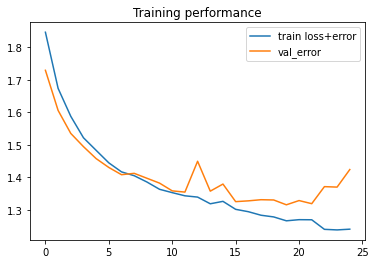

In [19]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

## Confusion matrix

In [20]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

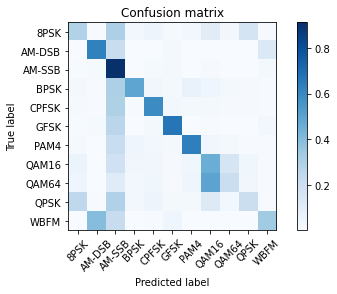

In [21]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=BATCH_SIZE)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])

for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1

for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

plot_confusion_matrix(confnorm, labels=classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.09346642468239565


Overall Accuracy:  0.08909694956206585


Overall Accuracy:  0.10297208045631942


Overall Accuracy:  0.1343909009278659


Overall Accuracy:  0.15391485561178922


Overall Accuracy:  0.19732034104750304


Overall Accuracy:  0.294313369630974


Overall Accuracy:  0.4035247645092677


Overall Accuracy:  0.4944226710883328


Overall Accuracy:  0.5836883749239197


Overall Accuracy:  0.6708978328173375


Overall Accuracy:  0.7179409993979531


Overall Accuracy:  0.7368421052631579


Overall Accuracy:  0.7463968107942349


Overall Accuracy:  0.7585253456221198


Overall Accuracy:  0.7436517533252721


Overall Accuracy:  0.7323216995447648


Overall Accuracy:  0.7339285714285714


Overall Accuracy:  0.7368579152898769


Overall Accuracy:  0.7297132397803539


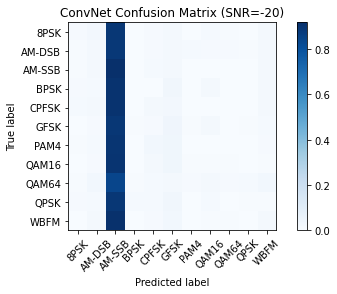

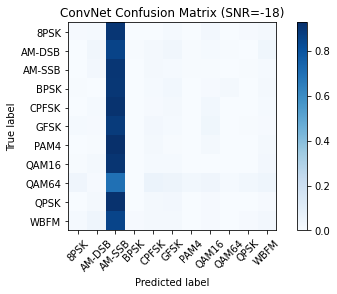

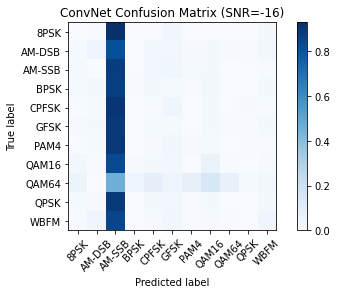

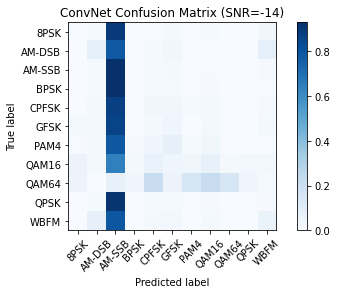

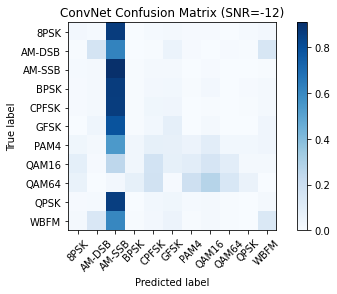

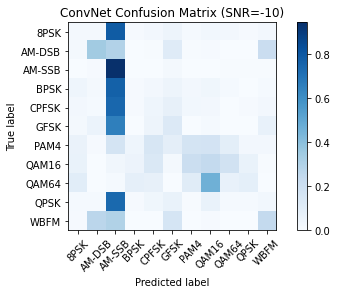

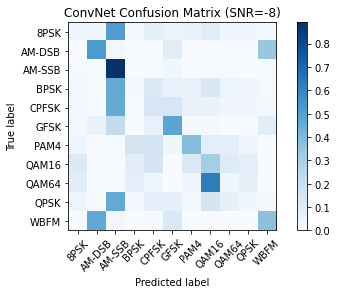

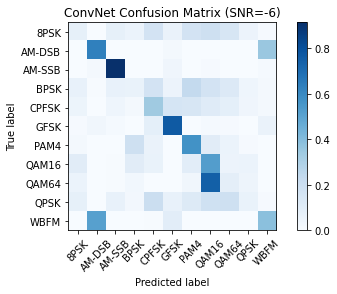

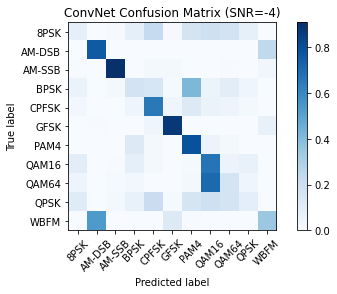

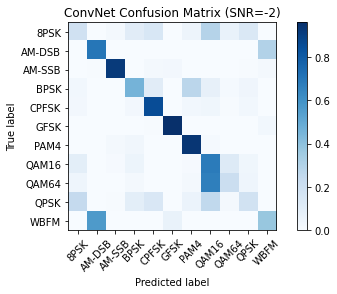

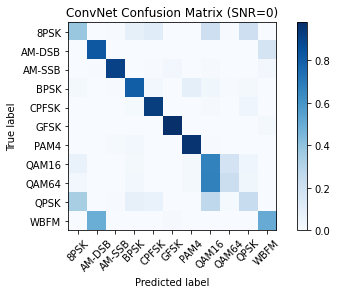

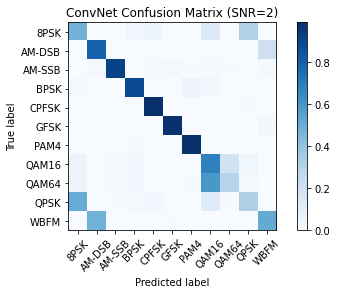

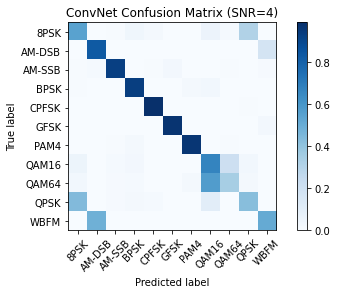

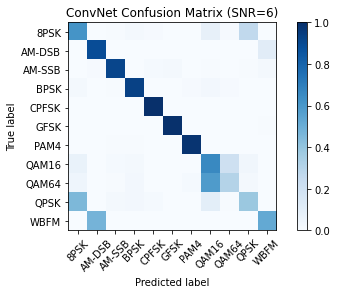

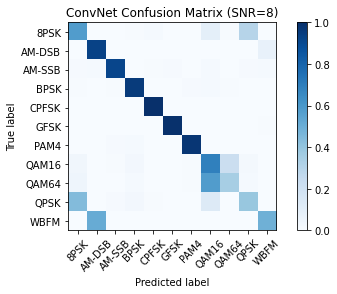

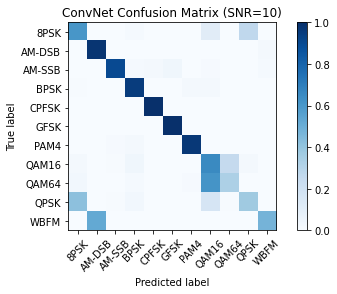

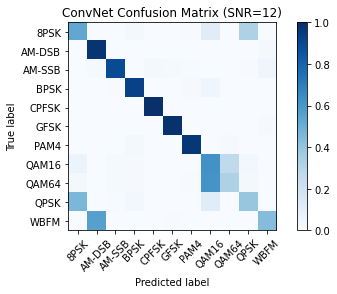

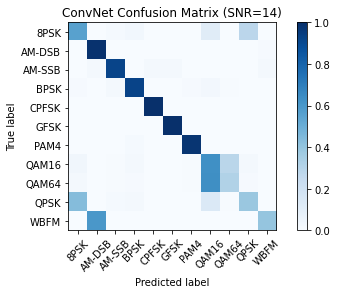

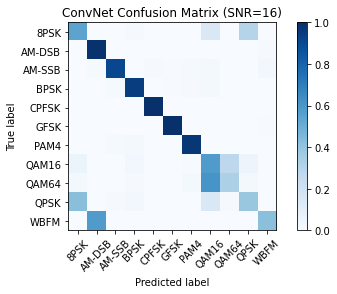

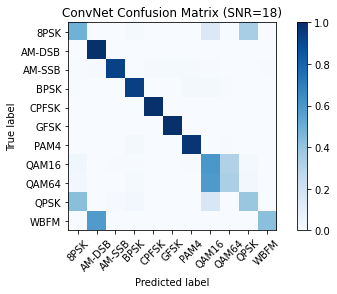

In [22]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(dataset_df[snr_column_dataframe_name][test_index])
    this_snr_indexes = np.where(np.array(test_SNRs) == snr)
    
    test_X_i = X_test[this_snr_indexes]
    test_Y_i = Y_test[this_snr_indexes]  

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes), len(classes)])
    confnorm = np.zeros([len(classes), len(classes)])
    
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i, :]).index(1)
        k = int(np.argmax(test_Y_i_hat[i, :]))
        conf[j, k] = conf[j, k] + 1
        
    for i in range(0,len(classes)):
        confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])
        
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

## Accuracy performance

In [23]:
accuracy_perc = {}
for el in acc.items():
    accuracy_perc[el[0]] = int(el[1] * 100)
    
accuracy_df = pd.DataFrame(data=accuracy_perc, index=["Accuracy %"])
# accuracy_df.columns = ["SNRs", "Accuracy"]
accuracy_df

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,9,8,10,13,15,19,29,40,49,58,67,71,73,74,75,74,73,73,73,72


In [24]:
# Save results to a pickle file for plotting later
fd = open(OUTPUT_FILENAME,'wb')
pickle.dump( ("CNN2", 0.5, acc) , fd )

Text(0.5, 1.0, 'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

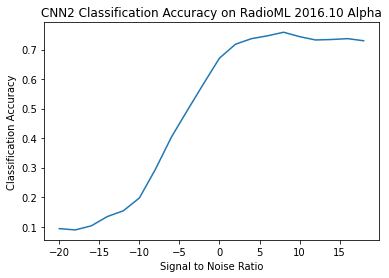

In [25]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")